In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import norm

In [5]:
def train(wd, n_hidden, n_iters, learning_rate, momentum_mul, do_early_stopping=False, minibatch_size=10):
    """
    a simple multilayer neural net for multiclass classification
    :param wd: weight_decay 
    :param n_hidden: number of units in hidden layer
    :param n_iters: number of sgd iteration
    :param learning_rate: 
    :param momentum_mul: velocity damping factor
    :param do_early_stopping: True if early_stopping is done, where we simply report the best past solution
    :param minibatch_size: size of minibatch in sgd
    :return: classification loss on the datasets
    """
    data_file = loadmat('data.mat', squeeze_me=True, struct_as_record=False)
    data = data_file['data']

    data_train = {'X': data.training.inputs, 'y': data.training.targets}
    data_valid = {'X': data.validation.inputs, 'y': data.validation.targets}
    data_test = {'X': data.test.inputs, 'y': data.test.targets}
    n_train = data_train['X'].shape[1]

    # initialize model
    params = initial_model(n_hidden)
    theta = model2theta(params)

    test_gradient(params, data_train, wd)
    # initialize velocity
    v = 0

    loss_train = []
    loss_valid = []
    best = {}

    if do_early_stopping:
        best['theta'] = 0
        best['loss_valid'] = np.inf
        best['iter'] = -1

    for t in range(n_iters + 1):
        batch_start = (t * minibatch_size) % n_train
        data_batch = {
            'X': data_train['X'][:, batch_start:batch_start + minibatch_size],
            'y': data_train['y'][:, batch_start:batch_start + minibatch_size]
        }

        # classical momentum
        #loss, grad = eval_obj_grad(theta2model(theta), data_batch, wd)
        #grad_vec = model2theta(grad)
        #v = momentum_mul * v - grad_vec
        #theta += learning_rate * v

        #todo Nesterov's accelerated method
        theta_nes = theta + momentum_mul * v
        loss, grad = eval_obj_grad(theta2model(theta_nes), data_batch, wd)
        grad_vec = model2theta(grad)
        v = momentum_mul * v - grad_vec
        theta += learning_rate * v
        
        params = theta2model(theta)

        loss = eval_obj(params, data_train, wd)
        loss_train.append(loss)
        loss = eval_obj(params, data_valid, wd)
        loss_valid.append(loss)

        if do_early_stopping and loss_valid[-1] < best['loss_valid']:
            best['theta'] = theta.copy()
            best['loss_valid'] = loss_valid[-1]
            best['iter'] = t

        if t % (max(1, n_iters // 10)) == 0:
            print('After %d iterations, ||theta|| %.3e, training loss is %.2e, and validation loss is %.2e\n' % (
            t, norm(theta), loss_train[-1],
            loss_valid[-1]))

    test_gradient(params, data_train, wd)

    plt.close()
    plt.figure()

    plt.plot(loss_train, label='training loss')
    plt.plot(loss_valid, label='validation loss')
    plt.legend(loc='best')
    plt.show()

    if do_early_stopping:
        print("Early stopping: validation loss: %.3e,  was lowest after %d iterations" % (
        best['loss_valid'], best['iter']))
        theta = best['theta']

    params = theta2model(theta)
    # examine performance
    datasets = [data_train, data_valid, data_test]

    acc = [accuracy(params, x) for x in datasets]

    classification_loss = [eval_obj(params, x, 0) for x in datasets]

    print("Accuracy: training %.3e, validation %.3e, testing %.3e" % (acc[0], acc[1], acc[2]))
    info = {
        'loss_train': classification_loss[0],
        'loss_valid': classification_loss[1],
        'loss_test': classification_loss[2]
    }
    return info


def eval_obj(params, data, wd):
    # W_hid, b_hid, W_out, b_out = params['W_hid'], params['b_hid'], params['W_out'], params['b_out']
    W_hid, W_out = params['W_hid'], params['W_out']
    
    loss = 0

    z_hid = W_hid.dot(data['X'])
    a_hid = sigmoid(z_hid)
    z_out = W_out.dot(a_hid)
    y_predict = np.exp(z_out - log_sum_exp(z_out))

    cross_entropy = 0
    cross_entropy +=  np.log(y_predict) * data['y'] + np.log(1- y_predict) * (1-data['y'] )
    
    weight_decay=0
    weight_decay=wd/2*(np.square(np.linalg.norm(W_out))+np.square(np.linalg.norm(W_hid)))

    loss =  -np.sum(cross_entropy)/data['y'].shape[1] + weight_decay /data['X'].shape[1]

    return loss


def eval_obj_grad(params, data, wd):
    """
    compute loss and gradient of model
    :param params: 
                    W_hid
                    W_out
    :param data:

    """
    W_hid, W_out = params['W_hid'], params['W_out']
    
    loss = 0

    z_hid = W_hid.dot(data['X'])
    a_hid = sigmoid(z_hid)
    z_out = W_out.dot(a_hid)
    y_predict = np.exp(z_out - log_sum_exp(z_out))

    cross_entropy = 0
    cross_entropy +=  np.log(y_predict) * data['y'] + np.log(1- y_predict) * (1-data['y'] ) 
    
    weight_decay=0
    weight_decay=wd/2*(np.square(np.linalg.norm(W_out))+np.square(np.linalg.norm(W_hid)))

    loss = - np.sum(cross_entropy)/data['y'].shape[1] + weight_decay /data['X'].shape[1]
    
    # todo implement the backward prapagation
    n_hidden=100
    grad_W_out = np.zeros((10, n_hidden))
    grad_W_hid = np.zeros((n_hidden, 256))

    error_out = (y_predict - data['y']) / data['y'].shape[1]
    dw2 = np.dot(error_out, a_hid.T)
    grad_W_out = dw2 + wd * W_out / data['X'].shape[1]

    error_hid = a_hid * (1 - a_hid) * np.dot(W_out.T, error_out)
    dw1 = np.dot(error_hid, data['X'].T) 
    grad_W_hid = dw1 + wd * W_hid / data['X'].shape[1]
    
    grad = {'W_out': grad_W_out,
            'W_hid': grad_W_hid,}

    return loss, grad


def initial_model(n_hid):
    n_params = (256 + 10) * n_hid
    as_row_vector = np.cos(np.arange(n_params))
    params = {}
    params['W_hid'] = as_row_vector[:256 * n_hid].reshape((n_hid, 256)) * 0.1
    params['W_out'] = as_row_vector[256 * n_hid:].reshape((10, n_hid)) * 0.1
    return params


def test_gradient(params, data, wd):
    loss, analytic_grad = eval_obj_grad(params, data, wd)

    num_checks = 100
    theta = model2theta(params)
    grad_ana = model2theta(analytic_grad)

    delta = 1e-4
    threshold = 1e-5

    for i in range(num_checks):
        ind = (i * 1299283) % theta.size
        grad_ind_ana = grad_ana[ind]

        theta1 = theta.copy()
        theta1[ind] += delta
        l1 = eval_obj(theta2model(theta1), data, wd)

        theta2 = theta.copy()
        theta2[ind] -= delta
        l2 = eval_obj(theta2model(theta2), data, wd)

        grad_ind_fin = (l1 - l2) / (2 * delta)
        diff = abs(grad_ind_ana - grad_ind_fin)
        if diff < threshold:
            continue
        if diff / (abs(grad_ind_ana) + abs(grad_ind_fin)) < threshold:
            continue
        raise AssertionError('%d-th: l %.3e, l1 %.3e, l2 %.3e, analytic %.3e, fd %.3e, diff %.3e\n'
                             % (i, loss, l1, l2, grad_ind_ana, grad_ind_fin, diff))
    print('Gradient test passed')


def model2theta(params):
    """
    convert model parameters into vector form
    :param params: 
    :return: 
    """
    theta = np.concatenate((params['W_out'].flatten(), params['W_hid'].flatten()))
    return theta


def theta2model(theta):
    """
    convert vector form into model parameters
    :param theta: 
    :return: 
    """
    n_hid = theta.size // (256 + 10)
    params = {}
    params['W_out'] = np.reshape(theta[:n_hid * 10], (10, n_hid))
    params['W_hid'] = np.reshape(theta[n_hid * 10:], (n_hid, 256))
    return params


def accuracy(params, data):
    W_hid, W_out = params['W_hid'], params['W_out']

    # indices of class label
    # class_indices = np.nonzero(data['y'])
    index_transpose = np.nonzero(data['y'].T)
    true_label = index_transpose[1]
    # forward propagation
    a_hidden = W_hid.dot(data['X'])
    h_hidden = sigmoid(a_hidden)

    a_out = W_out.dot(h_hidden)

    pred = a_out.argmax(axis=0)

    return np.mean(pred == true_label)


def log_sum_exp(x):
    """
    compute log(sum(exp(a), 0)), should return a n-dim vector
    :param x: p*n matrix
    """
    # todo implement the log column sum of exp(x)
    lse_x= np.log(np.sum(np.exp(x), axis = 0))
    
    return lse_x

def sigmoid(input):
    return 1 / (1 + np.exp(-input))

In [6]:
train(0, 10, 70, 0.005, 0, False, 4)

AssertionError: 0-th: l 3.253e+00, l1 3.253e+00, l2 3.253e+00, analytic -3.031e-03, fd -3.374e-03, diff 3.430e-04


In [7]:
learning_array=[0.002, 0.01, 0.05, 0.2, 1.0, 5.0]
df1 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])

Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 7 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 14 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 21 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 28 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 35 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 42 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 49 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 56 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 63 iterations, ||theta|| 3.647e+00, training loss is 2.30

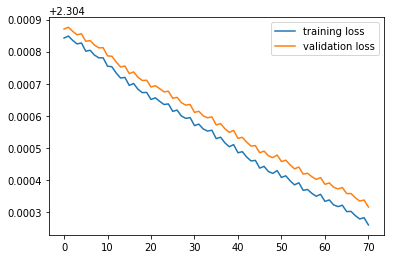

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 7 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 14 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 21 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 28 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 35 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 42 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 49 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 56 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.3

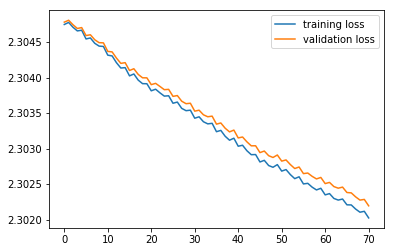

Accuracy: training 1.230e-01, validation 1.180e-01, testing 1.198e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 7 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 14 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 21 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 28 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 35 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 42 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 49 iterations, ||theta|| 3.651e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 56 iterations, ||theta|| 3.652e+00, training loss is 2.29e+00, and validation loss is 2.3

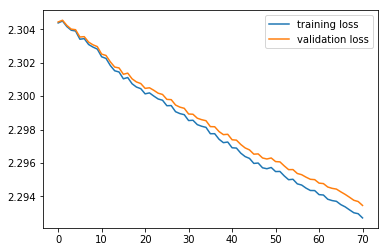

Accuracy: training 1.800e-01, validation 1.810e-01, testing 1.890e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 7 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 14 iterations, ||theta|| 3.658e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 21 iterations, ||theta|| 3.669e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 28 iterations, ||theta|| 3.683e+00, training loss is 2.28e+00, and validation loss is 2.29e+00

After 35 iterations, ||theta|| 3.701e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 42 iterations, ||theta|| 3.725e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 49 iterations, ||theta|| 3.747e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 56 iterations, ||theta|| 3.780e+00, training loss is 2.25e+00, and validation loss is 2.2

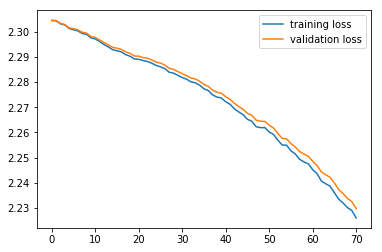

Accuracy: training 3.270e-01, validation 3.050e-01, testing 3.127e-01
Gradient test passed
After 0 iterations, ||theta|| 3.697e+00, training loss is 2.34e+00, and validation loss is 2.34e+00

After 7 iterations, ||theta|| 3.803e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 14 iterations, ||theta|| 3.969e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 21 iterations, ||theta|| 4.180e+00, training loss is 2.21e+00, and validation loss is 2.22e+00

After 28 iterations, ||theta|| 4.518e+00, training loss is 2.15e+00, and validation loss is 2.15e+00

After 35 iterations, ||theta|| 4.998e+00, training loss is 2.02e+00, and validation loss is 2.03e+00

After 42 iterations, ||theta|| 5.576e+00, training loss is 1.91e+00, and validation loss is 1.92e+00

After 49 iterations, ||theta|| 6.074e+00, training loss is 1.82e+00, and validation loss is 1.82e+00

After 56 iterations, ||theta|| 6.627e+00, training loss is 1.76e+00, and validation loss is 1.7

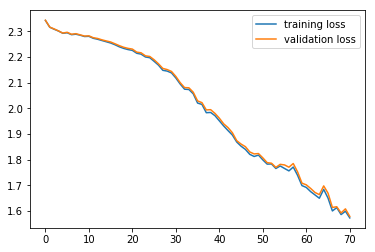

Accuracy: training 4.850e-01, validation 4.670e-01, testing 4.803e-01
Gradient test passed
After 0 iterations, ||theta|| 4.859e+00, training loss is 3.24e+00, and validation loss is 3.24e+00

After 7 iterations, ||theta|| 1.091e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 14 iterations, ||theta|| 1.089e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 21 iterations, ||theta|| 1.088e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 28 iterations, ||theta|| 1.086e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 35 iterations, ||theta|| 1.086e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 42 iterations, ||theta|| 1.083e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 49 iterations, ||theta|| 1.081e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 56 iterations, ||theta|| 1.078e+01, training loss is 2.30e+00, and validation loss is 2.3

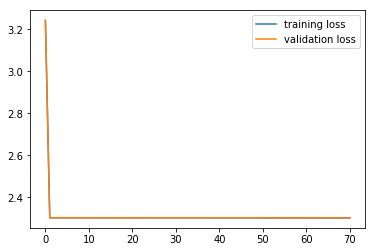

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01


In [8]:
for lr in learning_array:
    info=train(0, 10, 70, lr, 0, False, 4)
    loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
    df1=df1.append(loss_info,ignore_index=True) 

In [9]:
df1.index=['0.002', '0.01', '0.05', '0.2', '1.0', '5.0']
print("The best performance on validation data is under the learning rate 1.0")
df1

The best performance on validation data is under the learning rate 1.0


loss_train  loss_valid  loss_test
0.002    2.304260    2.304316   2.304330
0.01     2.302024    2.302194   2.302139
0.05     2.292717    2.293463   2.293053
0.2      2.226031    2.229733   2.227115
1.0      1.572740    1.578626   1.567040
5.0      2.301322    2.301741   2.302015

Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 70 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 80 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 90 iterations, ||theta|| 3.647e+00, training loss is 2.3

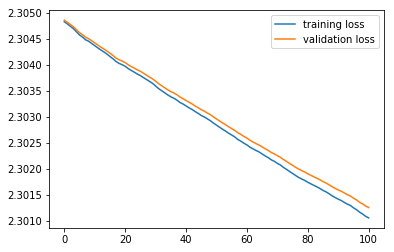

Accuracy: training 1.220e-01, validation 1.160e-01, testing 1.177e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 70 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 80 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.

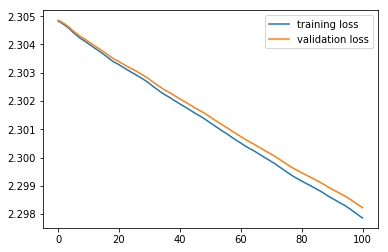

Accuracy: training 1.260e-01, validation 1.270e-01, testing 1.257e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.653e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.661e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.675e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 50 iterations, ||theta|| 3.694e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 60 iterations, ||theta|| 3.721e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 70 iterations, ||theta|| 3.754e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 80 iterations, ||theta|| 3.793e+00, training loss is 2.24e+00, and validation loss is 2.

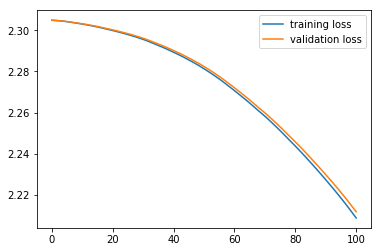

Accuracy: training 3.520e-01, validation 3.400e-01, testing 3.434e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.653e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 70 iterations, ||theta|| 3.655e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 80 iterations, ||theta|| 3.658e+00, training loss is 2.29e+00, and validation loss is 2.

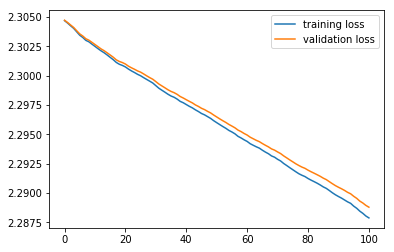

Accuracy: training 2.440e-01, validation 2.210e-01, testing 2.329e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.651e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.655e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 40 iterations, ||theta|| 3.661e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 50 iterations, ||theta|| 3.669e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 60 iterations, ||theta|| 3.680e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 70 iterations, ||theta|| 3.692e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 80 iterations, ||theta|| 3.707e+00, training loss is 2.27e+00, and validation loss is 2.

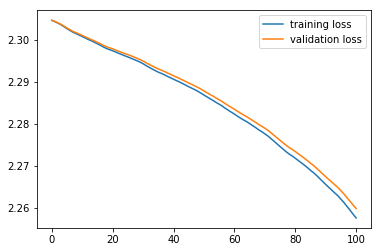

Accuracy: training 3.390e-01, validation 3.240e-01, testing 3.368e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.657e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.709e+00, training loss is 2.27e+00, and validation loss is 2.28e+00

After 30 iterations, ||theta|| 3.843e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 40 iterations, ||theta|| 4.098e+00, training loss is 2.14e+00, and validation loss is 2.15e+00

After 50 iterations, ||theta|| 4.452e+00, training loss is 2.04e+00, and validation loss is 2.05e+00

After 60 iterations, ||theta|| 4.903e+00, training loss is 1.93e+00, and validation loss is 1.94e+00

After 70 iterations, ||theta|| 5.366e+00, training loss is 1.83e+00, and validation loss is 1.84e+00

After 80 iterations, ||theta|| 5.821e+00, training loss is 1.74e+00, and validation loss is 1.

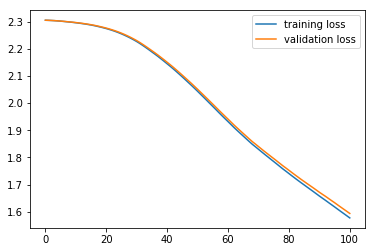

Accuracy: training 5.140e-01, validation 5.210e-01, testing 5.357e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.660e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 30 iterations, ||theta|| 3.677e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 40 iterations, ||theta|| 3.701e+00, training loss is 2.27e+00, and validation loss is 2.28e+00

After 50 iterations, ||theta|| 3.736e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 60 iterations, ||theta|| 3.786e+00, training loss is 2.24e+00, and validation loss is 2.25e+00

After 70 iterations, ||theta|| 3.846e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 80 iterations, ||theta|| 3.929e+00, training loss is 2.20e+00, and validation loss is 2.

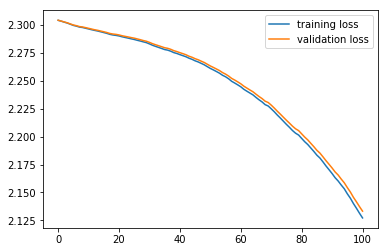

Accuracy: training 3.090e-01, validation 3.050e-01, testing 3.174e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.664e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 20 iterations, ||theta|| 3.710e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 30 iterations, ||theta|| 3.800e+00, training loss is 2.24e+00, and validation loss is 2.24e+00

After 40 iterations, ||theta|| 3.963e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 50 iterations, ||theta|| 4.208e+00, training loss is 2.11e+00, and validation loss is 2.12e+00

After 60 iterations, ||theta|| 4.546e+00, training loss is 2.02e+00, and validation loss is 2.03e+00

After 70 iterations, ||theta|| 4.893e+00, training loss is 1.94e+00, and validation loss is 1.95e+00

After 80 iterations, ||theta|| 5.289e+00, training loss is 1.85e+00, and validation loss is 1.

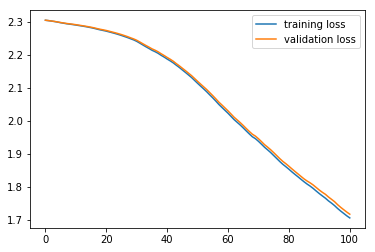

Accuracy: training 4.140e-01, validation 3.870e-01, testing 4.127e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.751e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 20 iterations, ||theta|| 4.470e+00, training loss is 2.06e+00, and validation loss is 2.07e+00

After 30 iterations, ||theta|| 6.062e+00, training loss is 1.74e+00, and validation loss is 1.75e+00

After 40 iterations, ||theta|| 7.865e+00, training loss is 1.45e+00, and validation loss is 1.48e+00

After 50 iterations, ||theta|| 9.670e+00, training loss is 1.21e+00, and validation loss is 1.25e+00

After 60 iterations, ||theta|| 1.141e+01, training loss is 1.00e+00, and validation loss is 1.05e+00

After 70 iterations, ||theta|| 1.287e+01, training loss is 8.38e-01, and validation loss is 8.89e-01

After 80 iterations, ||theta|| 1.414e+01, training loss is 7.19e-01, and validation loss is 7.

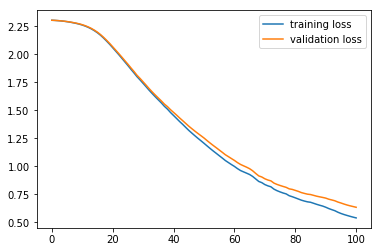

Accuracy: training 8.860e-01, validation 8.390e-01, testing 8.618e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.777e+00, training loss is 2.25e+00, and validation loss is 2.26e+00

After 20 iterations, ||theta|| 4.221e+00, training loss is 2.12e+00, and validation loss is 2.12e+00

After 30 iterations, ||theta|| 5.096e+00, training loss is 1.91e+00, and validation loss is 1.92e+00

After 40 iterations, ||theta|| 6.008e+00, training loss is 1.73e+00, and validation loss is 1.75e+00

After 50 iterations, ||theta|| 7.014e+00, training loss is 1.57e+00, and validation loss is 1.59e+00

After 60 iterations, ||theta|| 8.004e+00, training loss is 1.44e+00, and validation loss is 1.46e+00

After 70 iterations, ||theta|| 8.750e+00, training loss is 1.31e+00, and validation loss is 1.33e+00

After 80 iterations, ||theta|| 9.581e+00, training loss is 1.18e+00, and validation loss is 1.

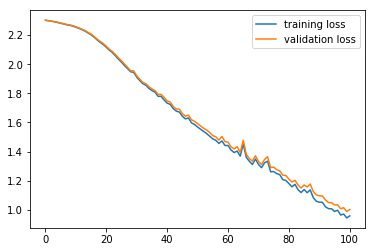

Accuracy: training 7.610e-01, validation 7.490e-01, testing 7.518e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 4.135e+00, training loss is 2.16e+00, and validation loss is 2.17e+00

After 20 iterations, ||theta|| 5.861e+00, training loss is 1.78e+00, and validation loss is 1.79e+00

After 30 iterations, ||theta|| 7.855e+00, training loss is 1.48e+00, and validation loss is 1.50e+00

After 40 iterations, ||theta|| 9.654e+00, training loss is 1.25e+00, and validation loss is 1.31e+00

After 50 iterations, ||theta|| 1.134e+01, training loss is 9.96e-01, and validation loss is 1.05e+00

After 60 iterations, ||theta|| 1.288e+01, training loss is 8.96e-01, and validation loss is 9.50e-01

After 70 iterations, ||theta|| 1.418e+01, training loss is 7.65e-01, and validation loss is 8.22e-01

After 80 iterations, ||theta|| 1.525e+01, training loss is 6.48e-01, and validation loss is 7.

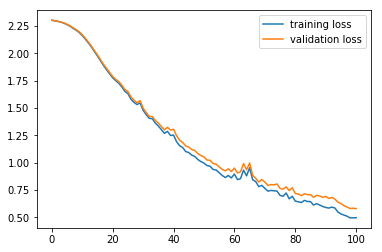

Accuracy: training 8.860e-01, validation 8.500e-01, testing 8.619e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 5.926e+00, training loss is 1.86e+00, and validation loss is 1.88e+00

After 20 iterations, ||theta|| 1.359e+01, training loss is 1.13e+00, and validation loss is 1.17e+00

After 30 iterations, ||theta|| 2.169e+01, training loss is 8.83e-01, and validation loss is 9.15e-01

After 40 iterations, ||theta|| 2.824e+01, training loss is 8.58e-01, and validation loss is 9.71e-01

After 50 iterations, ||theta|| 3.347e+01, training loss is 8.34e-01, and validation loss is 9.41e-01

After 60 iterations, ||theta|| 3.793e+01, training loss is 8.73e-01, and validation loss is 9.53e-01

After 70 iterations, ||theta|| 4.193e+01, training loss is 8.51e-01, and validation loss is 9.55e-01

After 80 iterations, ||theta|| 4.582e+01, training loss is 9.07e-01, and validation loss is 9.

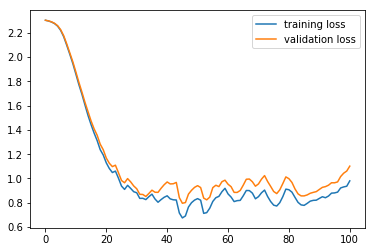

Accuracy: training 6.770e-01, validation 6.900e-01, testing 6.718e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 8.226e+00, training loss is 1.98e+00, and validation loss is 1.99e+00

After 20 iterations, ||theta|| 1.208e+01, training loss is 1.46e+00, and validation loss is 1.47e+00

After 30 iterations, ||theta|| 1.578e+01, training loss is 1.41e+00, and validation loss is 1.47e+00

After 40 iterations, ||theta|| 1.948e+01, training loss is 1.13e+00, and validation loss is 1.20e+00

After 50 iterations, ||theta|| 2.198e+01, training loss is 1.11e+00, and validation loss is 1.14e+00

After 60 iterations, ||theta|| 2.487e+01, training loss is 1.72e+00, and validation loss is 1.81e+00

After 70 iterations, ||theta|| 2.737e+01, training loss is 8.96e-01, and validation loss is 9.45e-01

After 80 iterations, ||theta|| 2.879e+01, training loss is 1.22e+00, and validation loss is 1.

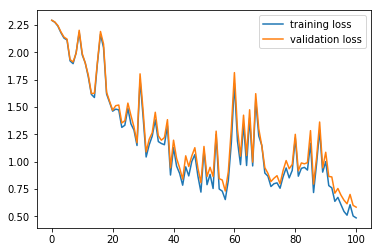

Accuracy: training 8.520e-01, validation 8.110e-01, testing 8.144e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 1.271e+01, training loss is 1.85e+00, and validation loss is 1.86e+00

After 20 iterations, ||theta|| 1.963e+01, training loss is 1.45e+00, and validation loss is 1.49e+00

After 30 iterations, ||theta|| 2.693e+01, training loss is 1.36e+00, and validation loss is 1.37e+00

After 40 iterations, ||theta|| 3.223e+01, training loss is 1.12e+00, and validation loss is 1.16e+00

After 50 iterations, ||theta|| 3.923e+01, training loss is 1.23e+00, and validation loss is 1.29e+00

After 60 iterations, ||theta|| 4.355e+01, training loss is 1.32e+00, and validation loss is 1.40e+00

After 70 iterations, ||theta|| 4.638e+01, training loss is 9.71e-01, and validation loss is 1.01e+00

After 80 iterations, ||theta|| 5.001e+01, training loss is 1.46e+00, and validation loss is 1.

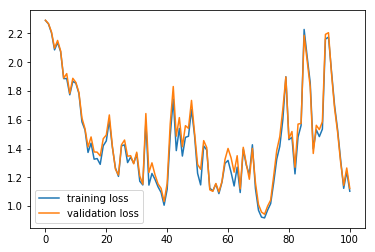

Accuracy: training 6.250e-01, validation 6.200e-01, testing 6.092e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 2.827e+01, training loss is 1.76e+00, and validation loss is 1.76e+00

After 20 iterations, ||theta|| 6.293e+01, training loss is 2.22e+00, and validation loss is 2.21e+00

After 30 iterations, ||theta|| 1.027e+02, training loss is 2.78e+00, and validation loss is 2.68e+00

After 40 iterations, ||theta|| 1.362e+02, training loss is 4.23e+00, and validation loss is 4.24e+00

After 50 iterations, ||theta|| 1.558e+02, training loss is 6.53e+00, and validation loss is 6.62e+00

After 60 iterations, ||theta|| 1.671e+02, training loss is 4.29e+00, and validation loss is 4.28e+00

After 70 iterations, ||theta|| 1.763e+02, training loss is 3.48e+00, and validation loss is 3.49e+00

After 80 iterations, ||theta|| 1.838e+02, training loss is 3.70e+00, and validation loss is 3.

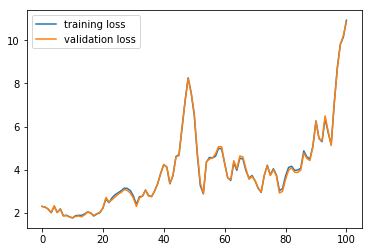

Accuracy: training 1.790e-01, validation 1.770e-01, testing 1.764e-01


In [15]:
learning_array2=[0.01, 0.05, 0.2, 1.0, 5.0]
momentum_array=[0,0.5,0.9]
n_hidden =10
n_iters = 100
df2 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for lr1 in learning_array2:
    for mm in momentum_array:
        info=train(0, n_hidden, n_iters, lr1, mm, do_early_stopping=False, minibatch_size=10)
        loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
        df2=df2.append(loss_info,ignore_index=True) 

In [16]:
df2.index=['l1m1', 'l1m2', 'l1m3', 'l2m1', 'l2m2', 'l2m3','l3m1', 'l3m2', 'l3m3','l4m1', 'l4m2', 'l4m3','l5m1', 'l5m2', 'l5m3']
print("The best performance on validation data is under the learning rate 1.0 and the momentum mul 0.5")
df2

The best performance on validation data is under the learning rate 1.0 and the momentum mul 0.5


loss_train  loss_valid  loss_test
l1m1    2.301054    2.301254   2.301191
l1m2    2.297867    2.298234   2.298078
l1m3    2.208845    2.211843   2.209502
l2m1    2.287880    2.288793   2.288329
l2m2    2.257571    2.259803   2.258473
l2m3    1.577063    1.593422   1.582482
l3m1    2.127231    2.133296   2.128699
l3m2    1.705942    1.717178   1.707245
l3m3    0.540118    0.635027   0.596546
l4m1    0.959017    1.002423   0.982117
l4m2    0.496829    0.579388   0.552242
l4m3    0.980447    1.101497   1.062799
l5m1    0.485624    0.583969   0.592234
l5m2    1.103199    1.122893   1.116112
l5m3   10.930663   10.863314  11.050260

Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 70 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 80 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 90 iterations, ||theta|| 3.647e+00, training loss is 2.3

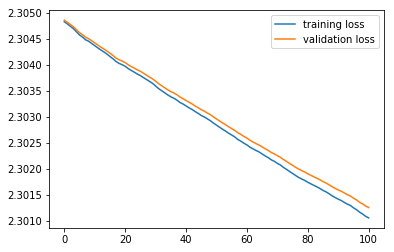

Accuracy: training 1.220e-01, validation 1.160e-01, testing 1.177e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 70 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 80 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.

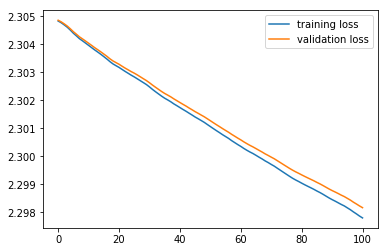

Accuracy: training 1.240e-01, validation 1.240e-01, testing 1.232e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.652e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 50 iterations, ||theta|| 3.657e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 60 iterations, ||theta|| 3.663e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 70 iterations, ||theta|| 3.671e+00, training loss is 2.28e+00, and validation loss is 2.29e+00

After 80 iterations, ||theta|| 3.681e+00, training loss is 2.28e+00, and validation loss is 2.

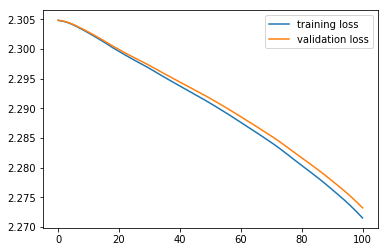

Accuracy: training 3.740e-01, validation 3.530e-01, testing 3.699e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 50 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 60 iterations, ||theta|| 3.653e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 70 iterations, ||theta|| 3.655e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 80 iterations, ||theta|| 3.658e+00, training loss is 2.29e+00, and validation loss is 2.

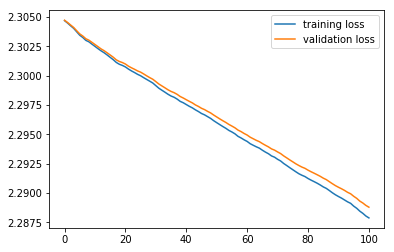

Accuracy: training 2.440e-01, validation 2.210e-01, testing 2.329e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.649e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 30 iterations, ||theta|| 3.652e+00, training loss is 2.29e+00, and validation loss is 2.30e+00

After 40 iterations, ||theta|| 3.657e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 50 iterations, ||theta|| 3.664e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 60 iterations, ||theta|| 3.673e+00, training loss is 2.28e+00, and validation loss is 2.29e+00

After 70 iterations, ||theta|| 3.683e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 80 iterations, ||theta|| 3.696e+00, training loss is 2.28e+00, and validation loss is 2.

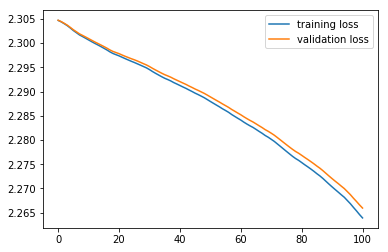

Accuracy: training 3.490e-01, validation 3.340e-01, testing 3.456e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.675e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 30 iterations, ||theta|| 3.729e+00, training loss is 2.26e+00, and validation loss is 2.27e+00

After 40 iterations, ||theta|| 3.834e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 50 iterations, ||theta|| 4.008e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 60 iterations, ||theta|| 4.292e+00, training loss is 2.10e+00, and validation loss is 2.10e+00

After 70 iterations, ||theta|| 4.673e+00, training loss is 2.00e+00, and validation loss is 2.01e+00

After 80 iterations, ||theta|| 5.137e+00, training loss is 1.90e+00, and validation loss is 1.

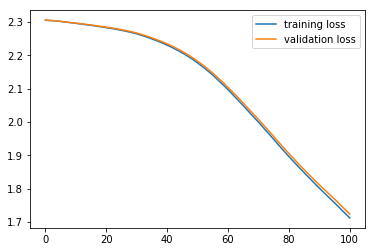

Accuracy: training 3.980e-01, validation 3.810e-01, testing 3.926e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.650e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 20 iterations, ||theta|| 3.660e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 30 iterations, ||theta|| 3.677e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 40 iterations, ||theta|| 3.701e+00, training loss is 2.27e+00, and validation loss is 2.28e+00

After 50 iterations, ||theta|| 3.736e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 60 iterations, ||theta|| 3.786e+00, training loss is 2.24e+00, and validation loss is 2.25e+00

After 70 iterations, ||theta|| 3.846e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 80 iterations, ||theta|| 3.929e+00, training loss is 2.20e+00, and validation loss is 2.

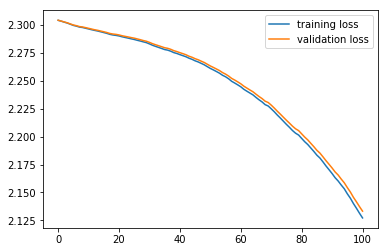

Accuracy: training 3.090e-01, validation 3.050e-01, testing 3.174e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.660e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 20 iterations, ||theta|| 3.700e+00, training loss is 2.27e+00, and validation loss is 2.28e+00

After 30 iterations, ||theta|| 3.773e+00, training loss is 2.25e+00, and validation loss is 2.25e+00

After 40 iterations, ||theta|| 3.908e+00, training loss is 2.21e+00, and validation loss is 2.21e+00

After 50 iterations, ||theta|| 4.118e+00, training loss is 2.14e+00, and validation loss is 2.15e+00

After 60 iterations, ||theta|| 4.424e+00, training loss is 2.06e+00, and validation loss is 2.06e+00

After 70 iterations, ||theta|| 4.758e+00, training loss is 1.97e+00, and validation loss is 1.98e+00

After 80 iterations, ||theta|| 5.153e+00, training loss is 1.88e+00, and validation loss is 1.

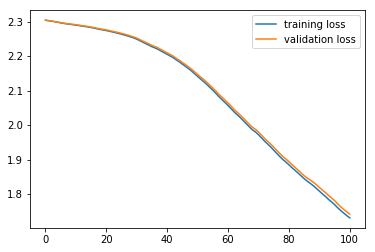

Accuracy: training 4.010e-01, validation 3.680e-01, testing 3.989e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.719e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 20 iterations, ||theta|| 4.172e+00, training loss is 2.14e+00, and validation loss is 2.15e+00

After 30 iterations, ||theta|| 5.472e+00, training loss is 1.86e+00, and validation loss is 1.87e+00

After 40 iterations, ||theta|| 7.286e+00, training loss is 1.59e+00, and validation loss is 1.61e+00

After 50 iterations, ||theta|| 9.108e+00, training loss is 1.36e+00, and validation loss is 1.39e+00

After 60 iterations, ||theta|| 1.090e+01, training loss is 1.16e+00, and validation loss is 1.21e+00

After 70 iterations, ||theta|| 1.234e+01, training loss is 9.84e-01, and validation loss is 1.03e+00

After 80 iterations, ||theta|| 1.369e+01, training loss is 8.38e-01, and validation loss is 9.

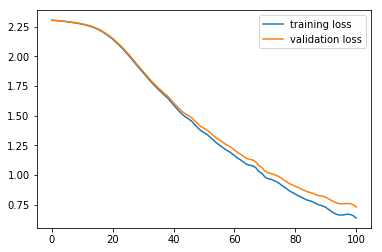

Accuracy: training 8.540e-01, validation 8.020e-01, testing 8.258e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 3.777e+00, training loss is 2.25e+00, and validation loss is 2.26e+00

After 20 iterations, ||theta|| 4.221e+00, training loss is 2.12e+00, and validation loss is 2.12e+00

After 30 iterations, ||theta|| 5.096e+00, training loss is 1.91e+00, and validation loss is 1.92e+00

After 40 iterations, ||theta|| 6.008e+00, training loss is 1.73e+00, and validation loss is 1.75e+00

After 50 iterations, ||theta|| 7.014e+00, training loss is 1.57e+00, and validation loss is 1.59e+00

After 60 iterations, ||theta|| 8.004e+00, training loss is 1.44e+00, and validation loss is 1.46e+00

After 70 iterations, ||theta|| 8.750e+00, training loss is 1.31e+00, and validation loss is 1.33e+00

After 80 iterations, ||theta|| 9.581e+00, training loss is 1.18e+00, and validation loss is 1.

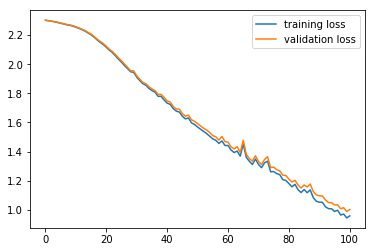

Accuracy: training 7.610e-01, validation 7.490e-01, testing 7.518e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 4.087e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 20 iterations, ||theta|| 5.755e+00, training loss is 1.80e+00, and validation loss is 1.81e+00

After 30 iterations, ||theta|| 7.774e+00, training loss is 1.51e+00, and validation loss is 1.53e+00

After 40 iterations, ||theta|| 9.597e+00, training loss is 1.32e+00, and validation loss is 1.38e+00

After 50 iterations, ||theta|| 1.133e+01, training loss is 1.01e+00, and validation loss is 1.07e+00

After 60 iterations, ||theta|| 1.289e+01, training loss is 8.96e-01, and validation loss is 9.51e-01

After 70 iterations, ||theta|| 1.413e+01, training loss is 7.85e-01, and validation loss is 8.42e-01

After 80 iterations, ||theta|| 1.520e+01, training loss is 6.77e-01, and validation loss is 7.

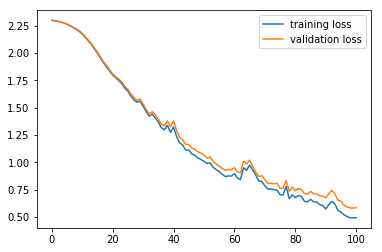

Accuracy: training 8.890e-01, validation 8.590e-01, testing 8.611e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 10 iterations, ||theta|| 5.592e+00, training loss is 1.92e+00, and validation loss is 1.93e+00

After 20 iterations, ||theta|| 1.310e+01, training loss is 1.26e+00, and validation loss is 1.30e+00

After 30 iterations, ||theta|| 2.122e+01, training loss is 9.88e-01, and validation loss is 1.03e+00

After 40 iterations, ||theta|| 2.801e+01, training loss is 1.02e+00, and validation loss is 1.11e+00

After 50 iterations, ||theta|| 3.458e+01, training loss is 1.18e+00, and validation loss is 1.28e+00

After 60 iterations, ||theta|| 3.988e+01, training loss is 1.08e+00, and validation loss is 1.16e+00

After 70 iterations, ||theta|| 4.479e+01, training loss is 1.06e+00, and validation loss is 1.11e+00

After 80 iterations, ||theta|| 4.903e+01, training loss is 1.09e+00, and validation loss is 1.

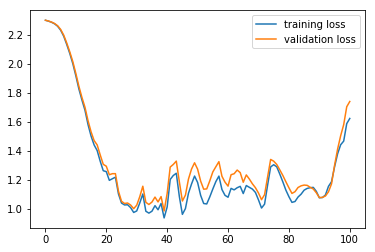

Accuracy: training 5.540e-01, validation 5.250e-01, testing 5.432e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 8.226e+00, training loss is 1.98e+00, and validation loss is 1.99e+00

After 20 iterations, ||theta|| 1.208e+01, training loss is 1.46e+00, and validation loss is 1.47e+00

After 30 iterations, ||theta|| 1.578e+01, training loss is 1.41e+00, and validation loss is 1.47e+00

After 40 iterations, ||theta|| 1.948e+01, training loss is 1.13e+00, and validation loss is 1.20e+00

After 50 iterations, ||theta|| 2.198e+01, training loss is 1.11e+00, and validation loss is 1.14e+00

After 60 iterations, ||theta|| 2.487e+01, training loss is 1.72e+00, and validation loss is 1.81e+00

After 70 iterations, ||theta|| 2.737e+01, training loss is 8.96e-01, and validation loss is 9.45e-01

After 80 iterations, ||theta|| 2.879e+01, training loss is 1.22e+00, and validation loss is 1.

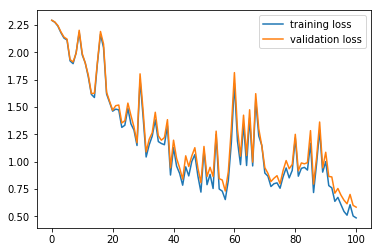

Accuracy: training 8.520e-01, validation 8.110e-01, testing 8.144e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 1.320e+01, training loss is 1.87e+00, and validation loss is 1.90e+00

After 20 iterations, ||theta|| 2.153e+01, training loss is 1.55e+00, and validation loss is 1.62e+00

After 30 iterations, ||theta|| 2.873e+01, training loss is 1.71e+00, and validation loss is 1.78e+00

After 40 iterations, ||theta|| 3.446e+01, training loss is 1.67e+00, and validation loss is 1.66e+00

After 50 iterations, ||theta|| 3.975e+01, training loss is 1.48e+00, and validation loss is 1.53e+00

After 60 iterations, ||theta|| 4.333e+01, training loss is 1.47e+00, and validation loss is 1.52e+00

After 70 iterations, ||theta|| 4.656e+01, training loss is 1.25e+00, and validation loss is 1.31e+00

After 80 iterations, ||theta|| 4.925e+01, training loss is 1.23e+00, and validation loss is 1.

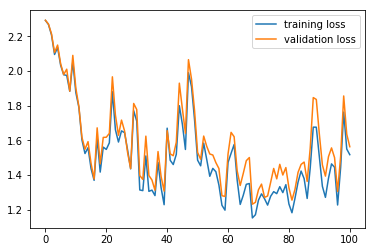

Accuracy: training 5.560e-01, validation 5.470e-01, testing 5.488e-01
Gradient test passed
After 0 iterations, ||theta|| 3.682e+00, training loss is 2.29e+00, and validation loss is 2.29e+00

After 10 iterations, ||theta|| 2.877e+01, training loss is 2.19e+00, and validation loss is 2.27e+00

After 20 iterations, ||theta|| 7.159e+01, training loss is 2.41e+00, and validation loss is 2.40e+00

After 30 iterations, ||theta|| 1.155e+02, training loss is 3.39e+00, and validation loss is 3.50e+00

After 40 iterations, ||theta|| 1.456e+02, training loss is 2.67e+00, and validation loss is 2.69e+00

After 50 iterations, ||theta|| 1.619e+02, training loss is 2.39e+00, and validation loss is 2.42e+00

After 60 iterations, ||theta|| 1.701e+02, training loss is 2.34e+00, and validation loss is 2.34e+00

After 70 iterations, ||theta|| 1.746e+02, training loss is 2.20e+00, and validation loss is 2.24e+00

After 80 iterations, ||theta|| 1.831e+02, training loss is 2.35e+00, and validation loss is 2.

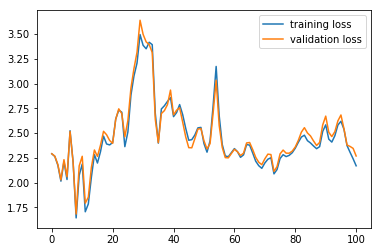

Accuracy: training 2.420e-01, validation 2.150e-01, testing 2.301e-01


In [12]:
learning_array2=[0.01, 0.05, 0.2, 1.0, 5.0]
momentum_array=[0,0.5,0.9]
n_hidden =10
n_iters = 100
df3 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for lr1 in learning_array2:
    for mm in momentum_array:
        info=train(0, n_hidden, n_iters, lr1, mm, do_early_stopping=False, minibatch_size=10)
        loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
        df3=df3.append(loss_info,ignore_index=True) 

In [13]:
df3.index=['l1m1', 'l1m2', 'l1m3', 'l2m1', 'l2m2', 'l2m3','l3m1', 'l3m2', 'l3m3','l4m1', 'l4m2', 'l4m3','l5m1', 'l5m2', 'l5m3']
print("As for Nesterov Accelerated Method, the best performance on validation data is under the learning rate 1.0 and the momentum mul 0.5.The result shows that the best parameter is the same and Nesterov gives a better performance.")
df3

As for Nesterov Accelerated Method, the best performance on validation data is under the learning rate 1.0 and the momentum mul 0.5.The result shows that the best parameter is the same and Nesterov gives a better performance.


loss_train  loss_valid  loss_test
l1m1    2.301054    2.301254   2.301191
l1m2    2.297801    2.298167   2.298013
l1m3    2.271529    2.273230   2.272309
l2m1    2.287880    2.288793   2.288329
l2m2    2.263925    2.265962   2.264805
l2m3    1.711966    1.723489   1.713227
l3m1    2.127231    2.133296   2.128699
l3m2    1.730742    1.741502   1.731620
l3m3    0.637584    0.730685   0.685974
l4m1    0.959017    1.002423   0.982117
l4m2    0.492569    0.583290   0.555243
l4m3    1.624751    1.741678   1.701367
l5m1    0.485624    0.583969   0.592234
l5m2    1.516542    1.562454   1.520241
l5m3    2.170323    2.269300   2.189903

In [507]:
print("Part3: Given that nesterov method has a better performance, we choose l3m3 and set momentum as 0.9.")

Part3: Given that nesterov method has a better performance, we choose l3m3 and set momentum as 0.9.


Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.399e+01, training loss is 3.38e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.831e+01, training loss is 1.39e-01, and validation loss is 2.99e-01

After 300 iterations, ||theta|| 3.092e+01, training loss is 8.99e-02, and validation loss is 3.10e-01

After 400 iterations, ||theta|| 3.284e+01, training loss is 5.77e-02, and validation loss is 3.16e-01

After 500 iterations, ||theta|| 3.414e+01, training loss is 2.89e-02, and validation loss is 2.95e-01

After 600 iterations, ||theta|| 3.509e+01, training loss is 1.83e-02, and validation loss is 3.16e-01

After 700 iterations, ||theta|| 3.563e+01, training loss is 1.12e-02, and validation loss is 3.26e-01

After 800 iterations, ||theta|| 3.601e+01, training loss is 6.66e-03, and validation loss is 3.22e-01

After 900 iterations, ||theta|| 3.627e+01, training lo

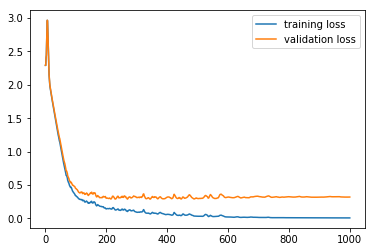

Early stopping: validation loss: 2.861e-01,  was lowest after 344 iterations
Accuracy: training 9.870e-01, validation 9.120e-01, testing 9.131e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.396e+01, training loss is 3.38e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.824e+01, training loss is 1.39e-01, and validation loss is 2.99e-01

After 300 iterations, ||theta|| 3.082e+01, training loss is 9.02e-02, and validation loss is 3.10e-01

After 400 iterations, ||theta|| 3.269e+01, training loss is 5.82e-02, and validation loss is 3.15e-01

After 500 iterations, ||theta|| 3.394e+01, training loss is 2.93e-02, and validation loss is 2.94e-01

After 600 iterations, ||theta|| 3.484e+01, training loss is 1.88e-02, and validation loss is 3.16e-01

After 700 iterations, ||theta|| 3.533e+01, training loss is 1.16e-02, and validation loss is 3.24e-01

After 800 

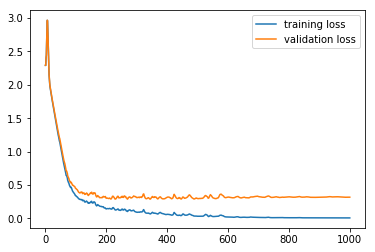

Early stopping: validation loss: 2.862e-01,  was lowest after 344 iterations
Accuracy: training 9.870e-01, validation 9.120e-01, testing 9.130e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.370e+01, training loss is 3.39e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.767e+01, training loss is 1.41e-01, and validation loss is 2.99e-01

After 300 iterations, ||theta|| 2.991e+01, training loss is 9.35e-02, and validation loss is 3.11e-01

After 400 iterations, ||theta|| 3.142e+01, training loss is 6.23e-02, and validation loss is 3.09e-01

After 500 iterations, ||theta|| 3.225e+01, training loss is 3.32e-02, and validation loss is 2.93e-01

After 600 iterations, ||theta|| 3.282e+01, training loss is 2.67e-02, and validation loss is 3.20e-01

After 700 iterations, ||theta|| 3.293e+01, training loss is 1.61e-02, and validation loss is 3.11e-01

After 800 

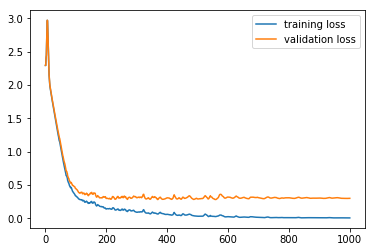

Early stopping: validation loss: 2.827e-01,  was lowest after 369 iterations
Accuracy: training 9.810e-01, validation 9.150e-01, testing 9.124e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.142e+01, training loss is 3.49e-01, and validation loss is 4.48e-01

After 200 iterations, ||theta|| 2.300e+01, training loss is 1.66e-01, and validation loss is 3.10e-01

After 300 iterations, ||theta|| 2.328e+01, training loss is 1.22e-01, and validation loss is 3.03e-01

After 400 iterations, ||theta|| 2.320e+01, training loss is 1.01e-01, and validation loss is 2.97e-01

After 500 iterations, ||theta|| 2.302e+01, training loss is 8.51e-02, and validation loss is 2.93e-01

After 600 iterations, ||theta|| 2.260e+01, training loss is 7.70e-02, and validation loss is 2.88e-01

After 700 iterations, ||theta|| 2.228e+01, training loss is 7.27e-02, and validation loss is 2.86e-01

After 800 

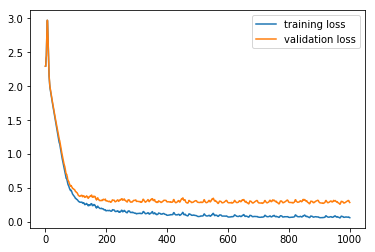

Early stopping: validation loss: 2.632e-01,  was lowest after 968 iterations
Accuracy: training 9.900e-01, validation 9.150e-01, testing 9.147e-01
Gradient test passed
After 0 iterations, ||theta|| 1.628e+01, training loss is 2.31e+00, and validation loss is 2.31e+00

After 100 iterations, ||theta|| 1.209e+01, training loss is 5.52e-01, and validation loss is 6.07e-01

After 200 iterations, ||theta|| 1.225e+01, training loss is 4.62e-01, and validation loss is 5.33e-01

After 300 iterations, ||theta|| 1.227e+01, training loss is 4.53e-01, and validation loss is 5.24e-01

After 400 iterations, ||theta|| 1.227e+01, training loss is 4.50e-01, and validation loss is 5.21e-01

After 500 iterations, ||theta|| 1.227e+01, training loss is 4.48e-01, and validation loss is 5.18e-01

After 600 iterations, ||theta|| 1.226e+01, training loss is 4.47e-01, and validation loss is 5.17e-01

After 700 iterations, ||theta|| 1.226e+01, training loss is 4.46e-01, and validation loss is 5.16e-01

After 800 

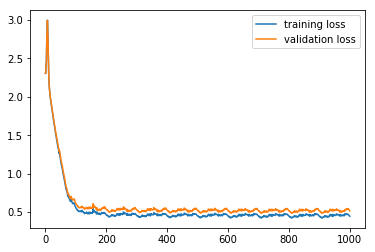

Early stopping: validation loss: 4.831e-01,  was lowest after 910 iterations
Accuracy: training 9.210e-01, validation 8.980e-01, testing 8.927e-01
Gradient test passed
After 0 iterations, ||theta|| 1.598e+01, training loss is 2.42e+00, and validation loss is 2.42e+00

After 100 iterations, ||theta|| 2.210e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 200 iterations, ||theta|| 2.247e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 300 iterations, ||theta|| 2.277e+00, training loss is 2.28e+00, and validation loss is 2.29e+00

After 400 iterations, ||theta|| 2.233e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 500 iterations, ||theta|| 2.324e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 600 iterations, ||theta|| 2.291e+00, training loss is 2.27e+00, and validation loss is 2.27e+00

After 700 iterations, ||theta|| 2.275e+00, training loss is 2.26e+00, and validation loss is 2.26e+00

After 800 

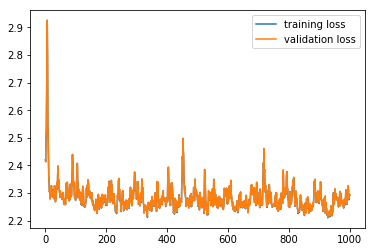

Early stopping: validation loss: 2.213e+00,  was lowest after 928 iterations
Accuracy: training 2.460e-01, validation 2.320e-01, testing 2.408e-01
Gradient test passed
After 0 iterations, ||theta|| 1.305e+01, training loss is 3.15e+00, and validation loss is 3.15e+00

After 100 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 200 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 300 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 400 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 500 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 600 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 700 iterations, ||theta|| 8.278e-01, training loss is 2.47e+00, and validation loss is 2.47e+00

After 800 

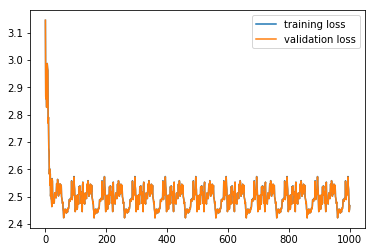

Early stopping: validation loss: 2.422e+00,  was lowest after 360 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01


In [17]:
n_hidden = 200
n_iters = 1000
learning_rate=0.2
wd_array=[0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
df4 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for wd in wd_array:
    info=train(wd, n_hidden, n_iters, learning_rate, 0.9, do_early_stopping=True, minibatch_size=10)
    loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
    df4=df4.append(loss_info,ignore_index=True) 

In [514]:
df4.index=['0', '1e-4', '1e-3', '1e-2', '1e-1', '1', '10']
print("The best performance is under weight decay 1e-2.")
df4

The best performance is under weight decay 1e-2.


loss_train  loss_valid  loss_test
0       0.063827    0.286145   0.315128
1e-4    0.064251    0.286155   0.314878
1e-3    0.063514    0.282262   0.311668
1e-2    0.059174    0.260867   0.282776
1e-1    0.415202    0.475569   0.478152
1       2.207311    2.209992   2.207342
10      2.418840    2.418310   2.418074

Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.639e+01, training loss is 5.40e-01, and validation loss is 6.35e-01

After 200 iterations, ||theta|| 2.312e+01, training loss is 2.57e-01, and validation loss is 4.18e-01

After 300 iterations, ||theta|| 2.689e+01, training loss is 1.73e-01, and validation loss is 3.62e-01

After 400 iterations, ||theta|| 2.964e+01, training loss is 1.29e-01, and validation loss is 3.67e-01

After 500 iterations, ||theta|| 3.181e+01, training loss is 9.68e-02, and validation loss is 3.62e-01

After 600 iterations, ||theta|| 3.334e+01, training loss is 8.13e-02, and validation loss is 3.78e-01

After 700 iterations, ||theta|| 3.456e+01, training loss is 6.22e-02, and validation loss is 3.59e-01

After 800 iterations, ||theta|| 3.554e+01, training loss is 4.80e-02, and validation loss is 3.61e-01

After 900 iterations, ||theta|| 3.622e+01, training lo

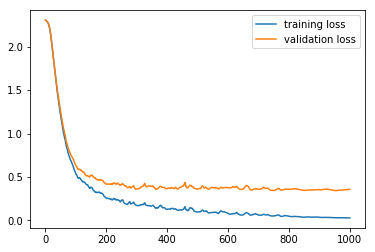

Early stopping: validation loss: 3.429e-01,  was lowest after 954 iterations
Accuracy: training 9.960e-01, validation 9.030e-01, testing 9.017e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.639e+01, training loss is 5.40e-01, and validation loss is 6.35e-01

After 200 iterations, ||theta|| 2.312e+01, training loss is 2.57e-01, and validation loss is 4.18e-01

After 300 iterations, ||theta|| 2.689e+01, training loss is 1.73e-01, and validation loss is 3.62e-01

After 400 iterations, ||theta|| 2.964e+01, training loss is 1.29e-01, and validation loss is 3.67e-01

After 500 iterations, ||theta|| 3.181e+01, training loss is 9.68e-02, and validation loss is 3.62e-01

After 600 iterations, ||theta|| 3.334e+01, training loss is 8.13e-02, and validation loss is 3.78e-01

After 700 iterations, ||theta|| 3.456e+01, training loss is 6.22e-02, and validation loss is 3.59e-01

After 800 

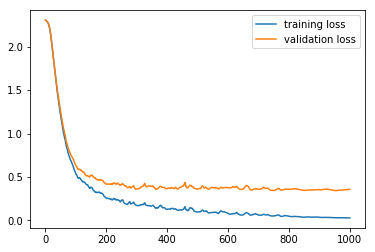

Accuracy: training 9.960e-01, validation 9.010e-01, testing 8.969e-01
Gradient test passed
After 0 iterations, ||theta|| 8.155e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.845e+01, training loss is 3.39e-01, and validation loss is 4.27e-01

After 200 iterations, ||theta|| 2.361e+01, training loss is 1.41e-01, and validation loss is 3.04e-01

After 300 iterations, ||theta|| 2.661e+01, training loss is 8.42e-02, and validation loss is 2.90e-01

After 400 iterations, ||theta|| 2.879e+01, training loss is 5.31e-02, and validation loss is 2.87e-01

After 500 iterations, ||theta|| 3.020e+01, training loss is 2.70e-02, and validation loss is 2.71e-01

After 600 iterations, ||theta|| 3.108e+01, training loss is 1.68e-02, and validation loss is 2.73e-01

After 700 iterations, ||theta|| 3.165e+01, training loss is 1.02e-02, and validation loss is 2.77e-01

After 800 iterations, ||theta|| 3.208e+01, training loss is 7.64e-03, and validation lo

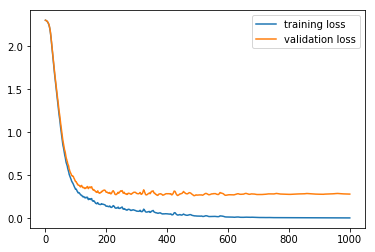

Early stopping: validation loss: 2.639e-01,  was lowest after 489 iterations
Accuracy: training 9.980e-01, validation 9.350e-01, testing 9.158e-01
Gradient test passed
After 0 iterations, ||theta|| 8.155e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.845e+01, training loss is 3.39e-01, and validation loss is 4.27e-01

After 200 iterations, ||theta|| 2.361e+01, training loss is 1.41e-01, and validation loss is 3.04e-01

After 300 iterations, ||theta|| 2.661e+01, training loss is 8.42e-02, and validation loss is 2.90e-01

After 400 iterations, ||theta|| 2.879e+01, training loss is 5.31e-02, and validation loss is 2.87e-01

After 500 iterations, ||theta|| 3.020e+01, training loss is 2.70e-02, and validation loss is 2.71e-01

After 600 iterations, ||theta|| 3.108e+01, training loss is 1.68e-02, and validation loss is 2.73e-01

After 700 iterations, ||theta|| 3.165e+01, training loss is 1.02e-02, and validation loss is 2.77e-01

After 800 

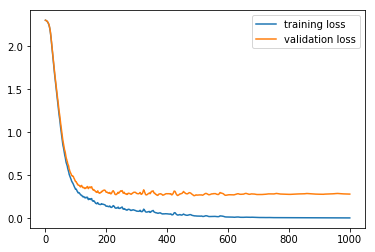

Accuracy: training 1.000e+00, validation 9.300e-01, testing 9.254e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.077e+01, training loss is 2.91e-01, and validation loss is 3.78e-01

After 200 iterations, ||theta|| 2.527e+01, training loss is 1.33e-01, and validation loss is 2.85e-01

After 300 iterations, ||theta|| 2.820e+01, training loss is 8.75e-02, and validation loss is 2.90e-01

After 400 iterations, ||theta|| 3.026e+01, training loss is 5.05e-02, and validation loss is 2.85e-01

After 500 iterations, ||theta|| 3.163e+01, training loss is 3.61e-02, and validation loss is 2.88e-01

After 600 iterations, ||theta|| 3.256e+01, training loss is 1.75e-02, and validation loss is 2.81e-01

After 700 iterations, ||theta|| 3.311e+01, training loss is 8.07e-03, and validation loss is 2.75e-01

After 800 iterations, ||theta|| 3.346e+01, training loss is 5.55e-03, and validation lo

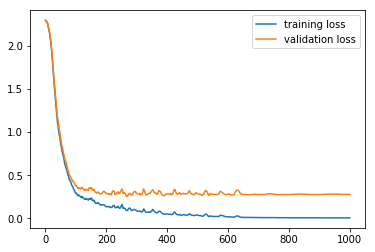

Early stopping: validation loss: 2.540e-01,  was lowest after 269 iterations
Accuracy: training 9.760e-01, validation 9.180e-01, testing 9.120e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.077e+01, training loss is 2.91e-01, and validation loss is 3.78e-01

After 200 iterations, ||theta|| 2.527e+01, training loss is 1.33e-01, and validation loss is 2.85e-01

After 300 iterations, ||theta|| 2.820e+01, training loss is 8.75e-02, and validation loss is 2.90e-01

After 400 iterations, ||theta|| 3.026e+01, training loss is 5.05e-02, and validation loss is 2.85e-01

After 500 iterations, ||theta|| 3.163e+01, training loss is 3.61e-02, and validation loss is 2.88e-01

After 600 iterations, ||theta|| 3.256e+01, training loss is 1.75e-02, and validation loss is 2.81e-01

After 700 iterations, ||theta|| 3.311e+01, training loss is 8.07e-03, and validation loss is 2.75e-01

After 800 

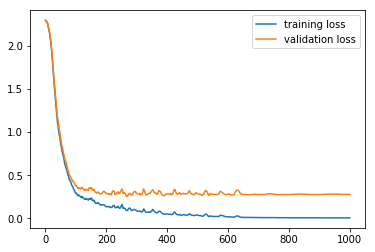

Accuracy: training 1.000e+00, validation 9.300e-01, testing 9.246e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.399e+01, training loss is 3.38e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.831e+01, training loss is 1.39e-01, and validation loss is 2.99e-01

After 300 iterations, ||theta|| 3.092e+01, training loss is 8.99e-02, and validation loss is 3.10e-01

After 400 iterations, ||theta|| 3.284e+01, training loss is 5.77e-02, and validation loss is 3.16e-01

After 500 iterations, ||theta|| 3.414e+01, training loss is 2.89e-02, and validation loss is 2.95e-01

After 600 iterations, ||theta|| 3.509e+01, training loss is 1.83e-02, and validation loss is 3.16e-01

After 700 iterations, ||theta|| 3.563e+01, training loss is 1.12e-02, and validation loss is 3.26e-01

After 800 iterations, ||theta|| 3.601e+01, training loss is 6.66e-03, and validation lo

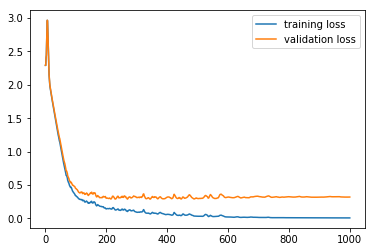

Early stopping: validation loss: 2.861e-01,  was lowest after 344 iterations
Accuracy: training 9.870e-01, validation 9.120e-01, testing 9.131e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.399e+01, training loss is 3.38e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.831e+01, training loss is 1.39e-01, and validation loss is 2.99e-01

After 300 iterations, ||theta|| 3.092e+01, training loss is 8.99e-02, and validation loss is 3.10e-01

After 400 iterations, ||theta|| 3.284e+01, training loss is 5.77e-02, and validation loss is 3.16e-01

After 500 iterations, ||theta|| 3.414e+01, training loss is 2.89e-02, and validation loss is 2.95e-01

After 600 iterations, ||theta|| 3.509e+01, training loss is 1.83e-02, and validation loss is 3.16e-01

After 700 iterations, ||theta|| 3.563e+01, training loss is 1.12e-02, and validation loss is 3.26e-01

After 800 

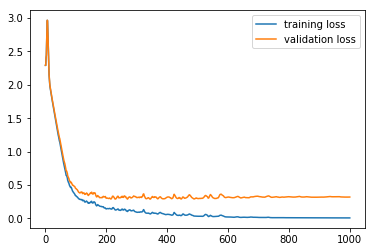

Accuracy: training 1.000e+00, validation 9.280e-01, testing 9.210e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.29e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.720e+01, training loss is 3.72e-01, and validation loss is 4.56e-01

After 200 iterations, ||theta|| 3.136e+01, training loss is 1.61e-01, and validation loss is 3.00e-01

After 300 iterations, ||theta|| 3.397e+01, training loss is 9.28e-02, and validation loss is 3.01e-01

After 400 iterations, ||theta|| 3.590e+01, training loss is 6.35e-02, and validation loss is 3.48e-01

After 500 iterations, ||theta|| 3.716e+01, training loss is 3.19e-02, and validation loss is 3.19e-01

After 600 iterations, ||theta|| 3.801e+01, training loss is 2.04e-02, and validation loss is 3.44e-01

After 700 iterations, ||theta|| 3.856e+01, training loss is 1.02e-02, and validation loss is 3.41e-01

After 800 iterations, ||theta|| 3.887e+01, training loss is 6.36e-03, and validation lo

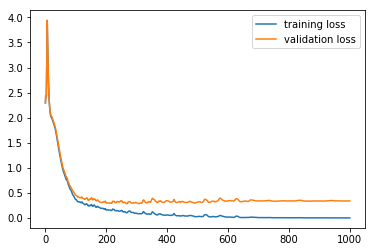

Early stopping: validation loss: 2.885e-01,  was lowest after 269 iterations
Accuracy: training 9.700e-01, validation 9.110e-01, testing 9.091e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.29e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.720e+01, training loss is 3.72e-01, and validation loss is 4.56e-01

After 200 iterations, ||theta|| 3.136e+01, training loss is 1.61e-01, and validation loss is 3.00e-01

After 300 iterations, ||theta|| 3.397e+01, training loss is 9.28e-02, and validation loss is 3.01e-01

After 400 iterations, ||theta|| 3.590e+01, training loss is 6.35e-02, and validation loss is 3.48e-01

After 500 iterations, ||theta|| 3.716e+01, training loss is 3.19e-02, and validation loss is 3.19e-01

After 600 iterations, ||theta|| 3.801e+01, training loss is 2.04e-02, and validation loss is 3.44e-01

After 700 iterations, ||theta|| 3.856e+01, training loss is 1.02e-02, and validation loss is 3.41e-01

After 800 

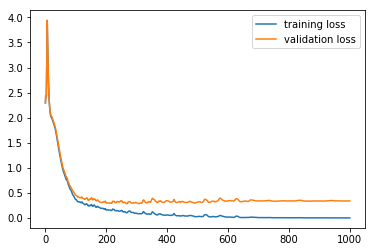

Accuracy: training 1.000e+00, validation 9.230e-01, testing 9.172e-01


In [515]:
n_hidden = [10,50,100,200,300]
n_iters = 1000
learning_rate=0.2
earlystopping=[True,False]
wd = 0
df5 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for nh in n_hidden:
    for el in earlystopping:
        info=train(wd, nh, n_iters, learning_rate, 0.9, el, minibatch_size=10)
        loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
        df5=df5.append(loss_info,ignore_index=True) 

In [518]:
df5.index=['10_on','10_off','50_on','50_off','100_on','100_off','200_on','200_off','300_on','300_off']
print("The best performance is when using 100 hidden units and early stopping is on.")
df5

The best performance is when using 100 hidden units and early stopping is on.


loss_train  loss_valid  loss_test
10_on      0.031078    0.342888   0.357664
10_off     0.029501    0.357989   0.372058
50_on      0.028977    0.263903   0.294212
50_off     0.005364    0.282035   0.297399
100_on     0.090184    0.253990   0.298894
100_off    0.003760    0.277113   0.318276
200_on     0.063827    0.286145   0.315128
200_off    0.003890    0.317051   0.353517
300_on     0.107780    0.288532   0.317306
300_off    0.003652    0.342651   0.382134

In [521]:
print('Part3 Q3 Testing: Here we use model selection to find out the best parameters. First, let us take a look at Classical Momentum. We apply the best valid performance parameters given by part3: learning_rate=1.0 and momentum_mul=0.5.')

Part3 Q3 Testing: Here we use model selection to find out the best parameters. First, let us take a look at Classical Momentum. We apply the best valid performance parameters given by part3: learning_rate=1.0 and momentum_mul=0.5.


Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.732e+01, training loss is 4.93e-01, and validation loss is 5.83e-01

After 200 iterations, ||theta|| 2.367e+01, training loss is 2.69e-01, and validation loss is 4.17e-01

After 300 iterations, ||theta|| 2.733e+01, training loss is 2.20e-01, and validation loss is 4.00e-01

After 400 iterations, ||theta|| 2.993e+01, training loss is 1.54e-01, and validation loss is 3.83e-01

After 500 iterations, ||theta|| 3.185e+01, training loss is 1.77e-01, and validation loss is 4.56e-01

After 600 iterations, ||theta|| 3.444e+01, training loss is 1.47e-01, and validation loss is 4.09e-01

After 700 iterations, ||theta|| 3.575e+01, training loss is 6.65e-02, and validation loss is 3.68e-01

After 800 iterations, ||theta|| 3.666e+01, training loss is 4.67e-02, and validation loss is 3.44e-01

After 900 iterations, ||theta|| 3.753e+01, training lo

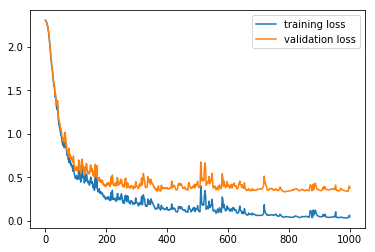

Early stopping: validation loss: 3.336e-01,  was lowest after 786 iterations
Accuracy: training 9.930e-01, validation 8.950e-01, testing 9.013e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.931e+01, training loss is 4.04e-01, and validation loss is 4.73e-01

After 200 iterations, ||theta|| 2.425e+01, training loss is 2.24e-01, and validation loss is 3.84e-01

After 300 iterations, ||theta|| 2.752e+01, training loss is 8.89e-02, and validation loss is 2.97e-01

After 400 iterations, ||theta|| 2.960e+01, training loss is 4.97e-02, and validation loss is 2.71e-01

After 500 iterations, ||theta|| 3.105e+01, training loss is 2.96e-02, and validation loss is 2.72e-01

After 600 iterations, ||theta|| 3.187e+01, training loss is 1.65e-02, and validation loss is 2.76e-01

After 700 iterations, ||theta|| 3.241e+01, training loss is 1.07e-02, and validation loss is 2.79e-01

After 800 

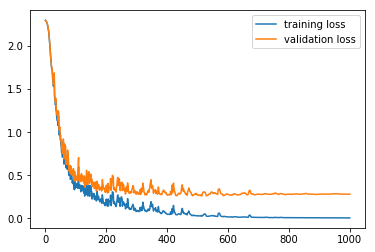

Early stopping: validation loss: 2.603e-01,  was lowest after 514 iterations
Accuracy: training 9.970e-01, validation 9.290e-01, testing 9.241e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.150e+01, training loss is 3.97e-01, and validation loss is 4.66e-01

After 200 iterations, ||theta|| 2.599e+01, training loss is 2.66e-01, and validation loss is 4.36e-01

After 300 iterations, ||theta|| 2.935e+01, training loss is 9.46e-02, and validation loss is 3.00e-01

After 400 iterations, ||theta|| 3.165e+01, training loss is 5.32e-02, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 3.300e+01, training loss is 3.37e-02, and validation loss is 3.10e-01

After 600 iterations, ||theta|| 3.377e+01, training loss is 1.68e-02, and validation loss is 3.09e-01

After 700 iterations, ||theta|| 3.428e+01, training loss is 9.19e-03, and validation loss is 2.97e-01

After 800 

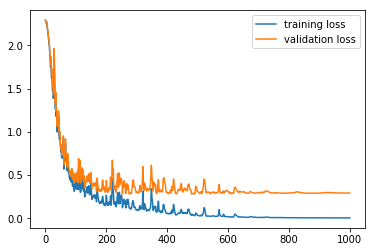

Early stopping: validation loss: 2.795e-01,  was lowest after 486 iterations
Accuracy: training 9.910e-01, validation 9.200e-01, testing 9.123e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.473e+01, training loss is 5.46e-01, and validation loss is 6.53e-01

After 200 iterations, ||theta|| 2.903e+01, training loss is 2.68e-01, and validation loss is 4.42e-01

After 300 iterations, ||theta|| 3.199e+01, training loss is 1.34e-01, and validation loss is 3.58e-01

After 400 iterations, ||theta|| 3.383e+01, training loss is 7.24e-02, and validation loss is 3.44e-01

After 500 iterations, ||theta|| 3.560e+01, training loss is 4.36e-02, and validation loss is 3.58e-01

After 600 iterations, ||theta|| 3.646e+01, training loss is 2.27e-02, and validation loss is 3.44e-01

After 700 iterations, ||theta|| 3.702e+01, training loss is 1.66e-02, and validation loss is 3.57e-01

After 800 

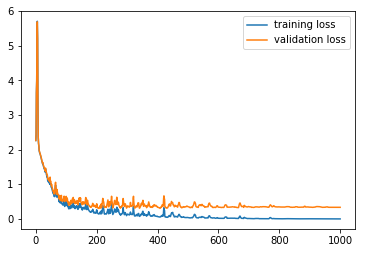

Early stopping: validation loss: 3.060e-01,  was lowest after 207 iterations
Accuracy: training 9.570e-01, validation 9.040e-01, testing 9.049e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.759e+01, training loss is 5.07e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 3.206e+01, training loss is 2.59e-01, and validation loss is 4.05e-01

After 300 iterations, ||theta|| 3.493e+01, training loss is 1.20e-01, and validation loss is 3.07e-01

After 400 iterations, ||theta|| 3.692e+01, training loss is 1.07e-01, and validation loss is 3.65e-01

After 500 iterations, ||theta|| 3.855e+01, training loss is 6.66e-02, and validation loss is 3.45e-01

After 600 iterations, ||theta|| 3.987e+01, training loss is 4.06e-02, and validation loss is 3.63e-01

After 700 iterations, ||theta|| 4.066e+01, training loss is 2.90e-02, and validation loss is 4.09e-01

After 800 

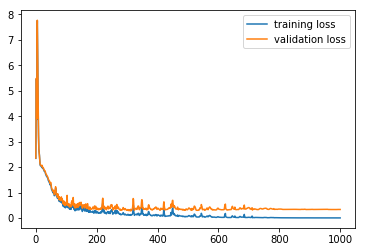

Early stopping: validation loss: 2.859e-01,  was lowest after 309 iterations
Accuracy: training 9.690e-01, validation 9.130e-01, testing 9.138e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.731e+01, training loss is 4.93e-01, and validation loss is 5.84e-01

After 200 iterations, ||theta|| 2.363e+01, training loss is 2.69e-01, and validation loss is 4.17e-01

After 300 iterations, ||theta|| 2.727e+01, training loss is 2.15e-01, and validation loss is 3.97e-01

After 400 iterations, ||theta|| 2.983e+01, training loss is 1.45e-01, and validation loss is 3.74e-01

After 500 iterations, ||theta|| 3.165e+01, training loss is 2.36e-01, and validation loss is 4.82e-01

After 600 iterations, ||theta|| 3.365e+01, training loss is 1.15e-01, and validation loss is 4.03e-01

After 700 iterations, ||theta|| 3.507e+01, training loss is 9.81e-02, and validation loss is 3.94e-01

After 800 

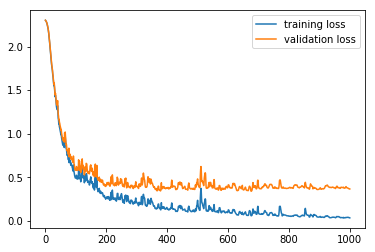

Early stopping: validation loss: 3.402e-01,  was lowest after 676 iterations
Accuracy: training 9.900e-01, validation 9.010e-01, testing 9.003e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.929e+01, training loss is 4.04e-01, and validation loss is 4.73e-01

After 200 iterations, ||theta|| 2.420e+01, training loss is 2.24e-01, and validation loss is 3.84e-01

After 300 iterations, ||theta|| 2.744e+01, training loss is 8.95e-02, and validation loss is 2.97e-01

After 400 iterations, ||theta|| 2.949e+01, training loss is 5.01e-02, and validation loss is 2.71e-01

After 500 iterations, ||theta|| 3.090e+01, training loss is 3.05e-02, and validation loss is 2.72e-01

After 600 iterations, ||theta|| 3.169e+01, training loss is 1.70e-02, and validation loss is 2.75e-01

After 700 iterations, ||theta|| 3.217e+01, training loss is 1.12e-02, and validation loss is 2.78e-01

After 800 

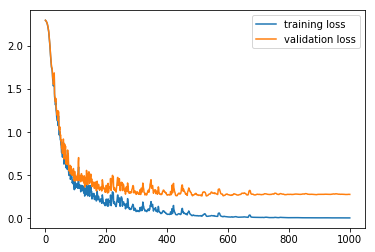

Early stopping: validation loss: 2.596e-01,  was lowest after 514 iterations
Accuracy: training 9.970e-01, validation 9.300e-01, testing 9.248e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.147e+01, training loss is 3.97e-01, and validation loss is 4.66e-01

After 200 iterations, ||theta|| 2.593e+01, training loss is 2.67e-01, and validation loss is 4.36e-01

After 300 iterations, ||theta|| 2.926e+01, training loss is 9.50e-02, and validation loss is 3.00e-01

After 400 iterations, ||theta|| 3.152e+01, training loss is 5.36e-02, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 3.282e+01, training loss is 3.39e-02, and validation loss is 3.08e-01

After 600 iterations, ||theta|| 3.354e+01, training loss is 1.72e-02, and validation loss is 3.08e-01

After 700 iterations, ||theta|| 3.400e+01, training loss is 9.70e-03, and validation loss is 2.96e-01

After 800 

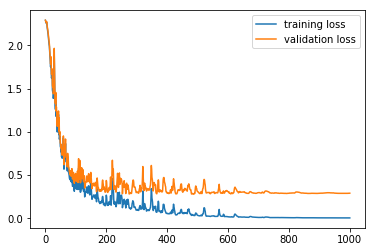

Early stopping: validation loss: 2.781e-01,  was lowest after 486 iterations
Accuracy: training 9.890e-01, validation 9.200e-01, testing 9.119e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.470e+01, training loss is 5.46e-01, and validation loss is 6.53e-01

After 200 iterations, ||theta|| 2.896e+01, training loss is 2.69e-01, and validation loss is 4.43e-01

After 300 iterations, ||theta|| 3.188e+01, training loss is 1.35e-01, and validation loss is 3.59e-01

After 400 iterations, ||theta|| 3.367e+01, training loss is 7.27e-02, and validation loss is 3.43e-01

After 500 iterations, ||theta|| 3.539e+01, training loss is 4.44e-02, and validation loss is 3.58e-01

After 600 iterations, ||theta|| 3.619e+01, training loss is 2.32e-02, and validation loss is 3.43e-01

After 700 iterations, ||theta|| 3.668e+01, training loss is 1.57e-02, and validation loss is 3.51e-01

After 800 

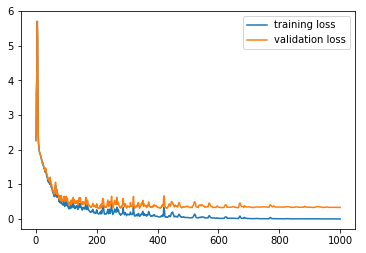

Early stopping: validation loss: 3.059e-01,  was lowest after 207 iterations
Accuracy: training 9.570e-01, validation 9.030e-01, testing 9.050e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.755e+01, training loss is 5.07e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 3.198e+01, training loss is 2.60e-01, and validation loss is 4.06e-01

After 300 iterations, ||theta|| 3.480e+01, training loss is 1.21e-01, and validation loss is 3.07e-01

After 400 iterations, ||theta|| 3.674e+01, training loss is 1.09e-01, and validation loss is 3.66e-01

After 500 iterations, ||theta|| 3.833e+01, training loss is 6.92e-02, and validation loss is 3.47e-01

After 600 iterations, ||theta|| 3.960e+01, training loss is 4.13e-02, and validation loss is 3.61e-01

After 700 iterations, ||theta|| 4.033e+01, training loss is 3.14e-02, and validation loss is 4.11e-01

After 800 

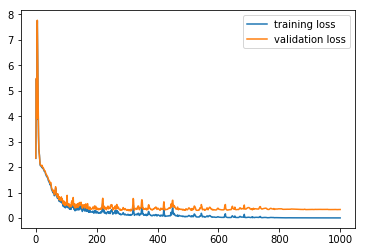

Early stopping: validation loss: 2.857e-01,  was lowest after 309 iterations
Accuracy: training 9.690e-01, validation 9.130e-01, testing 9.140e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.719e+01, training loss is 4.96e-01, and validation loss is 5.86e-01

After 200 iterations, ||theta|| 2.327e+01, training loss is 2.77e-01, and validation loss is 4.23e-01

After 300 iterations, ||theta|| 2.677e+01, training loss is 2.49e-01, and validation loss is 4.21e-01

After 400 iterations, ||theta|| 2.917e+01, training loss is 1.66e-01, and validation loss is 3.86e-01

After 500 iterations, ||theta|| 3.106e+01, training loss is 1.82e-01, and validation loss is 4.09e-01

After 600 iterations, ||theta|| 3.238e+01, training loss is 1.04e-01, and validation loss is 3.66e-01

After 700 iterations, ||theta|| 3.329e+01, training loss is 6.87e-02, and validation loss is 3.46e-01

After 800 

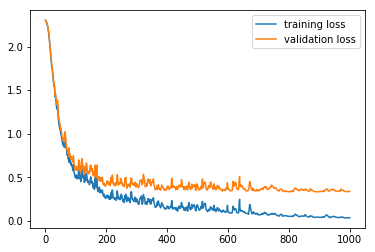

Early stopping: validation loss: 3.320e-01,  was lowest after 800 iterations
Accuracy: training 9.940e-01, validation 8.980e-01, testing 9.014e-01
Gradient test passed
After 0 iterations, ||theta|| 8.156e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.913e+01, training loss is 4.06e-01, and validation loss is 4.75e-01

After 200 iterations, ||theta|| 2.379e+01, training loss is 2.23e-01, and validation loss is 3.82e-01

After 300 iterations, ||theta|| 2.673e+01, training loss is 9.50e-02, and validation loss is 2.99e-01

After 400 iterations, ||theta|| 2.849e+01, training loss is 5.35e-02, and validation loss is 2.69e-01

After 500 iterations, ||theta|| 2.963e+01, training loss is 3.61e-02, and validation loss is 2.69e-01

After 600 iterations, ||theta|| 3.009e+01, training loss is 2.13e-02, and validation loss is 2.67e-01

After 700 iterations, ||theta|| 3.023e+01, training loss is 1.55e-02, and validation loss is 2.69e-01

After 800 

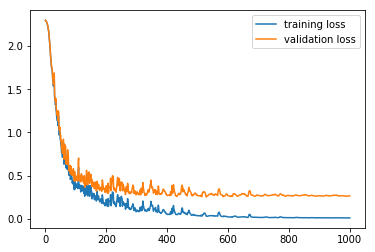

Early stopping: validation loss: 2.530e-01,  was lowest after 529 iterations
Accuracy: training 9.960e-01, validation 9.330e-01, testing 9.241e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.127e+01, training loss is 3.97e-01, and validation loss is 4.65e-01

After 200 iterations, ||theta|| 2.544e+01, training loss is 2.73e-01, and validation loss is 4.41e-01

After 300 iterations, ||theta|| 2.848e+01, training loss is 9.91e-02, and validation loss is 2.99e-01

After 400 iterations, ||theta|| 3.044e+01, training loss is 5.52e-02, and validation loss is 2.86e-01

After 500 iterations, ||theta|| 3.135e+01, training loss is 4.05e-02, and validation loss is 3.04e-01

After 600 iterations, ||theta|| 3.173e+01, training loss is 2.21e-02, and validation loss is 2.98e-01

After 700 iterations, ||theta|| 3.180e+01, training loss is 1.52e-02, and validation loss is 2.94e-01

After 800 

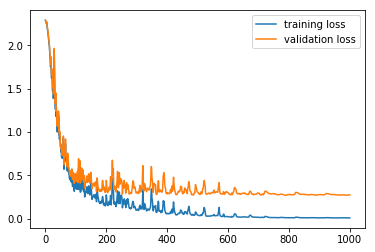

Early stopping: validation loss: 2.692e-01,  was lowest after 789 iterations
Accuracy: training 1.000e+00, validation 9.330e-01, testing 9.213e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.443e+01, training loss is 5.45e-01, and validation loss is 6.52e-01

After 200 iterations, ||theta|| 2.836e+01, training loss is 2.79e-01, and validation loss is 4.51e-01

After 300 iterations, ||theta|| 3.094e+01, training loss is 1.53e-01, and validation loss is 3.77e-01

After 400 iterations, ||theta|| 3.232e+01, training loss is 7.71e-02, and validation loss is 3.40e-01

After 500 iterations, ||theta|| 3.352e+01, training loss is 4.86e-02, and validation loss is 3.44e-01

After 600 iterations, ||theta|| 3.404e+01, training loss is 2.74e-02, and validation loss is 3.37e-01

After 700 iterations, ||theta|| 3.409e+01, training loss is 1.90e-02, and validation loss is 3.41e-01

After 800 

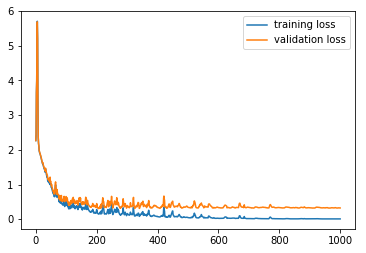

Early stopping: validation loss: 3.059e-01,  was lowest after 207 iterations
Accuracy: training 9.560e-01, validation 9.010e-01, testing 9.053e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.721e+01, training loss is 5.07e-01, and validation loss is 5.73e-01

After 200 iterations, ||theta|| 3.127e+01, training loss is 2.68e-01, and validation loss is 4.13e-01

After 300 iterations, ||theta|| 3.371e+01, training loss is 1.28e-01, and validation loss is 3.13e-01

After 400 iterations, ||theta|| 3.520e+01, training loss is 1.22e-01, and validation loss is 3.71e-01

After 500 iterations, ||theta|| 3.642e+01, training loss is 8.33e-02, and validation loss is 3.60e-01

After 600 iterations, ||theta|| 3.718e+01, training loss is 4.69e-02, and validation loss is 3.40e-01

After 700 iterations, ||theta|| 3.729e+01, training loss is 2.28e-02, and validation loss is 3.31e-01

After 800 

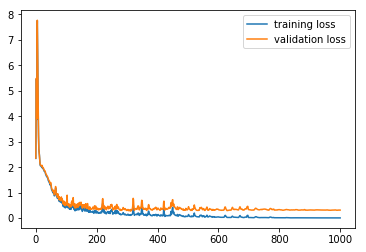

Early stopping: validation loss: 2.845e-01,  was lowest after 309 iterations
Accuracy: training 9.680e-01, validation 9.140e-01, testing 9.138e-01
Gradient test passed
After 0 iterations, ||theta|| 3.644e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.610e+01, training loss is 5.28e-01, and validation loss is 6.11e-01

After 200 iterations, ||theta|| 2.023e+01, training loss is 3.25e-01, and validation loss is 4.50e-01

After 300 iterations, ||theta|| 2.190e+01, training loss is 2.76e-01, and validation loss is 4.32e-01

After 400 iterations, ||theta|| 2.267e+01, training loss is 2.29e-01, and validation loss is 3.92e-01

After 500 iterations, ||theta|| 2.305e+01, training loss is 2.18e-01, and validation loss is 3.84e-01

After 600 iterations, ||theta|| 2.316e+01, training loss is 1.82e-01, and validation loss is 3.54e-01

After 700 iterations, ||theta|| 2.314e+01, training loss is 1.76e-01, and validation loss is 3.53e-01

After 800 

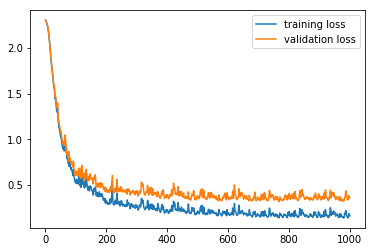

Early stopping: validation loss: 3.177e-01,  was lowest after 768 iterations
Accuracy: training 9.860e-01, validation 9.070e-01, testing 9.057e-01
Gradient test passed
After 0 iterations, ||theta|| 8.148e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.771e+01, training loss is 4.25e-01, and validation loss is 4.92e-01

After 200 iterations, ||theta|| 2.040e+01, training loss is 2.30e-01, and validation loss is 3.64e-01

After 300 iterations, ||theta|| 2.151e+01, training loss is 1.83e-01, and validation loss is 3.56e-01

After 400 iterations, ||theta|| 2.188e+01, training loss is 1.41e-01, and validation loss is 3.26e-01

After 500 iterations, ||theta|| 2.196e+01, training loss is 1.11e-01, and validation loss is 3.02e-01

After 600 iterations, ||theta|| 2.187e+01, training loss is 9.45e-02, and validation loss is 2.83e-01

After 700 iterations, ||theta|| 2.164e+01, training loss is 8.45e-02, and validation loss is 2.73e-01

After 800 

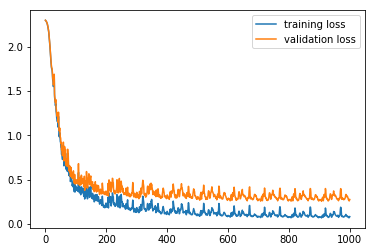

Early stopping: validation loss: 2.545e-01,  was lowest after 907 iterations
Accuracy: training 9.960e-01, validation 9.210e-01, testing 9.210e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 1.942e+01, training loss is 4.02e-01, and validation loss is 4.67e-01

After 200 iterations, ||theta|| 2.147e+01, training loss is 2.92e-01, and validation loss is 4.40e-01

After 300 iterations, ||theta|| 2.239e+01, training loss is 2.18e-01, and validation loss is 4.03e-01

After 400 iterations, ||theta|| 2.277e+01, training loss is 1.67e-01, and validation loss is 3.62e-01

After 500 iterations, ||theta|| 2.297e+01, training loss is 1.17e-01, and validation loss is 3.19e-01

After 600 iterations, ||theta|| 2.287e+01, training loss is 9.91e-02, and validation loss is 2.97e-01

After 700 iterations, ||theta|| 2.238e+01, training loss is 1.03e-01, and validation loss is 3.13e-01

After 800 

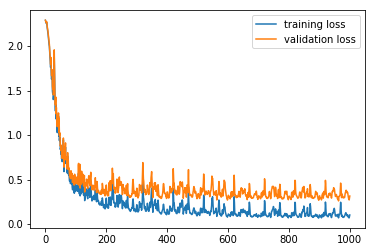

Early stopping: validation loss: 2.611e-01,  was lowest after 963 iterations
Accuracy: training 9.910e-01, validation 9.150e-01, testing 9.154e-01
Gradient test passed
After 0 iterations, ||theta|| 1.630e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.197e+01, training loss is 5.45e-01, and validation loss is 6.40e-01

After 200 iterations, ||theta|| 2.363e+01, training loss is 3.36e-01, and validation loss is 4.94e-01

After 300 iterations, ||theta|| 2.415e+01, training loss is 3.33e-01, and validation loss is 5.21e-01

After 400 iterations, ||theta|| 2.409e+01, training loss is 1.92e-01, and validation loss is 3.99e-01

After 500 iterations, ||theta|| 2.381e+01, training loss is 1.40e-01, and validation loss is 3.59e-01

After 600 iterations, ||theta|| 2.370e+01, training loss is 1.08e-01, and validation loss is 3.41e-01

After 700 iterations, ||theta|| 2.355e+01, training loss is 1.38e-01, and validation loss is 3.73e-01

After 800 

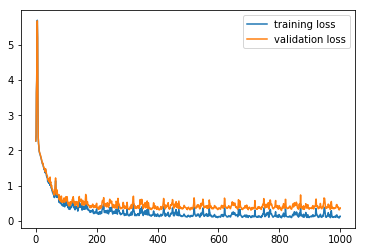

Early stopping: validation loss: 2.877e-01,  was lowest after 807 iterations
Accuracy: training 9.850e-01, validation 9.040e-01, testing 9.106e-01
Gradient test passed
After 0 iterations, ||theta|| 1.996e+01, training loss is 2.35e+00, and validation loss is 2.36e+00

After 100 iterations, ||theta|| 2.418e+01, training loss is 5.09e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 2.574e+01, training loss is 3.30e-01, and validation loss is 4.61e-01

After 300 iterations, ||theta|| 2.571e+01, training loss is 3.36e-01, and validation loss is 5.16e-01

After 400 iterations, ||theta|| 2.562e+01, training loss is 2.45e-01, and validation loss is 4.50e-01

After 500 iterations, ||theta|| 2.518e+01, training loss is 1.70e-01, and validation loss is 3.97e-01

After 600 iterations, ||theta|| 2.500e+01, training loss is 1.71e-01, and validation loss is 4.07e-01

After 700 iterations, ||theta|| 2.533e+01, training loss is 1.11e-01, and validation loss is 3.41e-01

After 800 

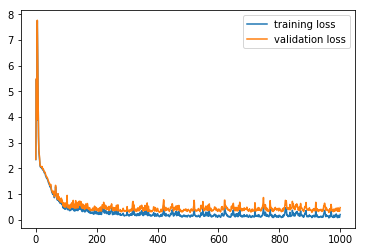

Early stopping: validation loss: 2.897e-01,  was lowest after 963 iterations
Accuracy: training 9.800e-01, validation 9.100e-01, testing 9.072e-01
Gradient test passed
After 0 iterations, ||theta|| 3.611e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.028e+01, training loss is 8.92e-01, and validation loss is 9.28e-01

After 200 iterations, ||theta|| 1.118e+01, training loss is 7.36e-01, and validation loss is 7.88e-01

After 300 iterations, ||theta|| 1.135e+01, training loss is 7.18e-01, and validation loss is 7.75e-01

After 400 iterations, ||theta|| 1.138e+01, training loss is 7.08e-01, and validation loss is 7.68e-01

After 500 iterations, ||theta|| 1.140e+01, training loss is 7.04e-01, and validation loss is 7.65e-01

After 600 iterations, ||theta|| 1.141e+01, training loss is 7.02e-01, and validation loss is 7.64e-01

After 700 iterations, ||theta|| 1.142e+01, training loss is 7.01e-01, and validation loss is 7.63e-01

After 800 

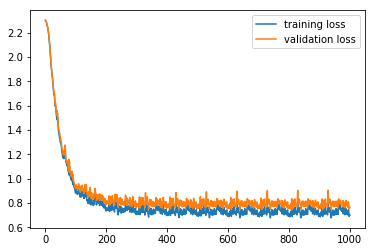

Early stopping: validation loss: 7.457e-01,  was lowest after 911 iterations
Accuracy: training 8.990e-01, validation 8.550e-01, testing 8.752e-01
Gradient test passed
After 0 iterations, ||theta|| 8.075e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.102e+01, training loss is 6.97e-01, and validation loss is 7.37e-01

After 200 iterations, ||theta|| 1.147e+01, training loss is 5.93e-01, and validation loss is 6.56e-01

After 300 iterations, ||theta|| 1.151e+01, training loss is 5.80e-01, and validation loss is 6.45e-01

After 400 iterations, ||theta|| 1.151e+01, training loss is 5.73e-01, and validation loss is 6.38e-01

After 500 iterations, ||theta|| 1.152e+01, training loss is 5.70e-01, and validation loss is 6.34e-01

After 600 iterations, ||theta|| 1.152e+01, training loss is 5.68e-01, and validation loss is 6.32e-01

After 700 iterations, ||theta|| 1.152e+01, training loss is 5.67e-01, and validation loss is 6.32e-01

After 800 

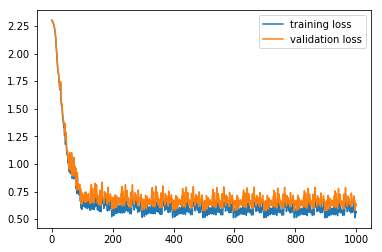

Early stopping: validation loss: 5.767e-01,  was lowest after 597 iterations
Accuracy: training 8.940e-01, validation 8.650e-01, testing 8.720e-01
Gradient test passed
After 0 iterations, ||theta|| 1.142e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.159e+01, training loss is 6.61e-01, and validation loss is 7.07e-01

After 200 iterations, ||theta|| 1.188e+01, training loss is 5.98e-01, and validation loss is 6.70e-01

After 300 iterations, ||theta|| 1.192e+01, training loss is 5.86e-01, and validation loss is 6.60e-01

After 400 iterations, ||theta|| 1.193e+01, training loss is 5.82e-01, and validation loss is 6.57e-01

After 500 iterations, ||theta|| 1.193e+01, training loss is 5.80e-01, and validation loss is 6.55e-01

After 600 iterations, ||theta|| 1.192e+01, training loss is 5.79e-01, and validation loss is 6.54e-01

After 700 iterations, ||theta|| 1.192e+01, training loss is 5.78e-01, and validation loss is 6.53e-01

After 800 

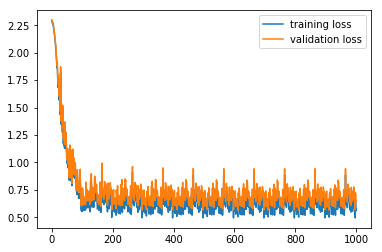

Early stopping: validation loss: 5.658e-01,  was lowest after 911 iterations
Accuracy: training 8.870e-01, validation 8.570e-01, testing 8.592e-01
Gradient test passed
After 0 iterations, ||theta|| 1.615e+01, training loss is 2.28e+00, and validation loss is 2.28e+00

After 100 iterations, ||theta|| 1.227e+01, training loss is 6.58e-01, and validation loss is 7.20e-01

After 200 iterations, ||theta|| 1.277e+01, training loss is 5.77e-01, and validation loss is 6.49e-01

After 300 iterations, ||theta|| 1.271e+01, training loss is 5.75e-01, and validation loss is 6.54e-01

After 400 iterations, ||theta|| 1.269e+01, training loss is 5.74e-01, and validation loss is 6.55e-01

After 500 iterations, ||theta|| 1.269e+01, training loss is 5.73e-01, and validation loss is 6.55e-01

After 600 iterations, ||theta|| 1.269e+01, training loss is 5.74e-01, and validation loss is 6.56e-01

After 700 iterations, ||theta|| 1.270e+01, training loss is 5.74e-01, and validation loss is 6.56e-01

After 800 

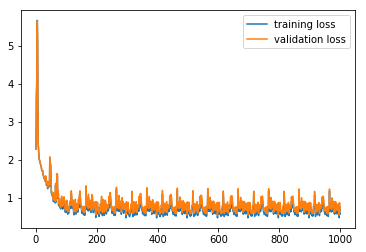

Early stopping: validation loss: 5.464e-01,  was lowest after 597 iterations
Accuracy: training 8.890e-01, validation 8.670e-01, testing 8.656e-01
Gradient test passed
After 0 iterations, ||theta|| 1.978e+01, training loss is 2.37e+00, and validation loss is 2.37e+00

After 100 iterations, ||theta|| 1.317e+01, training loss is 6.31e-01, and validation loss is 6.75e-01

After 200 iterations, ||theta|| 1.380e+01, training loss is 5.59e-01, and validation loss is 6.28e-01

After 300 iterations, ||theta|| 1.366e+01, training loss is 5.30e-01, and validation loss is 6.07e-01

After 400 iterations, ||theta|| 1.362e+01, training loss is 5.34e-01, and validation loss is 6.14e-01

After 500 iterations, ||theta|| 1.362e+01, training loss is 5.43e-01, and validation loss is 6.23e-01

After 600 iterations, ||theta|| 1.364e+01, training loss is 5.42e-01, and validation loss is 6.21e-01

After 700 iterations, ||theta|| 1.366e+01, training loss is 5.40e-01, and validation loss is 6.20e-01

After 800 

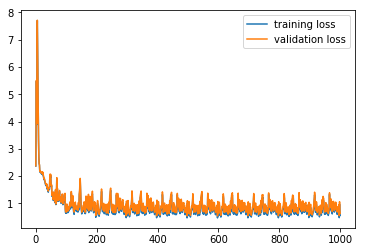

Early stopping: validation loss: 5.349e-01,  was lowest after 497 iterations
Accuracy: training 8.890e-01, validation 8.650e-01, testing 8.586e-01
Gradient test passed
After 0 iterations, ||theta|| 3.283e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 100 iterations, ||theta|| 1.169e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 200 iterations, ||theta|| 1.211e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 300 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 400 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 500 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 600 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 700 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 800 

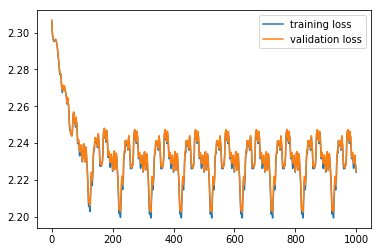

Early stopping: validation loss: 2.203e+00,  was lowest after 925 iterations
Accuracy: training 2.000e-01, validation 1.980e-01, testing 2.032e-01
Gradient test passed
After 0 iterations, ||theta|| 7.341e+00, training loss is 2.33e+00, and validation loss is 2.33e+00

After 100 iterations, ||theta|| 1.442e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.469e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 300 iterations, ||theta|| 1.475e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 400 iterations, ||theta|| 1.478e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 500 iterations, ||theta|| 1.480e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 600 iterations, ||theta|| 1.481e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 700 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 800 

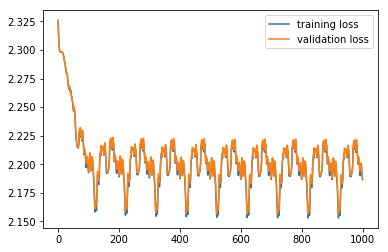

Early stopping: validation loss: 2.156e+00,  was lowest after 921 iterations
Accuracy: training 2.140e-01, validation 2.150e-01, testing 2.218e-01
Gradient test passed
After 0 iterations, ||theta|| 1.038e+01, training loss is 2.34e+00, and validation loss is 2.34e+00

After 100 iterations, ||theta|| 1.490e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.525e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 300 iterations, ||theta|| 1.534e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 400 iterations, ||theta|| 1.539e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 500 iterations, ||theta|| 1.542e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 600 iterations, ||theta|| 1.544e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 700 iterations, ||theta|| 1.545e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 800 

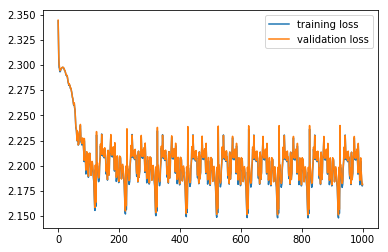

Early stopping: validation loss: 2.151e+00,  was lowest after 921 iterations
Accuracy: training 2.020e-01, validation 2.060e-01, testing 2.080e-01
Gradient test passed
After 0 iterations, ||theta|| 1.469e+01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 1.501e+00, training loss is 2.82e+00, and validation loss is 2.82e+00

After 200 iterations, ||theta|| 3.624e+00, training loss is 2.77e+00, and validation loss is 2.76e+00

After 300 iterations, ||theta|| 2.715e+00, training loss is 2.58e+00, and validation loss is 2.57e+00

After 400 iterations, ||theta|| 2.763e+00, training loss is 3.10e+00, and validation loss is 3.10e+00

After 500 iterations, ||theta|| 2.739e+00, training loss is 2.45e+00, and validation loss is 2.45e+00

After 600 iterations, ||theta|| 2.778e+00, training loss is 3.17e+00, and validation loss is 3.17e+00

After 700 iterations, ||theta|| 2.160e+00, training loss is 2.59e+00, and validation loss is 2.59e+00

After 800 

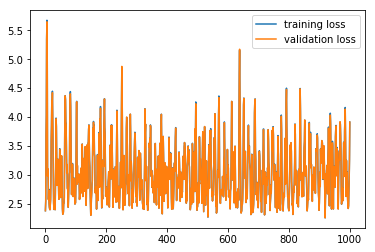

Early stopping: validation loss: 2.257e+00,  was lowest after 919 iterations
Accuracy: training 1.850e-01, validation 1.840e-01, testing 1.854e-01
Gradient test passed
After 0 iterations, ||theta|| 1.799e+01, training loss is 2.51e+00, and validation loss is 2.52e+00

After 100 iterations, ||theta|| 4.187e+00, training loss is 3.14e+00, and validation loss is 3.12e+00

After 200 iterations, ||theta|| 5.560e+00, training loss is 4.97e+00, and validation loss is 4.97e+00

After 300 iterations, ||theta|| 4.619e+00, training loss is 3.28e+00, and validation loss is 3.28e+00

After 400 iterations, ||theta|| 5.277e+00, training loss is 3.51e+00, and validation loss is 3.48e+00

After 500 iterations, ||theta|| 4.582e+00, training loss is 2.91e+00, and validation loss is 2.91e+00

After 600 iterations, ||theta|| 4.388e+00, training loss is 3.51e+00, and validation loss is 3.50e+00

After 700 iterations, ||theta|| 4.144e+00, training loss is 3.40e+00, and validation loss is 3.38e+00

After 800 

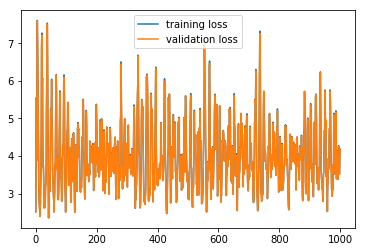

Early stopping: validation loss: 2.350e+00,  was lowest after 42 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.097e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.459e-15, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 i

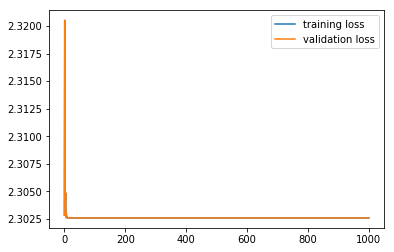

Early stopping: validation loss: 2.303e+00,  was lowest after 50 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.602e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 5.508e-15, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 2.401e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.979e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 2.076e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 2.401e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.979e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 2.076e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 i

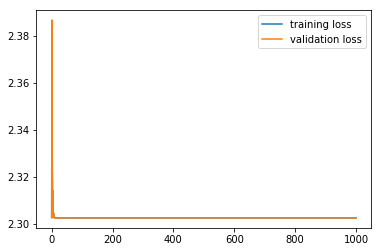

Early stopping: validation loss: 2.303e+00,  was lowest after 73 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.257e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 200 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 300 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 400 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 500 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 600 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 700 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 800 i

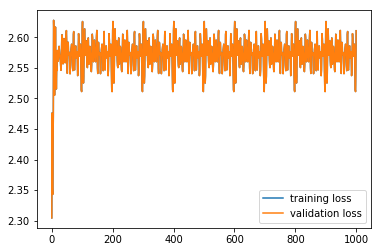

Early stopping: validation loss: 2.304e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 4.594e-01, training loss is 2.32e+00, and validation loss is 2.32e+00

After 100 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 200 iterations, ||theta|| 5.179e+00, training loss is 6.50e+00, and validation loss is 6.51e+00

After 300 iterations, ||theta|| 2.763e+00, training loss is 9.09e+00, and validation loss is 9.07e+00

After 400 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 500 iterations, ||theta|| 5.179e+00, training loss is 6.50e+00, and validation loss is 6.51e+00

After 600 iterations, ||theta|| 2.763e+00, training loss is 9.09e+00, and validation loss is 9.07e+00

After 700 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 800 it

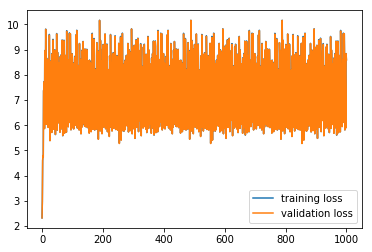

Early stopping: validation loss: 2.324e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 5.833e-01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 5.891e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 200 iterations, ||theta|| 5.139e+00, training loss is 1.01e+01, and validation loss is 1.01e+01

After 300 iterations, ||theta|| 6.419e+00, training loss is 1.28e+01, and validation loss is 1.27e+01

After 400 iterations, ||theta|| 5.892e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 500 iterations, ||theta|| 5.139e+00, training loss is 1.01e+01, and validation loss is 1.01e+01

After 600 iterations, ||theta|| 6.419e+00, training loss is 1.28e+01, and validation loss is 1.27e+01

After 700 iterations, ||theta|| 5.892e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 800 it

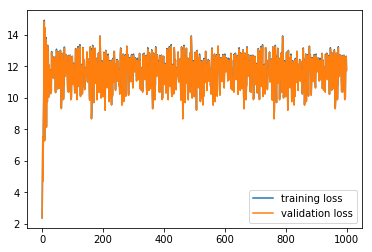

Early stopping: validation loss: 2.382e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.732e+01, training loss is 4.93e-01, and validation loss is 5.83e-01

After 200 iterations, ||theta|| 2.367e+01, training loss is 2.69e-01, and validation loss is 4.17e-01

After 300 iterations, ||theta|| 2.733e+01, training loss is 2.20e-01, and validation loss is 4.00e-01

After 400 iterations, ||theta|| 2.993e+01, training loss is 1.54e-01, and validation loss is 3.83e-01

After 500 iterations, ||theta|| 3.185e+01, training loss is 1.77e-01, and validation loss is 4.56e-01

After 600 iterations, ||theta|| 3.444e+01, training loss is 1.47e-01, and validation loss is 4.09e-01

After 700 iterations, ||theta|| 3.575e+01, training loss is 6.65e-02, and validation loss is 3.68e-01

After 800 it

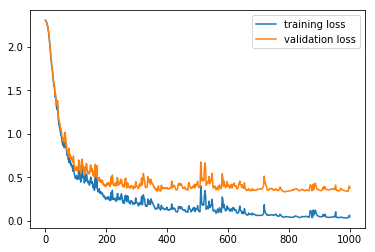

Accuracy: training 9.880e-01, validation 8.840e-01, testing 8.917e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.931e+01, training loss is 4.04e-01, and validation loss is 4.73e-01

After 200 iterations, ||theta|| 2.425e+01, training loss is 2.24e-01, and validation loss is 3.84e-01

After 300 iterations, ||theta|| 2.752e+01, training loss is 8.89e-02, and validation loss is 2.97e-01

After 400 iterations, ||theta|| 2.960e+01, training loss is 4.97e-02, and validation loss is 2.71e-01

After 500 iterations, ||theta|| 3.105e+01, training loss is 2.96e-02, and validation loss is 2.72e-01

After 600 iterations, ||theta|| 3.187e+01, training loss is 1.65e-02, and validation loss is 2.76e-01

After 700 iterations, ||theta|| 3.241e+01, training loss is 1.07e-02, and validation loss is 2.79e-01

After 800 iterations, ||theta|| 3.281e+01, training loss is 7.70e-03, and validation lo

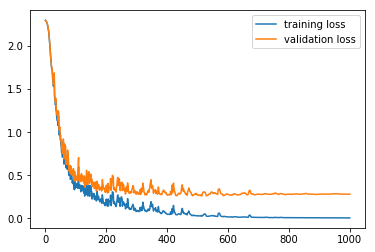

Accuracy: training 1.000e+00, validation 9.310e-01, testing 9.280e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.150e+01, training loss is 3.97e-01, and validation loss is 4.66e-01

After 200 iterations, ||theta|| 2.599e+01, training loss is 2.66e-01, and validation loss is 4.36e-01

After 300 iterations, ||theta|| 2.935e+01, training loss is 9.46e-02, and validation loss is 3.00e-01

After 400 iterations, ||theta|| 3.165e+01, training loss is 5.32e-02, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 3.300e+01, training loss is 3.37e-02, and validation loss is 3.10e-01

After 600 iterations, ||theta|| 3.377e+01, training loss is 1.68e-02, and validation loss is 3.09e-01

After 700 iterations, ||theta|| 3.428e+01, training loss is 9.19e-03, and validation loss is 2.97e-01

After 800 iterations, ||theta|| 3.462e+01, training loss is 5.60e-03, and validation lo

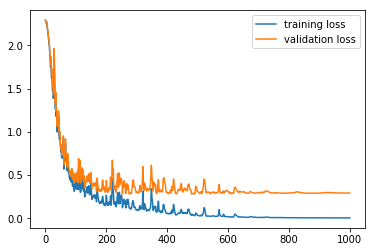

Accuracy: training 1.000e+00, validation 9.340e-01, testing 9.258e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.473e+01, training loss is 5.46e-01, and validation loss is 6.53e-01

After 200 iterations, ||theta|| 2.903e+01, training loss is 2.68e-01, and validation loss is 4.42e-01

After 300 iterations, ||theta|| 3.199e+01, training loss is 1.34e-01, and validation loss is 3.58e-01

After 400 iterations, ||theta|| 3.383e+01, training loss is 7.24e-02, and validation loss is 3.44e-01

After 500 iterations, ||theta|| 3.560e+01, training loss is 4.36e-02, and validation loss is 3.58e-01

After 600 iterations, ||theta|| 3.646e+01, training loss is 2.27e-02, and validation loss is 3.44e-01

After 700 iterations, ||theta|| 3.702e+01, training loss is 1.66e-02, and validation loss is 3.57e-01

After 800 iterations, ||theta|| 3.740e+01, training loss is 9.02e-03, and validation lo

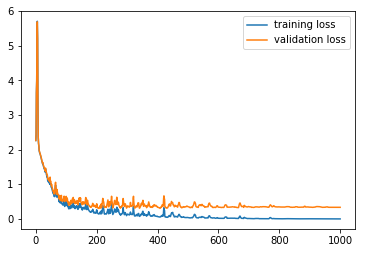

Accuracy: training 1.000e+00, validation 9.230e-01, testing 9.199e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.759e+01, training loss is 5.07e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 3.206e+01, training loss is 2.59e-01, and validation loss is 4.05e-01

After 300 iterations, ||theta|| 3.493e+01, training loss is 1.20e-01, and validation loss is 3.07e-01

After 400 iterations, ||theta|| 3.692e+01, training loss is 1.07e-01, and validation loss is 3.65e-01

After 500 iterations, ||theta|| 3.855e+01, training loss is 6.66e-02, and validation loss is 3.45e-01

After 600 iterations, ||theta|| 3.987e+01, training loss is 4.06e-02, and validation loss is 3.63e-01

After 700 iterations, ||theta|| 4.066e+01, training loss is 2.90e-02, and validation loss is 4.09e-01

After 800 iterations, ||theta|| 4.115e+01, training loss is 7.89e-03, and validation lo

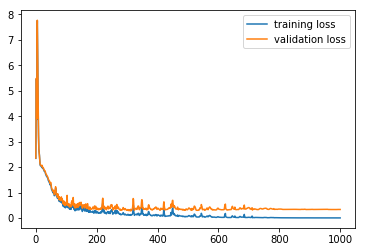

Accuracy: training 1.000e+00, validation 9.240e-01, testing 9.193e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.731e+01, training loss is 4.93e-01, and validation loss is 5.84e-01

After 200 iterations, ||theta|| 2.363e+01, training loss is 2.69e-01, and validation loss is 4.17e-01

After 300 iterations, ||theta|| 2.727e+01, training loss is 2.15e-01, and validation loss is 3.97e-01

After 400 iterations, ||theta|| 2.983e+01, training loss is 1.45e-01, and validation loss is 3.74e-01

After 500 iterations, ||theta|| 3.165e+01, training loss is 2.36e-01, and validation loss is 4.82e-01

After 600 iterations, ||theta|| 3.365e+01, training loss is 1.15e-01, and validation loss is 4.03e-01

After 700 iterations, ||theta|| 3.507e+01, training loss is 9.81e-02, and validation loss is 3.94e-01

After 800 iterations, ||theta|| 3.599e+01, training loss is 5.44e-02, and validation lo

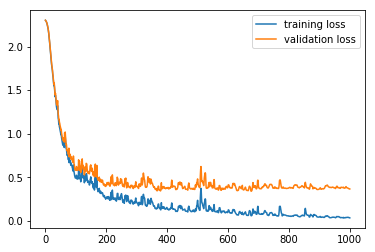

Accuracy: training 9.930e-01, validation 8.960e-01, testing 9.008e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.929e+01, training loss is 4.04e-01, and validation loss is 4.73e-01

After 200 iterations, ||theta|| 2.420e+01, training loss is 2.24e-01, and validation loss is 3.84e-01

After 300 iterations, ||theta|| 2.744e+01, training loss is 8.95e-02, and validation loss is 2.97e-01

After 400 iterations, ||theta|| 2.949e+01, training loss is 5.01e-02, and validation loss is 2.71e-01

After 500 iterations, ||theta|| 3.090e+01, training loss is 3.05e-02, and validation loss is 2.72e-01

After 600 iterations, ||theta|| 3.169e+01, training loss is 1.70e-02, and validation loss is 2.75e-01

After 700 iterations, ||theta|| 3.217e+01, training loss is 1.12e-02, and validation loss is 2.78e-01

After 800 iterations, ||theta|| 3.253e+01, training loss is 8.11e-03, and validation lo

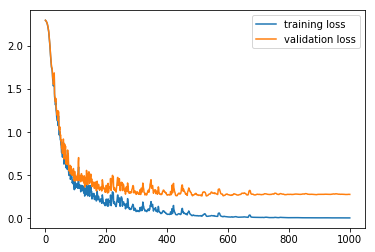

Accuracy: training 1.000e+00, validation 9.310e-01, testing 9.279e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.147e+01, training loss is 3.97e-01, and validation loss is 4.66e-01

After 200 iterations, ||theta|| 2.593e+01, training loss is 2.67e-01, and validation loss is 4.36e-01

After 300 iterations, ||theta|| 2.926e+01, training loss is 9.50e-02, and validation loss is 3.00e-01

After 400 iterations, ||theta|| 3.152e+01, training loss is 5.36e-02, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 3.282e+01, training loss is 3.39e-02, and validation loss is 3.08e-01

After 600 iterations, ||theta|| 3.354e+01, training loss is 1.72e-02, and validation loss is 3.08e-01

After 700 iterations, ||theta|| 3.400e+01, training loss is 9.70e-03, and validation loss is 2.96e-01

After 800 iterations, ||theta|| 3.428e+01, training loss is 5.95e-03, and validation lo

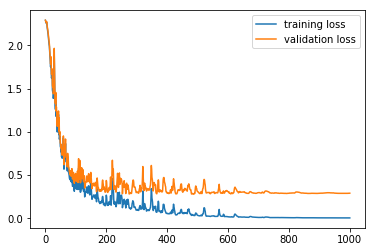

Accuracy: training 1.000e+00, validation 9.340e-01, testing 9.258e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.470e+01, training loss is 5.46e-01, and validation loss is 6.53e-01

After 200 iterations, ||theta|| 2.896e+01, training loss is 2.69e-01, and validation loss is 4.43e-01

After 300 iterations, ||theta|| 3.188e+01, training loss is 1.35e-01, and validation loss is 3.59e-01

After 400 iterations, ||theta|| 3.367e+01, training loss is 7.27e-02, and validation loss is 3.43e-01

After 500 iterations, ||theta|| 3.539e+01, training loss is 4.44e-02, and validation loss is 3.58e-01

After 600 iterations, ||theta|| 3.619e+01, training loss is 2.32e-02, and validation loss is 3.43e-01

After 700 iterations, ||theta|| 3.668e+01, training loss is 1.57e-02, and validation loss is 3.51e-01

After 800 iterations, ||theta|| 3.699e+01, training loss is 9.40e-03, and validation lo

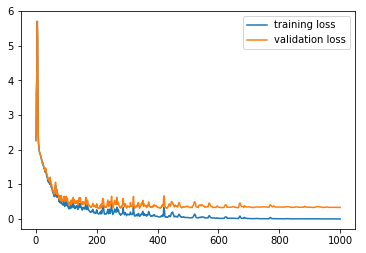

Accuracy: training 1.000e+00, validation 9.230e-01, testing 9.198e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.755e+01, training loss is 5.07e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 3.198e+01, training loss is 2.60e-01, and validation loss is 4.06e-01

After 300 iterations, ||theta|| 3.480e+01, training loss is 1.21e-01, and validation loss is 3.07e-01

After 400 iterations, ||theta|| 3.674e+01, training loss is 1.09e-01, and validation loss is 3.66e-01

After 500 iterations, ||theta|| 3.833e+01, training loss is 6.92e-02, and validation loss is 3.47e-01

After 600 iterations, ||theta|| 3.960e+01, training loss is 4.13e-02, and validation loss is 3.61e-01

After 700 iterations, ||theta|| 4.033e+01, training loss is 3.14e-02, and validation loss is 4.11e-01

After 800 iterations, ||theta|| 4.082e+01, training loss is 9.74e-03, and validation lo

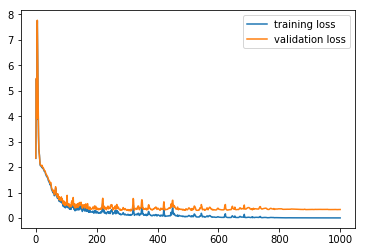

Accuracy: training 1.000e+00, validation 9.220e-01, testing 9.183e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.719e+01, training loss is 4.96e-01, and validation loss is 5.86e-01

After 200 iterations, ||theta|| 2.327e+01, training loss is 2.77e-01, and validation loss is 4.23e-01

After 300 iterations, ||theta|| 2.677e+01, training loss is 2.49e-01, and validation loss is 4.21e-01

After 400 iterations, ||theta|| 2.917e+01, training loss is 1.66e-01, and validation loss is 3.86e-01

After 500 iterations, ||theta|| 3.106e+01, training loss is 1.82e-01, and validation loss is 4.09e-01

After 600 iterations, ||theta|| 3.238e+01, training loss is 1.04e-01, and validation loss is 3.66e-01

After 700 iterations, ||theta|| 3.329e+01, training loss is 6.87e-02, and validation loss is 3.46e-01

After 800 iterations, ||theta|| 3.377e+01, training loss is 4.98e-02, and validation lo

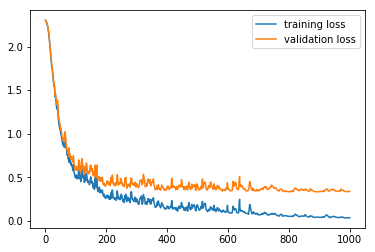

Accuracy: training 9.960e-01, validation 8.960e-01, testing 9.029e-01
Gradient test passed
After 0 iterations, ||theta|| 8.156e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.913e+01, training loss is 4.06e-01, and validation loss is 4.75e-01

After 200 iterations, ||theta|| 2.379e+01, training loss is 2.23e-01, and validation loss is 3.82e-01

After 300 iterations, ||theta|| 2.673e+01, training loss is 9.50e-02, and validation loss is 2.99e-01

After 400 iterations, ||theta|| 2.849e+01, training loss is 5.35e-02, and validation loss is 2.69e-01

After 500 iterations, ||theta|| 2.963e+01, training loss is 3.61e-02, and validation loss is 2.69e-01

After 600 iterations, ||theta|| 3.009e+01, training loss is 2.13e-02, and validation loss is 2.67e-01

After 700 iterations, ||theta|| 3.023e+01, training loss is 1.55e-02, and validation loss is 2.69e-01

After 800 iterations, ||theta|| 3.022e+01, training loss is 1.24e-02, and validation lo

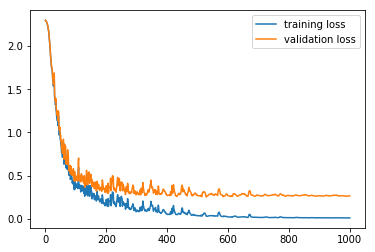

Accuracy: training 1.000e+00, validation 9.320e-01, testing 9.279e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.127e+01, training loss is 3.97e-01, and validation loss is 4.65e-01

After 200 iterations, ||theta|| 2.544e+01, training loss is 2.73e-01, and validation loss is 4.41e-01

After 300 iterations, ||theta|| 2.848e+01, training loss is 9.91e-02, and validation loss is 2.99e-01

After 400 iterations, ||theta|| 3.044e+01, training loss is 5.52e-02, and validation loss is 2.86e-01

After 500 iterations, ||theta|| 3.135e+01, training loss is 4.05e-02, and validation loss is 3.04e-01

After 600 iterations, ||theta|| 3.173e+01, training loss is 2.21e-02, and validation loss is 2.98e-01

After 700 iterations, ||theta|| 3.180e+01, training loss is 1.52e-02, and validation loss is 2.94e-01

After 800 iterations, ||theta|| 3.168e+01, training loss is 9.91e-03, and validation lo

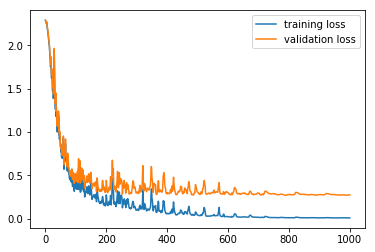

Accuracy: training 1.000e+00, validation 9.330e-01, testing 9.238e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.443e+01, training loss is 5.45e-01, and validation loss is 6.52e-01

After 200 iterations, ||theta|| 2.836e+01, training loss is 2.79e-01, and validation loss is 4.51e-01

After 300 iterations, ||theta|| 3.094e+01, training loss is 1.53e-01, and validation loss is 3.77e-01

After 400 iterations, ||theta|| 3.232e+01, training loss is 7.71e-02, and validation loss is 3.40e-01

After 500 iterations, ||theta|| 3.352e+01, training loss is 4.86e-02, and validation loss is 3.44e-01

After 600 iterations, ||theta|| 3.404e+01, training loss is 2.74e-02, and validation loss is 3.37e-01

After 700 iterations, ||theta|| 3.409e+01, training loss is 1.90e-02, and validation loss is 3.41e-01

After 800 iterations, ||theta|| 3.394e+01, training loss is 1.29e-02, and validation lo

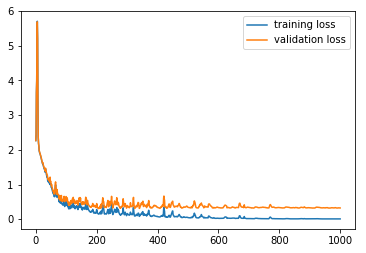

Accuracy: training 1.000e+00, validation 9.210e-01, testing 9.188e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.721e+01, training loss is 5.07e-01, and validation loss is 5.73e-01

After 200 iterations, ||theta|| 3.127e+01, training loss is 2.68e-01, and validation loss is 4.13e-01

After 300 iterations, ||theta|| 3.371e+01, training loss is 1.28e-01, and validation loss is 3.13e-01

After 400 iterations, ||theta|| 3.520e+01, training loss is 1.22e-01, and validation loss is 3.71e-01

After 500 iterations, ||theta|| 3.642e+01, training loss is 8.33e-02, and validation loss is 3.60e-01

After 600 iterations, ||theta|| 3.718e+01, training loss is 4.69e-02, and validation loss is 3.40e-01

After 700 iterations, ||theta|| 3.729e+01, training loss is 2.28e-02, and validation loss is 3.31e-01

After 800 iterations, ||theta|| 3.707e+01, training loss is 1.19e-02, and validation lo

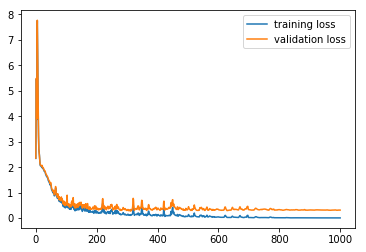

Accuracy: training 1.000e+00, validation 9.250e-01, testing 9.173e-01
Gradient test passed
After 0 iterations, ||theta|| 3.644e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.610e+01, training loss is 5.28e-01, and validation loss is 6.11e-01

After 200 iterations, ||theta|| 2.023e+01, training loss is 3.25e-01, and validation loss is 4.50e-01

After 300 iterations, ||theta|| 2.190e+01, training loss is 2.76e-01, and validation loss is 4.32e-01

After 400 iterations, ||theta|| 2.267e+01, training loss is 2.29e-01, and validation loss is 3.92e-01

After 500 iterations, ||theta|| 2.305e+01, training loss is 2.18e-01, and validation loss is 3.84e-01

After 600 iterations, ||theta|| 2.316e+01, training loss is 1.82e-01, and validation loss is 3.54e-01

After 700 iterations, ||theta|| 2.314e+01, training loss is 1.76e-01, and validation loss is 3.53e-01

After 800 iterations, ||theta|| 2.300e+01, training loss is 1.88e-01, and validation lo

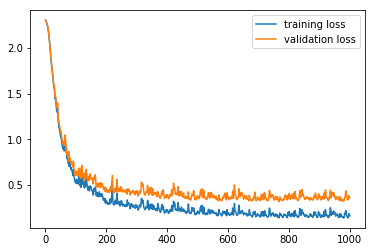

Accuracy: training 9.760e-01, validation 8.940e-01, testing 8.963e-01
Gradient test passed
After 0 iterations, ||theta|| 8.148e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.771e+01, training loss is 4.25e-01, and validation loss is 4.92e-01

After 200 iterations, ||theta|| 2.040e+01, training loss is 2.30e-01, and validation loss is 3.64e-01

After 300 iterations, ||theta|| 2.151e+01, training loss is 1.83e-01, and validation loss is 3.56e-01

After 400 iterations, ||theta|| 2.188e+01, training loss is 1.41e-01, and validation loss is 3.26e-01

After 500 iterations, ||theta|| 2.196e+01, training loss is 1.11e-01, and validation loss is 3.02e-01

After 600 iterations, ||theta|| 2.187e+01, training loss is 9.45e-02, and validation loss is 2.83e-01

After 700 iterations, ||theta|| 2.164e+01, training loss is 8.45e-02, and validation loss is 2.73e-01

After 800 iterations, ||theta|| 2.145e+01, training loss is 8.12e-02, and validation lo

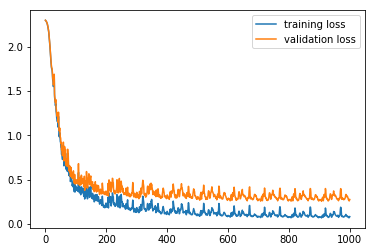

Accuracy: training 9.930e-01, validation 9.120e-01, testing 9.138e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 1.942e+01, training loss is 4.02e-01, and validation loss is 4.67e-01

After 200 iterations, ||theta|| 2.147e+01, training loss is 2.92e-01, and validation loss is 4.40e-01

After 300 iterations, ||theta|| 2.239e+01, training loss is 2.18e-01, and validation loss is 4.03e-01

After 400 iterations, ||theta|| 2.277e+01, training loss is 1.67e-01, and validation loss is 3.62e-01

After 500 iterations, ||theta|| 2.297e+01, training loss is 1.17e-01, and validation loss is 3.19e-01

After 600 iterations, ||theta|| 2.287e+01, training loss is 9.91e-02, and validation loss is 2.97e-01

After 700 iterations, ||theta|| 2.238e+01, training loss is 1.03e-01, and validation loss is 3.13e-01

After 800 iterations, ||theta|| 2.206e+01, training loss is 9.70e-02, and validation lo

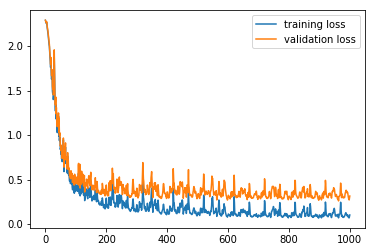

Accuracy: training 9.790e-01, validation 9.020e-01, testing 9.007e-01
Gradient test passed
After 0 iterations, ||theta|| 1.630e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.197e+01, training loss is 5.45e-01, and validation loss is 6.40e-01

After 200 iterations, ||theta|| 2.363e+01, training loss is 3.36e-01, and validation loss is 4.94e-01

After 300 iterations, ||theta|| 2.415e+01, training loss is 3.33e-01, and validation loss is 5.21e-01

After 400 iterations, ||theta|| 2.409e+01, training loss is 1.92e-01, and validation loss is 3.99e-01

After 500 iterations, ||theta|| 2.381e+01, training loss is 1.40e-01, and validation loss is 3.59e-01

After 600 iterations, ||theta|| 2.370e+01, training loss is 1.08e-01, and validation loss is 3.41e-01

After 700 iterations, ||theta|| 2.355e+01, training loss is 1.38e-01, and validation loss is 3.73e-01

After 800 iterations, ||theta|| 2.353e+01, training loss is 1.59e-01, and validation lo

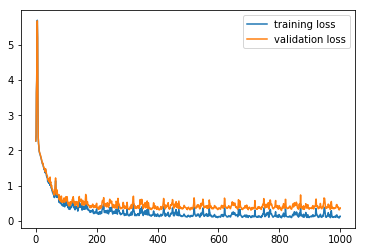

Accuracy: training 9.600e-01, validation 8.770e-01, testing 8.836e-01
Gradient test passed
After 0 iterations, ||theta|| 1.996e+01, training loss is 2.35e+00, and validation loss is 2.36e+00

After 100 iterations, ||theta|| 2.418e+01, training loss is 5.09e-01, and validation loss is 5.74e-01

After 200 iterations, ||theta|| 2.574e+01, training loss is 3.30e-01, and validation loss is 4.61e-01

After 300 iterations, ||theta|| 2.571e+01, training loss is 3.36e-01, and validation loss is 5.16e-01

After 400 iterations, ||theta|| 2.562e+01, training loss is 2.45e-01, and validation loss is 4.50e-01

After 500 iterations, ||theta|| 2.518e+01, training loss is 1.70e-01, and validation loss is 3.97e-01

After 600 iterations, ||theta|| 2.500e+01, training loss is 1.71e-01, and validation loss is 4.07e-01

After 700 iterations, ||theta|| 2.533e+01, training loss is 1.11e-01, and validation loss is 3.41e-01

After 800 iterations, ||theta|| 2.492e+01, training loss is 1.58e-01, and validation lo

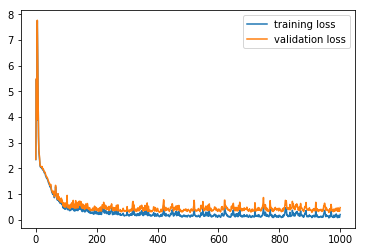

Accuracy: training 9.290e-01, validation 8.430e-01, testing 8.461e-01
Gradient test passed
After 0 iterations, ||theta|| 3.611e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.028e+01, training loss is 8.92e-01, and validation loss is 9.28e-01

After 200 iterations, ||theta|| 1.118e+01, training loss is 7.36e-01, and validation loss is 7.88e-01

After 300 iterations, ||theta|| 1.135e+01, training loss is 7.18e-01, and validation loss is 7.75e-01

After 400 iterations, ||theta|| 1.138e+01, training loss is 7.08e-01, and validation loss is 7.68e-01

After 500 iterations, ||theta|| 1.140e+01, training loss is 7.04e-01, and validation loss is 7.65e-01

After 600 iterations, ||theta|| 1.141e+01, training loss is 7.02e-01, and validation loss is 7.64e-01

After 700 iterations, ||theta|| 1.142e+01, training loss is 7.01e-01, and validation loss is 7.63e-01

After 800 iterations, ||theta|| 1.142e+01, training loss is 7.00e-01, and validation lo

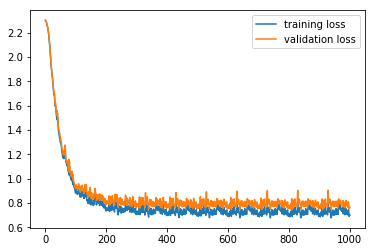

Accuracy: training 8.990e-01, validation 8.650e-01, testing 8.676e-01
Gradient test passed
After 0 iterations, ||theta|| 8.075e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.102e+01, training loss is 6.97e-01, and validation loss is 7.37e-01

After 200 iterations, ||theta|| 1.147e+01, training loss is 5.93e-01, and validation loss is 6.56e-01

After 300 iterations, ||theta|| 1.151e+01, training loss is 5.80e-01, and validation loss is 6.45e-01

After 400 iterations, ||theta|| 1.151e+01, training loss is 5.73e-01, and validation loss is 6.38e-01

After 500 iterations, ||theta|| 1.152e+01, training loss is 5.70e-01, and validation loss is 6.34e-01

After 600 iterations, ||theta|| 1.152e+01, training loss is 5.68e-01, and validation loss is 6.32e-01

After 700 iterations, ||theta|| 1.152e+01, training loss is 5.67e-01, and validation loss is 6.32e-01

After 800 iterations, ||theta|| 1.153e+01, training loss is 5.67e-01, and validation lo

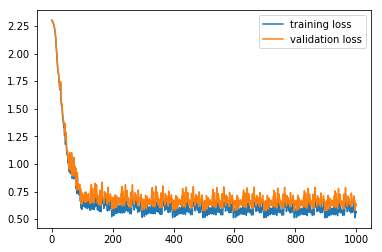

Accuracy: training 8.710e-01, validation 8.420e-01, testing 8.472e-01
Gradient test passed
After 0 iterations, ||theta|| 1.142e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.159e+01, training loss is 6.61e-01, and validation loss is 7.07e-01

After 200 iterations, ||theta|| 1.188e+01, training loss is 5.98e-01, and validation loss is 6.70e-01

After 300 iterations, ||theta|| 1.192e+01, training loss is 5.86e-01, and validation loss is 6.60e-01

After 400 iterations, ||theta|| 1.193e+01, training loss is 5.82e-01, and validation loss is 6.57e-01

After 500 iterations, ||theta|| 1.193e+01, training loss is 5.80e-01, and validation loss is 6.55e-01

After 600 iterations, ||theta|| 1.192e+01, training loss is 5.79e-01, and validation loss is 6.54e-01

After 700 iterations, ||theta|| 1.192e+01, training loss is 5.78e-01, and validation loss is 6.53e-01

After 800 iterations, ||theta|| 1.192e+01, training loss is 5.77e-01, and validation lo

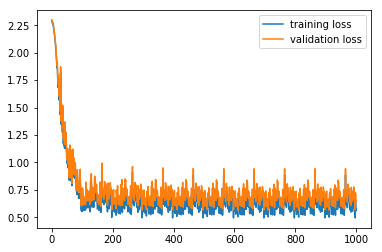

Accuracy: training 8.500e-01, validation 8.170e-01, testing 8.266e-01
Gradient test passed
After 0 iterations, ||theta|| 1.615e+01, training loss is 2.28e+00, and validation loss is 2.28e+00

After 100 iterations, ||theta|| 1.227e+01, training loss is 6.58e-01, and validation loss is 7.20e-01

After 200 iterations, ||theta|| 1.277e+01, training loss is 5.77e-01, and validation loss is 6.49e-01

After 300 iterations, ||theta|| 1.271e+01, training loss is 5.75e-01, and validation loss is 6.54e-01

After 400 iterations, ||theta|| 1.269e+01, training loss is 5.74e-01, and validation loss is 6.55e-01

After 500 iterations, ||theta|| 1.269e+01, training loss is 5.73e-01, and validation loss is 6.55e-01

After 600 iterations, ||theta|| 1.269e+01, training loss is 5.74e-01, and validation loss is 6.56e-01

After 700 iterations, ||theta|| 1.270e+01, training loss is 5.74e-01, and validation loss is 6.56e-01

After 800 iterations, ||theta|| 1.271e+01, training loss is 5.74e-01, and validation lo

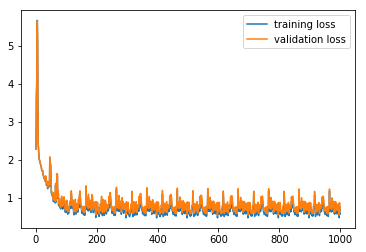

Accuracy: training 8.410e-01, validation 8.030e-01, testing 8.132e-01
Gradient test passed
After 0 iterations, ||theta|| 1.978e+01, training loss is 2.37e+00, and validation loss is 2.37e+00

After 100 iterations, ||theta|| 1.317e+01, training loss is 6.31e-01, and validation loss is 6.75e-01

After 200 iterations, ||theta|| 1.380e+01, training loss is 5.59e-01, and validation loss is 6.28e-01

After 300 iterations, ||theta|| 1.366e+01, training loss is 5.30e-01, and validation loss is 6.07e-01

After 400 iterations, ||theta|| 1.362e+01, training loss is 5.34e-01, and validation loss is 6.14e-01

After 500 iterations, ||theta|| 1.362e+01, training loss is 5.43e-01, and validation loss is 6.23e-01

After 600 iterations, ||theta|| 1.364e+01, training loss is 5.42e-01, and validation loss is 6.21e-01

After 700 iterations, ||theta|| 1.366e+01, training loss is 5.40e-01, and validation loss is 6.20e-01

After 800 iterations, ||theta|| 1.368e+01, training loss is 5.44e-01, and validation lo

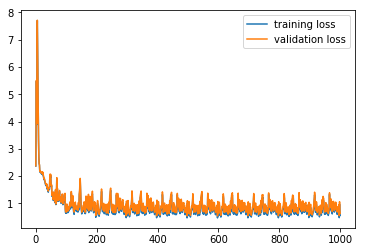

Accuracy: training 8.430e-01, validation 8.060e-01, testing 8.141e-01
Gradient test passed
After 0 iterations, ||theta|| 3.283e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 100 iterations, ||theta|| 1.169e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 200 iterations, ||theta|| 1.211e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 300 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 400 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 500 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 600 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 700 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 800 iterations, ||theta|| 1.215e+00, training loss is 2.22e+00, and validation lo

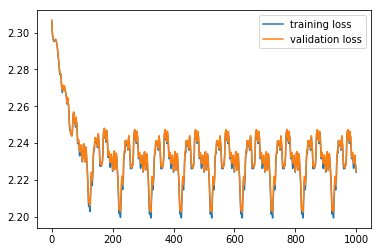

Accuracy: training 2.080e-01, validation 2.060e-01, testing 2.088e-01
Gradient test passed
After 0 iterations, ||theta|| 7.341e+00, training loss is 2.33e+00, and validation loss is 2.33e+00

After 100 iterations, ||theta|| 1.442e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.469e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 300 iterations, ||theta|| 1.475e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 400 iterations, ||theta|| 1.478e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 500 iterations, ||theta|| 1.480e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 600 iterations, ||theta|| 1.481e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 700 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 800 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation lo

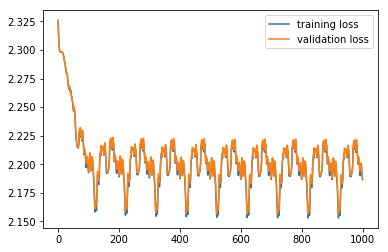

Accuracy: training 2.190e-01, validation 2.110e-01, testing 2.126e-01
Gradient test passed
After 0 iterations, ||theta|| 1.038e+01, training loss is 2.34e+00, and validation loss is 2.34e+00

After 100 iterations, ||theta|| 1.490e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.525e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 300 iterations, ||theta|| 1.534e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 400 iterations, ||theta|| 1.539e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 500 iterations, ||theta|| 1.542e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 600 iterations, ||theta|| 1.544e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 700 iterations, ||theta|| 1.545e+00, training loss is 2.18e+00, and validation loss is 2.18e+00

After 800 iterations, ||theta|| 1.546e+00, training loss is 2.18e+00, and validation lo

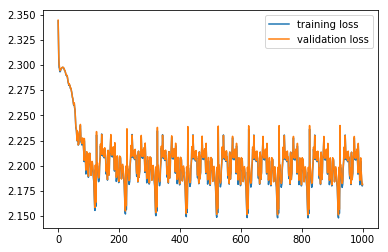

Accuracy: training 1.960e-01, validation 1.950e-01, testing 1.942e-01
Gradient test passed
After 0 iterations, ||theta|| 1.469e+01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 1.501e+00, training loss is 2.82e+00, and validation loss is 2.82e+00

After 200 iterations, ||theta|| 3.624e+00, training loss is 2.77e+00, and validation loss is 2.76e+00

After 300 iterations, ||theta|| 2.715e+00, training loss is 2.58e+00, and validation loss is 2.57e+00

After 400 iterations, ||theta|| 2.763e+00, training loss is 3.10e+00, and validation loss is 3.10e+00

After 500 iterations, ||theta|| 2.739e+00, training loss is 2.45e+00, and validation loss is 2.45e+00

After 600 iterations, ||theta|| 2.778e+00, training loss is 3.17e+00, and validation loss is 3.17e+00

After 700 iterations, ||theta|| 2.160e+00, training loss is 2.59e+00, and validation loss is 2.59e+00

After 800 iterations, ||theta|| 2.589e+00, training loss is 2.38e+00, and validation lo

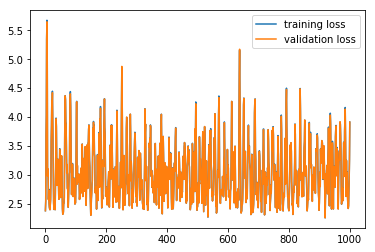

Accuracy: training 1.670e-01, validation 1.630e-01, testing 1.661e-01
Gradient test passed
After 0 iterations, ||theta|| 1.799e+01, training loss is 2.51e+00, and validation loss is 2.52e+00

After 100 iterations, ||theta|| 4.187e+00, training loss is 3.14e+00, and validation loss is 3.12e+00

After 200 iterations, ||theta|| 5.560e+00, training loss is 4.97e+00, and validation loss is 4.97e+00

After 300 iterations, ||theta|| 4.619e+00, training loss is 3.28e+00, and validation loss is 3.28e+00

After 400 iterations, ||theta|| 5.277e+00, training loss is 3.51e+00, and validation loss is 3.48e+00

After 500 iterations, ||theta|| 4.582e+00, training loss is 2.91e+00, and validation loss is 2.91e+00

After 600 iterations, ||theta|| 4.388e+00, training loss is 3.51e+00, and validation loss is 3.50e+00

After 700 iterations, ||theta|| 4.144e+00, training loss is 3.40e+00, and validation loss is 3.38e+00

After 800 iterations, ||theta|| 4.482e+00, training loss is 3.56e+00, and validation lo

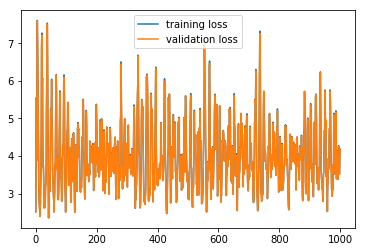

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.097e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 2.459e-15, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation lo

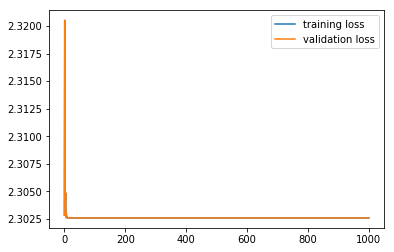

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.602e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 5.508e-15, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 2.401e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.979e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 2.076e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 2.401e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.979e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 2.076e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 iterations, ||theta|| 2.401e-16, training loss is 2.30e+00, and validation lo

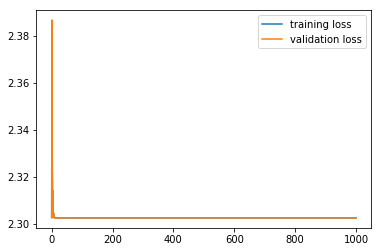

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.257e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 200 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 300 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 400 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 500 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 600 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 700 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation loss is 2.61e+00

After 800 iterations, ||theta|| 5.382e-01, training loss is 2.61e+00, and validation lo

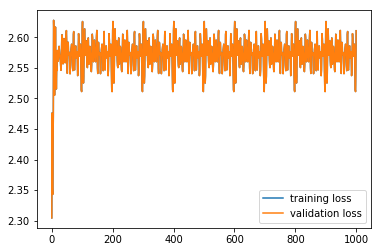

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 4.594e-01, training loss is 2.32e+00, and validation loss is 2.32e+00

After 100 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 200 iterations, ||theta|| 5.179e+00, training loss is 6.50e+00, and validation loss is 6.51e+00

After 300 iterations, ||theta|| 2.763e+00, training loss is 9.09e+00, and validation loss is 9.07e+00

After 400 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 500 iterations, ||theta|| 5.179e+00, training loss is 6.50e+00, and validation loss is 6.51e+00

After 600 iterations, ||theta|| 2.763e+00, training loss is 9.09e+00, and validation loss is 9.07e+00

After 700 iterations, ||theta|| 4.657e+00, training loss is 8.60e+00, and validation loss is 8.58e+00

After 800 iterations, ||theta|| 5.179e+00, training loss is 6.50e+00, and validation lo

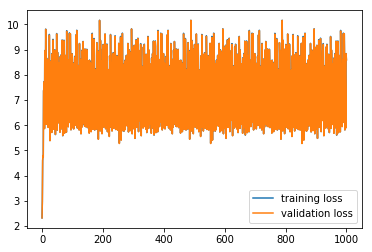

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 5.833e-01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 5.891e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 200 iterations, ||theta|| 5.139e+00, training loss is 1.01e+01, and validation loss is 1.01e+01

After 300 iterations, ||theta|| 6.419e+00, training loss is 1.28e+01, and validation loss is 1.27e+01

After 400 iterations, ||theta|| 5.892e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 500 iterations, ||theta|| 5.139e+00, training loss is 1.01e+01, and validation loss is 1.01e+01

After 600 iterations, ||theta|| 6.419e+00, training loss is 1.28e+01, and validation loss is 1.27e+01

After 700 iterations, ||theta|| 5.892e+00, training loss is 1.18e+01, and validation loss is 1.17e+01

After 800 iterations, ||theta|| 5.139e+00, training loss is 1.01e+01, and validation lo

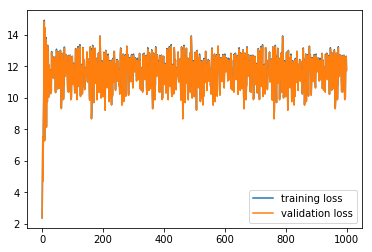

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01


In [522]:
n_hidden = [10,50,100,200,300]
n_iters = 1000
learning_rate=1.0
momentum_mul=0.5
weight_decay=[0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
earlystopping=[True,False]
df6 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for el in earlystopping:
    for wd in weight_decay:
        for nh in n_hidden:
            info=train(wd, nh, n_iters, learning_rate, momentum_mul, el, minibatch_size=10)
            loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
            df6=df6.append(loss_info,ignore_index=True) 

In [538]:
mean_off=df6[(df6.index>=35)]['loss_valid'].mean()
mean_on=df6[(df6.index<35)]['loss_valid'].mean()
mean_on,mean_off

(0.8972675081047231, 1.4773429935047302)

In [539]:
print("Firstly, we should build our model with early stopping.")

Firstly, we should build our model with early stopping.


In [541]:
mean_nh1=df6[(df6.index<7)]['loss_valid'].mean()
mean_nh2=df6[(df6.index>=7)&(df6.index<14)]['loss_valid'].mean()
mean_nh3=df6[(df6.index>=14)&(df6.index<21)]['loss_valid'].mean()
mean_nh4=df6[(df6.index>=21)&(df6.index<28)]['loss_valid'].mean()
mean_nh5=df6[(df6.index>=28)&(df6.index<35)]['loss_valid'].mean()
mean_nh1,mean_nh2,mean_nh3,mean_nh4,mean_nh5

(0.29499236936342094,
 0.2896927113649341,
 0.34579714772660963,
 1.242608524713313,
 2.3132467873553386)

In [542]:
print("Secondly, we should build our model with 50 hidden units")

Secondly, we should build our model with 50 hidden units


In [543]:
df6[(df6.index>=7)&(df6.index<14)]['loss_valid']

7     0.278039
8     0.305905
9     0.285666
10    0.331413
11    0.252576
12    0.268710
13    0.305540
Name: loss_valid, dtype: float64

In [545]:
print("Thirdly, we should build our model with weight decay le-1.")

Thirdly, we should build our model with weight decay le-1.


In [546]:
print('Then, let us take a look at Nesterov. We apply the best valid performance parameters given by part3: learning_rate=1.0 and momentum_mul=0.5.')

Then, let us take a look at Nesterov. We apply the best valid performance parameters given by part3: learning_rate=1.0 and momentum_mul=0.5.


Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.729e+01, training loss is 4.97e-01, and validation loss is 5.79e-01

After 200 iterations, ||theta|| 2.358e+01, training loss is 3.21e-01, and validation loss is 4.66e-01

After 300 iterations, ||theta|| 2.753e+01, training loss is 1.97e-01, and validation loss is 3.64e-01

After 400 iterations, ||theta|| 3.003e+01, training loss is 1.37e-01, and validation loss is 3.41e-01

After 500 iterations, ||theta|| 3.207e+01, training loss is 1.11e-01, and validation loss is 3.41e-01

After 600 iterations, ||theta|| 3.372e+01, training loss is 8.57e-02, and validation loss is 3.35e-01

After 700 iterations, ||theta|| 3.526e+01, training loss is 1.69e-01, and validation loss is 4.19e-01

After 800 iterations, ||theta|| 3.722e+01, training loss is 7.15e-02, and validation loss is 3.47e-01

After 900 iterations, ||theta|| 3.861e+01, training lo

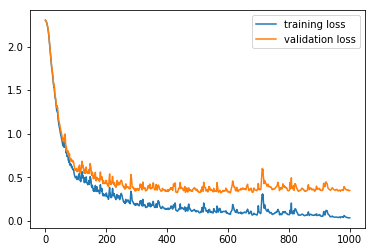

Early stopping: validation loss: 3.222e-01,  was lowest after 607 iterations
Accuracy: training 9.850e-01, validation 8.890e-01, testing 8.942e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.943e+01, training loss is 3.72e-01, and validation loss is 4.44e-01

After 200 iterations, ||theta|| 2.415e+01, training loss is 1.66e-01, and validation loss is 3.14e-01

After 300 iterations, ||theta|| 2.729e+01, training loss is 8.38e-02, and validation loss is 2.78e-01

After 400 iterations, ||theta|| 2.941e+01, training loss is 4.81e-02, and validation loss is 2.62e-01

After 500 iterations, ||theta|| 3.067e+01, training loss is 2.78e-02, and validation loss is 2.60e-01

After 600 iterations, ||theta|| 3.145e+01, training loss is 1.71e-02, and validation loss is 2.68e-01

After 700 iterations, ||theta|| 3.199e+01, training loss is 1.13e-02, and validation loss is 2.69e-01

After 800 

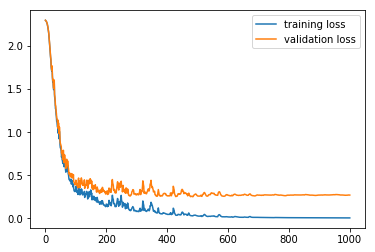

Early stopping: validation loss: 2.515e-01,  was lowest after 483 iterations
Accuracy: training 9.960e-01, validation 9.320e-01, testing 9.214e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.153e+01, training loss is 3.35e-01, and validation loss is 4.17e-01

After 200 iterations, ||theta|| 2.611e+01, training loss is 1.94e-01, and validation loss is 3.48e-01

After 300 iterations, ||theta|| 2.902e+01, training loss is 8.48e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 3.109e+01, training loss is 4.80e-02, and validation loss is 2.85e-01

After 500 iterations, ||theta|| 3.248e+01, training loss is 2.49e-02, and validation loss is 2.73e-01

After 600 iterations, ||theta|| 3.321e+01, training loss is 1.37e-02, and validation loss is 2.81e-01

After 700 iterations, ||theta|| 3.369e+01, training loss is 8.22e-03, and validation loss is 2.84e-01

After 800 

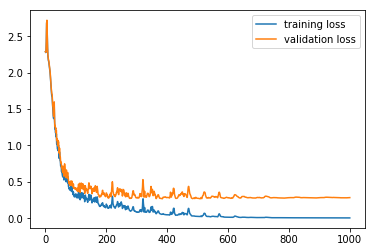

Early stopping: validation loss: 2.673e-01,  was lowest after 384 iterations
Accuracy: training 9.870e-01, validation 9.260e-01, testing 9.139e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.473e+01, training loss is 4.18e-01, and validation loss is 5.11e-01

After 200 iterations, ||theta|| 2.902e+01, training loss is 2.22e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 3.190e+01, training loss is 1.11e-01, and validation loss is 3.19e-01

After 400 iterations, ||theta|| 3.396e+01, training loss is 6.01e-02, and validation loss is 2.99e-01

After 500 iterations, ||theta|| 3.514e+01, training loss is 3.72e-02, and validation loss is 3.17e-01

After 600 iterations, ||theta|| 3.613e+01, training loss is 1.88e-02, and validation loss is 3.12e-01

After 700 iterations, ||theta|| 3.663e+01, training loss is 1.18e-02, and validation loss is 3.22e-01

After 800 

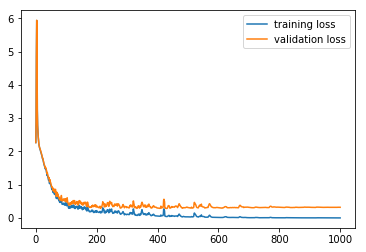

Early stopping: validation loss: 2.888e-01,  was lowest after 429 iterations
Accuracy: training 9.920e-01, validation 9.160e-01, testing 9.183e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.813e+01, training loss is 4.08e-01, and validation loss is 4.90e-01

After 200 iterations, ||theta|| 3.241e+01, training loss is 2.21e-01, and validation loss is 3.54e-01

After 300 iterations, ||theta|| 3.502e+01, training loss is 1.08e-01, and validation loss is 3.03e-01

After 400 iterations, ||theta|| 3.700e+01, training loss is 7.72e-02, and validation loss is 3.36e-01

After 500 iterations, ||theta|| 3.827e+01, training loss is 4.14e-02, and validation loss is 3.38e-01

After 600 iterations, ||theta|| 3.916e+01, training loss is 2.80e-02, and validation loss is 3.56e-01

After 700 iterations, ||theta|| 3.969e+01, training loss is 1.77e-02, and validation loss is 3.79e-01

After 800 

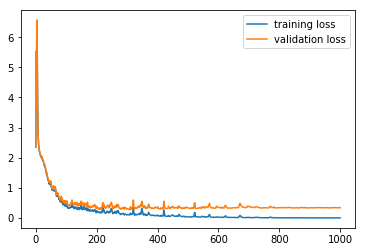

Early stopping: validation loss: 2.746e-01,  was lowest after 308 iterations
Accuracy: training 9.710e-01, validation 9.150e-01, testing 9.172e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.728e+01, training loss is 4.97e-01, and validation loss is 5.80e-01

After 200 iterations, ||theta|| 2.354e+01, training loss is 3.22e-01, and validation loss is 4.65e-01

After 300 iterations, ||theta|| 2.743e+01, training loss is 2.12e-01, and validation loss is 3.76e-01

After 400 iterations, ||theta|| 2.999e+01, training loss is 1.46e-01, and validation loss is 3.42e-01

After 500 iterations, ||theta|| 3.203e+01, training loss is 1.23e-01, and validation loss is 3.52e-01

After 600 iterations, ||theta|| 3.385e+01, training loss is 1.10e-01, and validation loss is 3.76e-01

After 700 iterations, ||theta|| 3.523e+01, training loss is 8.01e-02, and validation loss is 3.52e-01

After 800 

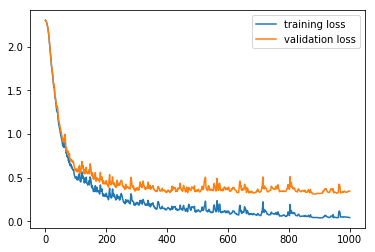

Early stopping: validation loss: 3.128e-01,  was lowest after 886 iterations
Accuracy: training 9.910e-01, validation 8.980e-01, testing 8.960e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.942e+01, training loss is 3.72e-01, and validation loss is 4.44e-01

After 200 iterations, ||theta|| 2.410e+01, training loss is 1.67e-01, and validation loss is 3.14e-01

After 300 iterations, ||theta|| 2.721e+01, training loss is 8.42e-02, and validation loss is 2.78e-01

After 400 iterations, ||theta|| 2.930e+01, training loss is 4.85e-02, and validation loss is 2.62e-01

After 500 iterations, ||theta|| 3.052e+01, training loss is 2.82e-02, and validation loss is 2.59e-01

After 600 iterations, ||theta|| 3.126e+01, training loss is 1.76e-02, and validation loss is 2.67e-01

After 700 iterations, ||theta|| 3.176e+01, training loss is 1.18e-02, and validation loss is 2.68e-01

After 800 

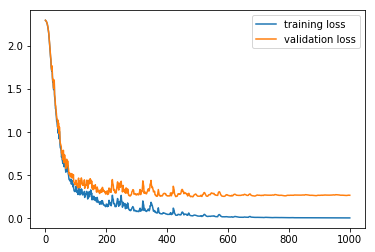

Early stopping: validation loss: 2.509e-01,  was lowest after 483 iterations
Accuracy: training 9.960e-01, validation 9.330e-01, testing 9.210e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.151e+01, training loss is 3.36e-01, and validation loss is 4.17e-01

After 200 iterations, ||theta|| 2.606e+01, training loss is 1.94e-01, and validation loss is 3.48e-01

After 300 iterations, ||theta|| 2.892e+01, training loss is 8.52e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 3.096e+01, training loss is 4.84e-02, and validation loss is 2.84e-01

After 500 iterations, ||theta|| 3.230e+01, training loss is 2.53e-02, and validation loss is 2.73e-01

After 600 iterations, ||theta|| 3.299e+01, training loss is 1.41e-02, and validation loss is 2.80e-01

After 700 iterations, ||theta|| 3.342e+01, training loss is 8.66e-03, and validation loss is 2.83e-01

After 800 

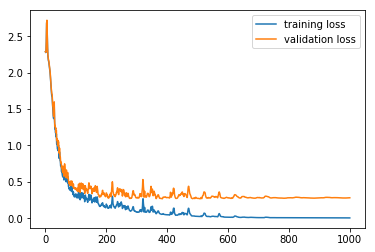

Early stopping: validation loss: 2.676e-01,  was lowest after 384 iterations
Accuracy: training 9.870e-01, validation 9.250e-01, testing 9.138e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.470e+01, training loss is 4.18e-01, and validation loss is 5.11e-01

After 200 iterations, ||theta|| 2.895e+01, training loss is 2.23e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 3.180e+01, training loss is 1.12e-01, and validation loss is 3.20e-01

After 400 iterations, ||theta|| 3.380e+01, training loss is 6.09e-02, and validation loss is 2.99e-01

After 500 iterations, ||theta|| 3.495e+01, training loss is 3.79e-02, and validation loss is 3.16e-01

After 600 iterations, ||theta|| 3.589e+01, training loss is 1.94e-02, and validation loss is 3.12e-01

After 700 iterations, ||theta|| 3.634e+01, training loss is 1.30e-02, and validation loss is 3.24e-01

After 800 

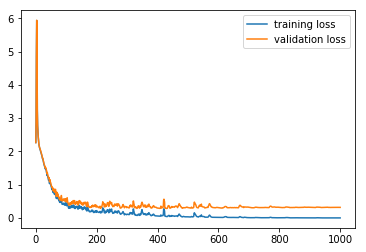

Early stopping: validation loss: 2.891e-01,  was lowest after 429 iterations
Accuracy: training 9.910e-01, validation 9.160e-01, testing 9.172e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.810e+01, training loss is 4.08e-01, and validation loss is 4.90e-01

After 200 iterations, ||theta|| 3.233e+01, training loss is 2.21e-01, and validation loss is 3.55e-01

After 300 iterations, ||theta|| 3.489e+01, training loss is 1.09e-01, and validation loss is 3.03e-01

After 400 iterations, ||theta|| 3.682e+01, training loss is 7.78e-02, and validation loss is 3.35e-01

After 500 iterations, ||theta|| 3.805e+01, training loss is 4.21e-02, and validation loss is 3.37e-01

After 600 iterations, ||theta|| 3.892e+01, training loss is 3.35e-02, and validation loss is 3.57e-01

After 700 iterations, ||theta|| 3.942e+01, training loss is 1.86e-02, and validation loss is 3.78e-01

After 800 

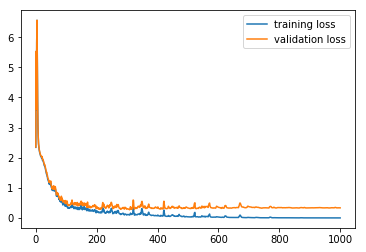

Early stopping: validation loss: 2.745e-01,  was lowest after 308 iterations
Accuracy: training 9.710e-01, validation 9.150e-01, testing 9.172e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.716e+01, training loss is 5.00e-01, and validation loss is 5.82e-01

After 200 iterations, ||theta|| 2.321e+01, training loss is 3.35e-01, and validation loss is 4.77e-01

After 300 iterations, ||theta|| 2.678e+01, training loss is 2.11e-01, and validation loss is 3.82e-01

After 400 iterations, ||theta|| 2.912e+01, training loss is 1.67e-01, and validation loss is 3.74e-01

After 500 iterations, ||theta|| 3.099e+01, training loss is 1.25e-01, and validation loss is 3.73e-01

After 600 iterations, ||theta|| 3.243e+01, training loss is 9.63e-02, and validation loss is 3.55e-01

After 700 iterations, ||theta|| 3.334e+01, training loss is 9.93e-02, and validation loss is 3.75e-01

After 800 

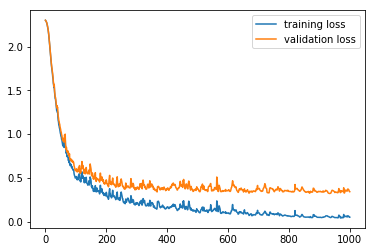

Early stopping: validation loss: 3.211e-01,  was lowest after 933 iterations
Accuracy: training 9.910e-01, validation 8.990e-01, testing 8.988e-01
Gradient test passed
After 0 iterations, ||theta|| 8.156e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.926e+01, training loss is 3.74e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.370e+01, training loss is 1.70e-01, and validation loss is 3.16e-01

After 300 iterations, ||theta|| 2.653e+01, training loss is 8.86e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 2.831e+01, training loss is 5.21e-02, and validation loss is 2.60e-01

After 500 iterations, ||theta|| 2.923e+01, training loss is 3.25e-02, and validation loss is 2.52e-01

After 600 iterations, ||theta|| 2.964e+01, training loss is 2.20e-02, and validation loss is 2.60e-01

After 700 iterations, ||theta|| 2.981e+01, training loss is 1.66e-02, and validation loss is 2.61e-01

After 800 

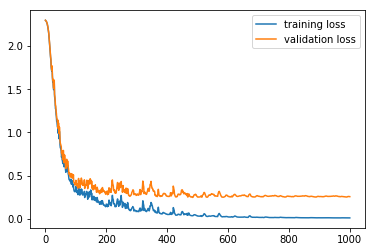

Early stopping: validation loss: 2.473e-01,  was lowest after 483 iterations
Accuracy: training 9.970e-01, validation 9.300e-01, testing 9.199e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.131e+01, training loss is 3.37e-01, and validation loss is 4.18e-01

After 200 iterations, ||theta|| 2.559e+01, training loss is 1.99e-01, and validation loss is 3.52e-01

After 300 iterations, ||theta|| 2.813e+01, training loss is 9.01e-02, and validation loss is 2.82e-01

After 400 iterations, ||theta|| 2.986e+01, training loss is 5.25e-02, and validation loss is 2.82e-01

After 500 iterations, ||theta|| 3.081e+01, training loss is 2.97e-02, and validation loss is 2.70e-01

After 600 iterations, ||theta|| 3.115e+01, training loss is 1.86e-02, and validation loss is 2.71e-01

After 700 iterations, ||theta|| 3.120e+01, training loss is 1.30e-02, and validation loss is 2.78e-01

After 800 

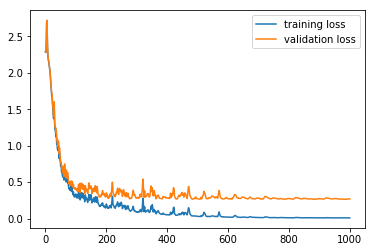

Early stopping: validation loss: 2.636e-01,  was lowest after 984 iterations
Accuracy: training 1.000e+00, validation 9.270e-01, testing 9.233e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.444e+01, training loss is 4.17e-01, and validation loss is 5.10e-01

After 200 iterations, ||theta|| 2.835e+01, training loss is 2.28e-01, and validation loss is 3.74e-01

After 300 iterations, ||theta|| 3.086e+01, training loss is 1.22e-01, and validation loss is 3.27e-01

After 400 iterations, ||theta|| 3.248e+01, training loss is 6.87e-02, and validation loss is 2.97e-01

After 500 iterations, ||theta|| 3.331e+01, training loss is 4.33e-02, and validation loss is 3.11e-01

After 600 iterations, ||theta|| 3.388e+01, training loss is 2.64e-02, and validation loss is 3.08e-01

After 700 iterations, ||theta|| 3.394e+01, training loss is 2.03e-02, and validation loss is 3.13e-01

After 800 

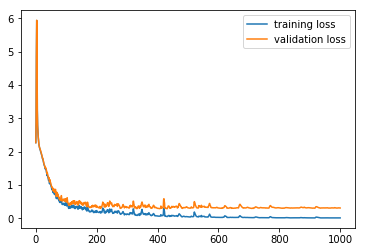

Early stopping: validation loss: 2.864e-01,  was lowest after 332 iterations
Accuracy: training 9.760e-01, validation 9.160e-01, testing 9.149e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.776e+01, training loss is 4.07e-01, and validation loss is 4.89e-01

After 200 iterations, ||theta|| 3.162e+01, training loss is 2.27e-01, and validation loss is 3.59e-01

After 300 iterations, ||theta|| 3.380e+01, training loss is 1.25e-01, and validation loss is 3.18e-01

After 400 iterations, ||theta|| 3.524e+01, training loss is 8.17e-02, and validation loss is 3.31e-01

After 500 iterations, ||theta|| 3.610e+01, training loss is 4.95e-02, and validation loss is 3.29e-01

After 600 iterations, ||theta|| 3.664e+01, training loss is 4.01e-02, and validation loss is 3.37e-01

After 700 iterations, ||theta|| 3.671e+01, training loss is 1.98e-02, and validation loss is 3.54e-01

After 800 

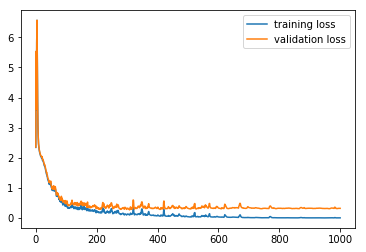

Early stopping: validation loss: 2.736e-01,  was lowest after 308 iterations
Accuracy: training 9.670e-01, validation 9.150e-01, testing 9.179e-01
Gradient test passed
After 0 iterations, ||theta|| 3.644e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.606e+01, training loss is 5.31e-01, and validation loss is 6.08e-01

After 200 iterations, ||theta|| 2.021e+01, training loss is 3.29e-01, and validation loss is 4.57e-01

After 300 iterations, ||theta|| 2.187e+01, training loss is 2.61e-01, and validation loss is 4.07e-01

After 400 iterations, ||theta|| 2.273e+01, training loss is 1.99e-01, and validation loss is 3.64e-01

After 500 iterations, ||theta|| 2.305e+01, training loss is 1.96e-01, and validation loss is 3.64e-01

After 600 iterations, ||theta|| 2.328e+01, training loss is 1.76e-01, and validation loss is 3.49e-01

After 700 iterations, ||theta|| 2.343e+01, training loss is 1.80e-01, and validation loss is 3.50e-01

After 800 

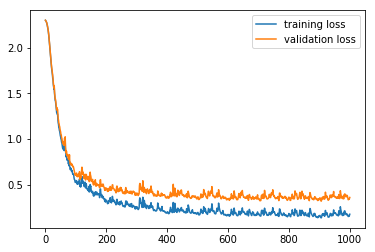

Early stopping: validation loss: 3.205e-01,  was lowest after 906 iterations
Accuracy: training 9.790e-01, validation 9.000e-01, testing 9.070e-01
Gradient test passed
After 0 iterations, ||theta|| 8.148e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.782e+01, training loss is 3.90e-01, and validation loss is 4.59e-01

After 200 iterations, ||theta|| 2.043e+01, training loss is 2.06e-01, and validation loss is 3.32e-01

After 300 iterations, ||theta|| 2.146e+01, training loss is 1.57e-01, and validation loss is 3.17e-01

After 400 iterations, ||theta|| 2.186e+01, training loss is 1.18e-01, and validation loss is 2.96e-01

After 500 iterations, ||theta|| 2.190e+01, training loss is 9.96e-02, and validation loss is 2.83e-01

After 600 iterations, ||theta|| 2.173e+01, training loss is 8.67e-02, and validation loss is 2.73e-01

After 700 iterations, ||theta|| 2.157e+01, training loss is 8.39e-02, and validation loss is 2.71e-01

After 800 

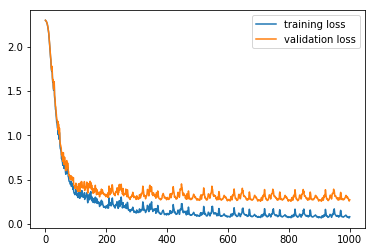

Early stopping: validation loss: 2.551e-01,  was lowest after 707 iterations
Accuracy: training 9.930e-01, validation 9.190e-01, testing 9.188e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 1.953e+01, training loss is 3.52e-01, and validation loss is 4.28e-01

After 200 iterations, ||theta|| 2.172e+01, training loss is 2.28e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 2.243e+01, training loss is 1.70e-01, and validation loss is 3.35e-01

After 400 iterations, ||theta|| 2.270e+01, training loss is 1.13e-01, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 2.271e+01, training loss is 1.06e-01, and validation loss is 3.10e-01

After 600 iterations, ||theta|| 2.244e+01, training loss is 8.64e-02, and validation loss is 2.84e-01

After 700 iterations, ||theta|| 2.210e+01, training loss is 8.37e-02, and validation loss is 2.84e-01

After 800 

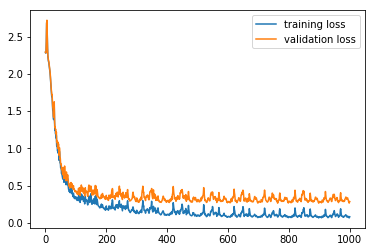

Early stopping: validation loss: 2.649e-01,  was lowest after 763 iterations
Accuracy: training 9.880e-01, validation 9.170e-01, testing 9.128e-01
Gradient test passed
After 0 iterations, ||theta|| 1.630e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.207e+01, training loss is 4.12e-01, and validation loss is 4.98e-01

After 200 iterations, ||theta|| 2.360e+01, training loss is 2.68e-01, and validation loss is 3.98e-01

After 300 iterations, ||theta|| 2.409e+01, training loss is 1.90e-01, and validation loss is 3.50e-01

After 400 iterations, ||theta|| 2.415e+01, training loss is 1.50e-01, and validation loss is 3.50e-01

After 500 iterations, ||theta|| 2.395e+01, training loss is 1.18e-01, and validation loss is 3.24e-01

After 600 iterations, ||theta|| 2.367e+01, training loss is 1.07e-01, and validation loss is 3.25e-01

After 700 iterations, ||theta|| 2.330e+01, training loss is 9.78e-02, and validation loss is 3.12e-01

After 800 

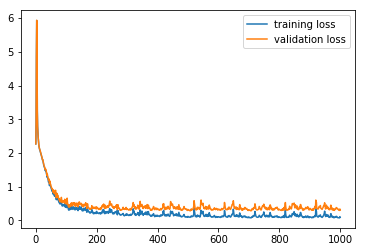

Early stopping: validation loss: 2.813e-01,  was lowest after 507 iterations
Accuracy: training 9.830e-01, validation 9.050e-01, testing 9.137e-01
Gradient test passed
After 0 iterations, ||theta|| 1.996e+01, training loss is 2.35e+00, and validation loss is 2.36e+00

After 100 iterations, ||theta|| 2.477e+01, training loss is 4.02e-01, and validation loss is 4.78e-01

After 200 iterations, ||theta|| 2.600e+01, training loss is 2.56e-01, and validation loss is 3.81e-01

After 300 iterations, ||theta|| 2.610e+01, training loss is 2.31e-01, and validation loss is 3.89e-01

After 400 iterations, ||theta|| 2.579e+01, training loss is 1.62e-01, and validation loss is 3.54e-01

After 500 iterations, ||theta|| 2.564e+01, training loss is 1.90e-01, and validation loss is 4.27e-01

After 600 iterations, ||theta|| 2.563e+01, training loss is 1.08e-01, and validation loss is 3.19e-01

After 700 iterations, ||theta|| 2.551e+01, training loss is 1.33e-01, and validation loss is 3.75e-01

After 800 

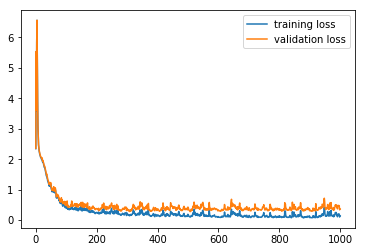

Early stopping: validation loss: 2.799e-01,  was lowest after 507 iterations
Accuracy: training 9.720e-01, validation 9.050e-01, testing 9.096e-01
Gradient test passed
After 0 iterations, ||theta|| 3.611e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.028e+01, training loss is 8.83e-01, and validation loss is 9.19e-01

After 200 iterations, ||theta|| 1.121e+01, training loss is 7.30e-01, and validation loss is 7.84e-01

After 300 iterations, ||theta|| 1.138e+01, training loss is 7.08e-01, and validation loss is 7.69e-01

After 400 iterations, ||theta|| 1.143e+01, training loss is 7.02e-01, and validation loss is 7.66e-01

After 500 iterations, ||theta|| 1.145e+01, training loss is 7.00e-01, and validation loss is 7.65e-01

After 600 iterations, ||theta|| 1.145e+01, training loss is 6.99e-01, and validation loss is 7.65e-01

After 700 iterations, ||theta|| 1.146e+01, training loss is 7.00e-01, and validation loss is 7.65e-01

After 800 

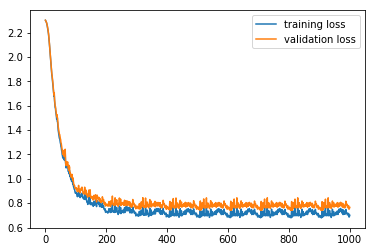

Early stopping: validation loss: 7.399e-01,  was lowest after 907 iterations
Accuracy: training 9.000e-01, validation 8.780e-01, testing 8.746e-01
Gradient test passed
After 0 iterations, ||theta|| 8.075e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.115e+01, training loss is 6.11e-01, and validation loss is 6.47e-01

After 200 iterations, ||theta|| 1.159e+01, training loss is 5.36e-01, and validation loss is 5.92e-01

After 300 iterations, ||theta|| 1.162e+01, training loss is 5.27e-01, and validation loss is 5.85e-01

After 400 iterations, ||theta|| 1.163e+01, training loss is 5.24e-01, and validation loss is 5.84e-01

After 500 iterations, ||theta|| 1.163e+01, training loss is 5.23e-01, and validation loss is 5.83e-01

After 600 iterations, ||theta|| 1.164e+01, training loss is 5.22e-01, and validation loss is 5.82e-01

After 700 iterations, ||theta|| 1.164e+01, training loss is 5.21e-01, and validation loss is 5.82e-01

After 800 

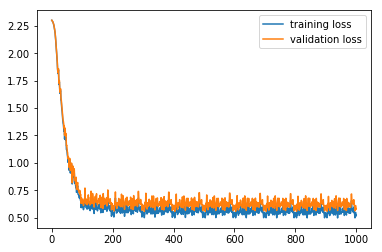

Early stopping: validation loss: 5.558e-01,  was lowest after 404 iterations
Accuracy: training 9.060e-01, validation 8.870e-01, testing 8.840e-01
Gradient test passed
After 0 iterations, ||theta|| 1.142e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.169e+01, training loss is 5.59e-01, and validation loss is 6.12e-01

After 200 iterations, ||theta|| 1.197e+01, training loss is 5.02e-01, and validation loss is 5.63e-01

After 300 iterations, ||theta|| 1.199e+01, training loss is 4.96e-01, and validation loss is 5.59e-01

After 400 iterations, ||theta|| 1.200e+01, training loss is 4.94e-01, and validation loss is 5.56e-01

After 500 iterations, ||theta|| 1.200e+01, training loss is 4.92e-01, and validation loss is 5.54e-01

After 600 iterations, ||theta|| 1.201e+01, training loss is 4.91e-01, and validation loss is 5.53e-01

After 700 iterations, ||theta|| 1.201e+01, training loss is 4.90e-01, and validation loss is 5.52e-01

After 800 

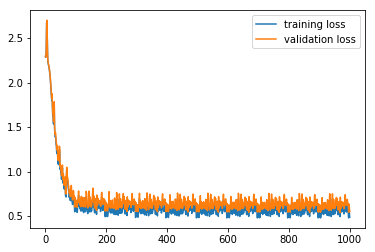

Early stopping: validation loss: 5.415e-01,  was lowest after 968 iterations
Accuracy: training 8.880e-01, validation 8.760e-01, testing 8.636e-01
Gradient test passed
After 0 iterations, ||theta|| 1.615e+01, training loss is 2.28e+00, and validation loss is 2.28e+00

After 100 iterations, ||theta|| 1.251e+01, training loss is 5.95e-01, and validation loss is 6.57e-01

After 200 iterations, ||theta|| 1.285e+01, training loss is 5.03e-01, and validation loss is 5.76e-01

After 300 iterations, ||theta|| 1.281e+01, training loss is 4.92e-01, and validation loss is 5.63e-01

After 400 iterations, ||theta|| 1.283e+01, training loss is 4.86e-01, and validation loss is 5.58e-01

After 500 iterations, ||theta|| 1.282e+01, training loss is 4.84e-01, and validation loss is 5.56e-01

After 600 iterations, ||theta|| 1.283e+01, training loss is 4.83e-01, and validation loss is 5.54e-01

After 700 iterations, ||theta|| 1.282e+01, training loss is 4.83e-01, and validation loss is 5.53e-01

After 800 

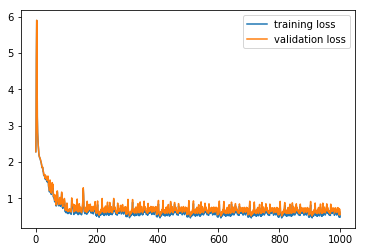

Early stopping: validation loss: 5.092e-01,  was lowest after 708 iterations
Accuracy: training 8.970e-01, validation 8.840e-01, testing 8.776e-01
Gradient test passed
After 0 iterations, ||theta|| 1.978e+01, training loss is 2.37e+00, and validation loss is 2.37e+00

After 100 iterations, ||theta|| 1.353e+01, training loss is 6.43e-01, and validation loss is 6.90e-01

After 200 iterations, ||theta|| 1.368e+01, training loss is 5.40e-01, and validation loss is 6.14e-01

After 300 iterations, ||theta|| 1.389e+01, training loss is 5.17e-01, and validation loss is 5.95e-01

After 400 iterations, ||theta|| 1.369e+01, training loss is 5.43e-01, and validation loss is 6.20e-01

After 500 iterations, ||theta|| 1.377e+01, training loss is 4.98e-01, and validation loss is 5.76e-01

After 600 iterations, ||theta|| 1.370e+01, training loss is 5.17e-01, and validation loss is 5.94e-01

After 700 iterations, ||theta|| 1.375e+01, training loss is 4.88e-01, and validation loss is 5.64e-01

After 800 

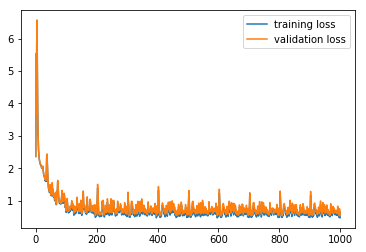

Early stopping: validation loss: 5.402e-01,  was lowest after 608 iterations
Accuracy: training 8.860e-01, validation 8.780e-01, testing 8.672e-01
Gradient test passed
After 0 iterations, ||theta|| 3.283e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 100 iterations, ||theta|| 1.161e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 200 iterations, ||theta|| 1.199e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 300 iterations, ||theta|| 1.201e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 400 iterations, ||theta|| 1.208e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 500 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 600 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 700 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 800 

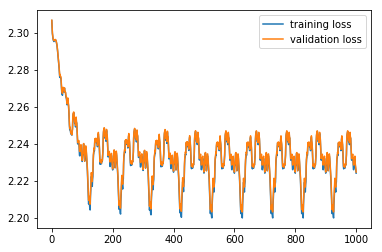

Early stopping: validation loss: 2.203e+00,  was lowest after 926 iterations
Accuracy: training 1.980e-01, validation 1.950e-01, testing 2.031e-01
Gradient test passed
After 0 iterations, ||theta|| 7.341e+00, training loss is 2.33e+00, and validation loss is 2.33e+00

After 100 iterations, ||theta|| 1.442e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.468e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 300 iterations, ||theta|| 1.473e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 400 iterations, ||theta|| 1.476e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 500 iterations, ||theta|| 1.479e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 600 iterations, ||theta|| 1.480e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 700 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 800 

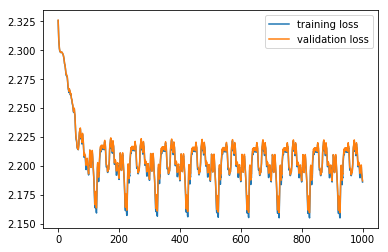

Early stopping: validation loss: 2.160e+00,  was lowest after 926 iterations
Accuracy: training 2.090e-01, validation 2.260e-01, testing 2.201e-01
Gradient test passed
After 0 iterations, ||theta|| 1.038e+01, training loss is 2.34e+00, and validation loss is 2.34e+00

After 100 iterations, ||theta|| 1.480e+00, training loss is 2.40e+00, and validation loss is 2.40e+00

After 200 iterations, ||theta|| 1.637e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 300 iterations, ||theta|| 1.667e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 400 iterations, ||theta|| 1.648e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 500 iterations, ||theta|| 1.678e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 600 iterations, ||theta|| 1.676e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.640e+00, training loss is 2.26e+00, and validation loss is 2.27e+00

After 800 

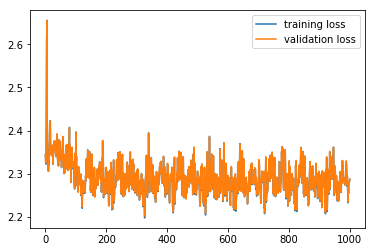

Early stopping: validation loss: 2.202e+00,  was lowest after 326 iterations
Accuracy: training 1.910e-01, validation 1.920e-01, testing 1.958e-01
Gradient test passed
After 0 iterations, ||theta|| 1.469e+01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 3.150e+00, training loss is 3.00e+00, and validation loss is 2.99e+00

After 200 iterations, ||theta|| 2.610e+00, training loss is 2.73e+00, and validation loss is 2.72e+00

After 300 iterations, ||theta|| 2.829e+00, training loss is 2.75e+00, and validation loss is 2.74e+00

After 400 iterations, ||theta|| 2.953e+00, training loss is 2.88e+00, and validation loss is 2.87e+00

After 500 iterations, ||theta|| 2.786e+00, training loss is 2.97e+00, and validation loss is 2.96e+00

After 600 iterations, ||theta|| 3.076e+00, training loss is 2.70e+00, and validation loss is 2.69e+00

After 700 iterations, ||theta|| 2.662e+00, training loss is 2.72e+00, and validation loss is 2.72e+00

After 800 

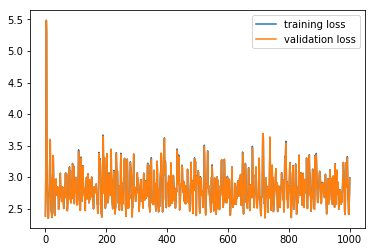

Early stopping: validation loss: 2.352e+00,  was lowest after 721 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.799e+01, training loss is 2.51e+00, and validation loss is 2.52e+00

After 100 iterations, ||theta|| 3.817e+00, training loss is 2.79e+00, and validation loss is 2.79e+00

After 200 iterations, ||theta|| 4.547e+00, training loss is 3.32e+00, and validation loss is 3.32e+00

After 300 iterations, ||theta|| 4.385e+00, training loss is 4.14e+00, and validation loss is 4.13e+00

After 400 iterations, ||theta|| 3.885e+00, training loss is 3.71e+00, and validation loss is 3.71e+00

After 500 iterations, ||theta|| 4.335e+00, training loss is 3.27e+00, and validation loss is 3.26e+00

After 600 iterations, ||theta|| 3.854e+00, training loss is 3.16e+00, and validation loss is 3.15e+00

After 700 iterations, ||theta|| 3.974e+00, training loss is 3.65e+00, and validation loss is 3.64e+00

After 800 

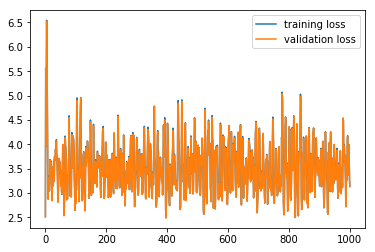

Early stopping: validation loss: 2.488e+00,  was lowest after 396 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.097e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 

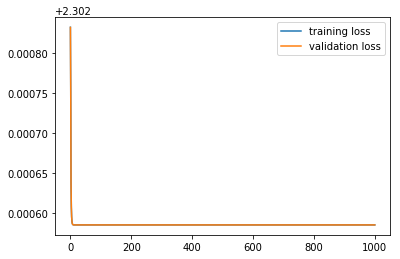

Early stopping: validation loss: 2.303e+00,  was lowest after 46 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.602e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 200 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 300 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 400 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 500 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 600 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 700 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 800 i

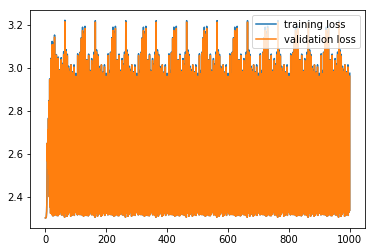

Early stopping: validation loss: 2.303e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.257e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 200 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 300 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 400 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 500 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 600 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 700 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 800 it

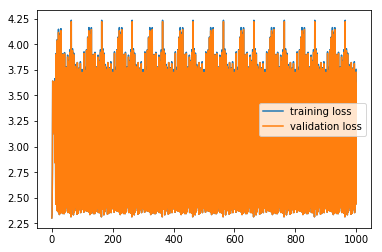

Early stopping: validation loss: 2.304e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 4.594e-01, training loss is 2.32e+00, and validation loss is 2.32e+00

After 100 iterations, ||theta|| 1.532e+00, training loss is 2.83e+00, and validation loss is 2.83e+00

After 200 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 300 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 400 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 500 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 600 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 700 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 800 it

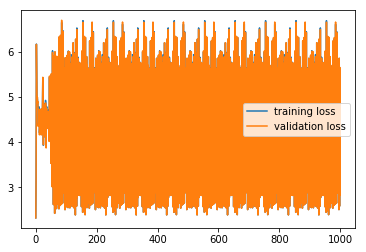

Early stopping: validation loss: 2.324e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 5.833e-01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 200 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 300 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 400 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 500 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 600 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 700 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 800 it

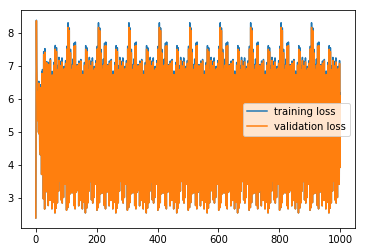

Early stopping: validation loss: 2.382e+00,  was lowest after 0 iterations
Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.729e+01, training loss is 4.97e-01, and validation loss is 5.79e-01

After 200 iterations, ||theta|| 2.358e+01, training loss is 3.21e-01, and validation loss is 4.66e-01

After 300 iterations, ||theta|| 2.753e+01, training loss is 1.97e-01, and validation loss is 3.64e-01

After 400 iterations, ||theta|| 3.003e+01, training loss is 1.37e-01, and validation loss is 3.41e-01

After 500 iterations, ||theta|| 3.207e+01, training loss is 1.11e-01, and validation loss is 3.41e-01

After 600 iterations, ||theta|| 3.372e+01, training loss is 8.57e-02, and validation loss is 3.35e-01

After 700 iterations, ||theta|| 3.526e+01, training loss is 1.69e-01, and validation loss is 4.19e-01

After 800 it

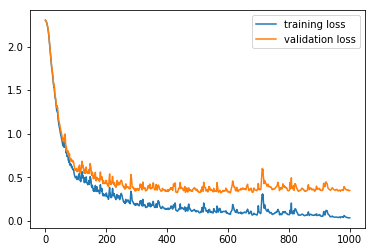

Accuracy: training 9.970e-01, validation 8.880e-01, testing 8.954e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.943e+01, training loss is 3.72e-01, and validation loss is 4.44e-01

After 200 iterations, ||theta|| 2.415e+01, training loss is 1.66e-01, and validation loss is 3.14e-01

After 300 iterations, ||theta|| 2.729e+01, training loss is 8.38e-02, and validation loss is 2.78e-01

After 400 iterations, ||theta|| 2.941e+01, training loss is 4.81e-02, and validation loss is 2.62e-01

After 500 iterations, ||theta|| 3.067e+01, training loss is 2.78e-02, and validation loss is 2.60e-01

After 600 iterations, ||theta|| 3.145e+01, training loss is 1.71e-02, and validation loss is 2.68e-01

After 700 iterations, ||theta|| 3.199e+01, training loss is 1.13e-02, and validation loss is 2.69e-01

After 800 iterations, ||theta|| 3.240e+01, training loss is 8.04e-03, and validation lo

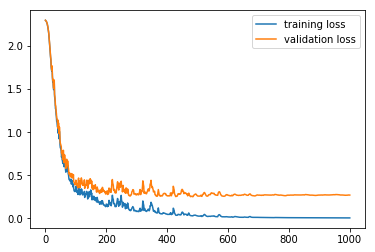

Accuracy: training 1.000e+00, validation 9.300e-01, testing 9.277e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.153e+01, training loss is 3.35e-01, and validation loss is 4.17e-01

After 200 iterations, ||theta|| 2.611e+01, training loss is 1.94e-01, and validation loss is 3.48e-01

After 300 iterations, ||theta|| 2.902e+01, training loss is 8.48e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 3.109e+01, training loss is 4.80e-02, and validation loss is 2.85e-01

After 500 iterations, ||theta|| 3.248e+01, training loss is 2.49e-02, and validation loss is 2.73e-01

After 600 iterations, ||theta|| 3.321e+01, training loss is 1.37e-02, and validation loss is 2.81e-01

After 700 iterations, ||theta|| 3.369e+01, training loss is 8.22e-03, and validation loss is 2.84e-01

After 800 iterations, ||theta|| 3.402e+01, training loss is 5.88e-03, and validation lo

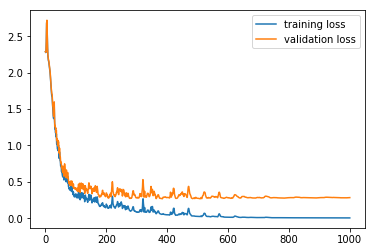

Accuracy: training 1.000e+00, validation 9.260e-01, testing 9.246e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.473e+01, training loss is 4.18e-01, and validation loss is 5.11e-01

After 200 iterations, ||theta|| 2.902e+01, training loss is 2.22e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 3.190e+01, training loss is 1.11e-01, and validation loss is 3.19e-01

After 400 iterations, ||theta|| 3.396e+01, training loss is 6.01e-02, and validation loss is 2.99e-01

After 500 iterations, ||theta|| 3.514e+01, training loss is 3.72e-02, and validation loss is 3.17e-01

After 600 iterations, ||theta|| 3.613e+01, training loss is 1.88e-02, and validation loss is 3.12e-01

After 700 iterations, ||theta|| 3.663e+01, training loss is 1.18e-02, and validation loss is 3.22e-01

After 800 iterations, ||theta|| 3.697e+01, training loss is 8.19e-03, and validation lo

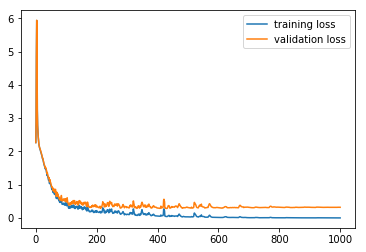

Accuracy: training 1.000e+00, validation 9.230e-01, testing 9.220e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.813e+01, training loss is 4.08e-01, and validation loss is 4.90e-01

After 200 iterations, ||theta|| 3.241e+01, training loss is 2.21e-01, and validation loss is 3.54e-01

After 300 iterations, ||theta|| 3.502e+01, training loss is 1.08e-01, and validation loss is 3.03e-01

After 400 iterations, ||theta|| 3.700e+01, training loss is 7.72e-02, and validation loss is 3.36e-01

After 500 iterations, ||theta|| 3.827e+01, training loss is 4.14e-02, and validation loss is 3.38e-01

After 600 iterations, ||theta|| 3.916e+01, training loss is 2.80e-02, and validation loss is 3.56e-01

After 700 iterations, ||theta|| 3.969e+01, training loss is 1.77e-02, and validation loss is 3.79e-01

After 800 iterations, ||theta|| 4.001e+01, training loss is 7.45e-03, and validation lo

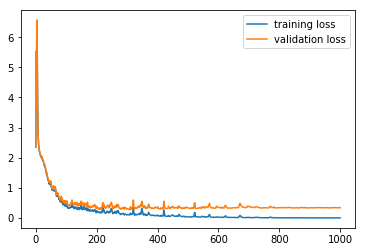

Accuracy: training 1.000e+00, validation 9.270e-01, testing 9.187e-01
Gradient test passed
After 0 iterations, ||theta|| 3.648e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.728e+01, training loss is 4.97e-01, and validation loss is 5.80e-01

After 200 iterations, ||theta|| 2.354e+01, training loss is 3.22e-01, and validation loss is 4.65e-01

After 300 iterations, ||theta|| 2.743e+01, training loss is 2.12e-01, and validation loss is 3.76e-01

After 400 iterations, ||theta|| 2.999e+01, training loss is 1.46e-01, and validation loss is 3.42e-01

After 500 iterations, ||theta|| 3.203e+01, training loss is 1.23e-01, and validation loss is 3.52e-01

After 600 iterations, ||theta|| 3.385e+01, training loss is 1.10e-01, and validation loss is 3.76e-01

After 700 iterations, ||theta|| 3.523e+01, training loss is 8.01e-02, and validation loss is 3.52e-01

After 800 iterations, ||theta|| 3.628e+01, training loss is 8.05e-02, and validation lo

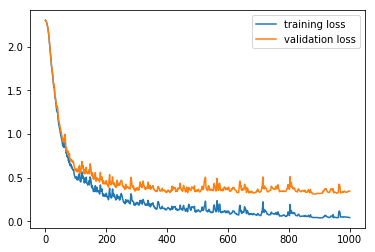

Accuracy: training 9.900e-01, validation 8.890e-01, testing 8.940e-01
Gradient test passed
After 0 iterations, ||theta|| 8.157e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.942e+01, training loss is 3.72e-01, and validation loss is 4.44e-01

After 200 iterations, ||theta|| 2.410e+01, training loss is 1.67e-01, and validation loss is 3.14e-01

After 300 iterations, ||theta|| 2.721e+01, training loss is 8.42e-02, and validation loss is 2.78e-01

After 400 iterations, ||theta|| 2.930e+01, training loss is 4.85e-02, and validation loss is 2.62e-01

After 500 iterations, ||theta|| 3.052e+01, training loss is 2.82e-02, and validation loss is 2.59e-01

After 600 iterations, ||theta|| 3.126e+01, training loss is 1.76e-02, and validation loss is 2.67e-01

After 700 iterations, ||theta|| 3.176e+01, training loss is 1.18e-02, and validation loss is 2.68e-01

After 800 iterations, ||theta|| 3.211e+01, training loss is 8.49e-03, and validation lo

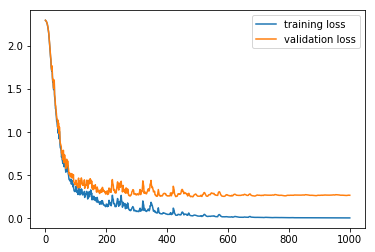

Accuracy: training 1.000e+00, validation 9.300e-01, testing 9.270e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.151e+01, training loss is 3.36e-01, and validation loss is 4.17e-01

After 200 iterations, ||theta|| 2.606e+01, training loss is 1.94e-01, and validation loss is 3.48e-01

After 300 iterations, ||theta|| 2.892e+01, training loss is 8.52e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 3.096e+01, training loss is 4.84e-02, and validation loss is 2.84e-01

After 500 iterations, ||theta|| 3.230e+01, training loss is 2.53e-02, and validation loss is 2.73e-01

After 600 iterations, ||theta|| 3.299e+01, training loss is 1.41e-02, and validation loss is 2.80e-01

After 700 iterations, ||theta|| 3.342e+01, training loss is 8.66e-03, and validation loss is 2.83e-01

After 800 iterations, ||theta|| 3.370e+01, training loss is 6.25e-03, and validation lo

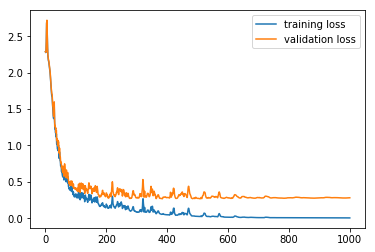

Accuracy: training 1.000e+00, validation 9.260e-01, testing 9.248e-01
Gradient test passed
After 0 iterations, ||theta|| 1.632e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.470e+01, training loss is 4.18e-01, and validation loss is 5.11e-01

After 200 iterations, ||theta|| 2.895e+01, training loss is 2.23e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 3.180e+01, training loss is 1.12e-01, and validation loss is 3.20e-01

After 400 iterations, ||theta|| 3.380e+01, training loss is 6.09e-02, and validation loss is 2.99e-01

After 500 iterations, ||theta|| 3.495e+01, training loss is 3.79e-02, and validation loss is 3.16e-01

After 600 iterations, ||theta|| 3.589e+01, training loss is 1.94e-02, and validation loss is 3.12e-01

After 700 iterations, ||theta|| 3.634e+01, training loss is 1.30e-02, and validation loss is 3.24e-01

After 800 iterations, ||theta|| 3.663e+01, training loss is 8.71e-03, and validation lo

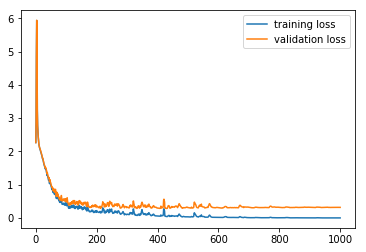

Accuracy: training 1.000e+00, validation 9.240e-01, testing 9.224e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.810e+01, training loss is 4.08e-01, and validation loss is 4.90e-01

After 200 iterations, ||theta|| 3.233e+01, training loss is 2.21e-01, and validation loss is 3.55e-01

After 300 iterations, ||theta|| 3.489e+01, training loss is 1.09e-01, and validation loss is 3.03e-01

After 400 iterations, ||theta|| 3.682e+01, training loss is 7.78e-02, and validation loss is 3.35e-01

After 500 iterations, ||theta|| 3.805e+01, training loss is 4.21e-02, and validation loss is 3.37e-01

After 600 iterations, ||theta|| 3.892e+01, training loss is 3.35e-02, and validation loss is 3.57e-01

After 700 iterations, ||theta|| 3.942e+01, training loss is 1.86e-02, and validation loss is 3.78e-01

After 800 iterations, ||theta|| 3.968e+01, training loss is 8.74e-03, and validation lo

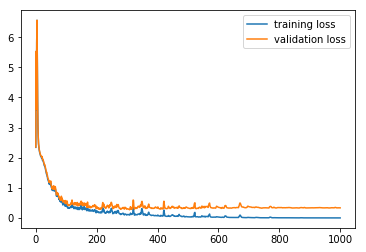

Accuracy: training 1.000e+00, validation 9.280e-01, testing 9.184e-01
Gradient test passed
After 0 iterations, ||theta|| 3.647e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.716e+01, training loss is 5.00e-01, and validation loss is 5.82e-01

After 200 iterations, ||theta|| 2.321e+01, training loss is 3.35e-01, and validation loss is 4.77e-01

After 300 iterations, ||theta|| 2.678e+01, training loss is 2.11e-01, and validation loss is 3.82e-01

After 400 iterations, ||theta|| 2.912e+01, training loss is 1.67e-01, and validation loss is 3.74e-01

After 500 iterations, ||theta|| 3.099e+01, training loss is 1.25e-01, and validation loss is 3.73e-01

After 600 iterations, ||theta|| 3.243e+01, training loss is 9.63e-02, and validation loss is 3.55e-01

After 700 iterations, ||theta|| 3.334e+01, training loss is 9.93e-02, and validation loss is 3.75e-01

After 800 iterations, ||theta|| 3.395e+01, training loss is 6.29e-02, and validation lo

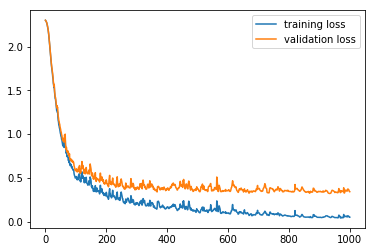

Accuracy: training 9.930e-01, validation 8.890e-01, testing 8.948e-01
Gradient test passed
After 0 iterations, ||theta|| 8.156e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.926e+01, training loss is 3.74e-01, and validation loss is 4.46e-01

After 200 iterations, ||theta|| 2.370e+01, training loss is 1.70e-01, and validation loss is 3.16e-01

After 300 iterations, ||theta|| 2.653e+01, training loss is 8.86e-02, and validation loss is 2.80e-01

After 400 iterations, ||theta|| 2.831e+01, training loss is 5.21e-02, and validation loss is 2.60e-01

After 500 iterations, ||theta|| 2.923e+01, training loss is 3.25e-02, and validation loss is 2.52e-01

After 600 iterations, ||theta|| 2.964e+01, training loss is 2.20e-02, and validation loss is 2.60e-01

After 700 iterations, ||theta|| 2.981e+01, training loss is 1.66e-02, and validation loss is 2.61e-01

After 800 iterations, ||theta|| 2.983e+01, training loss is 1.31e-02, and validation lo

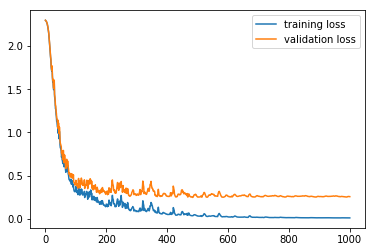

Accuracy: training 1.000e+00, validation 9.350e-01, testing 9.268e-01
Gradient test passed
After 0 iterations, ||theta|| 1.154e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 2.131e+01, training loss is 3.37e-01, and validation loss is 4.18e-01

After 200 iterations, ||theta|| 2.559e+01, training loss is 1.99e-01, and validation loss is 3.52e-01

After 300 iterations, ||theta|| 2.813e+01, training loss is 9.01e-02, and validation loss is 2.82e-01

After 400 iterations, ||theta|| 2.986e+01, training loss is 5.25e-02, and validation loss is 2.82e-01

After 500 iterations, ||theta|| 3.081e+01, training loss is 2.97e-02, and validation loss is 2.70e-01

After 600 iterations, ||theta|| 3.115e+01, training loss is 1.86e-02, and validation loss is 2.71e-01

After 700 iterations, ||theta|| 3.120e+01, training loss is 1.30e-02, and validation loss is 2.78e-01

After 800 iterations, ||theta|| 3.112e+01, training loss is 1.03e-02, and validation lo

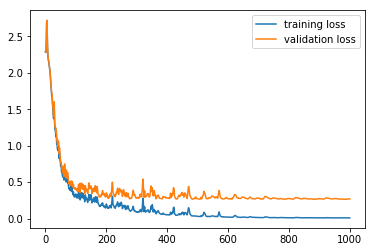

Accuracy: training 1.000e+00, validation 9.260e-01, testing 9.237e-01
Gradient test passed
After 0 iterations, ||theta|| 1.631e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.444e+01, training loss is 4.17e-01, and validation loss is 5.10e-01

After 200 iterations, ||theta|| 2.835e+01, training loss is 2.28e-01, and validation loss is 3.74e-01

After 300 iterations, ||theta|| 3.086e+01, training loss is 1.22e-01, and validation loss is 3.27e-01

After 400 iterations, ||theta|| 3.248e+01, training loss is 6.87e-02, and validation loss is 2.97e-01

After 500 iterations, ||theta|| 3.331e+01, training loss is 4.33e-02, and validation loss is 3.11e-01

After 600 iterations, ||theta|| 3.388e+01, training loss is 2.64e-02, and validation loss is 3.08e-01

After 700 iterations, ||theta|| 3.394e+01, training loss is 2.03e-02, and validation loss is 3.13e-01

After 800 iterations, ||theta|| 3.381e+01, training loss is 1.38e-02, and validation lo

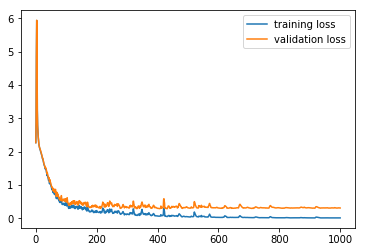

Accuracy: training 1.000e+00, validation 9.250e-01, testing 9.208e-01
Gradient test passed
After 0 iterations, ||theta|| 1.998e+01, training loss is 2.35e+00, and validation loss is 2.35e+00

After 100 iterations, ||theta|| 2.776e+01, training loss is 4.07e-01, and validation loss is 4.89e-01

After 200 iterations, ||theta|| 3.162e+01, training loss is 2.27e-01, and validation loss is 3.59e-01

After 300 iterations, ||theta|| 3.380e+01, training loss is 1.25e-01, and validation loss is 3.18e-01

After 400 iterations, ||theta|| 3.524e+01, training loss is 8.17e-02, and validation loss is 3.31e-01

After 500 iterations, ||theta|| 3.610e+01, training loss is 4.95e-02, and validation loss is 3.29e-01

After 600 iterations, ||theta|| 3.664e+01, training loss is 4.01e-02, and validation loss is 3.37e-01

After 700 iterations, ||theta|| 3.671e+01, training loss is 1.98e-02, and validation loss is 3.54e-01

After 800 iterations, ||theta|| 3.643e+01, training loss is 1.18e-02, and validation lo

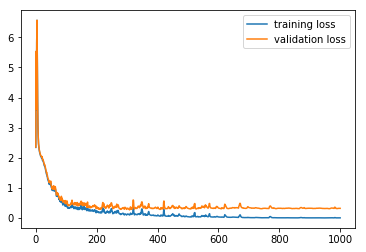

Accuracy: training 1.000e+00, validation 9.240e-01, testing 9.152e-01
Gradient test passed
After 0 iterations, ||theta|| 3.644e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.606e+01, training loss is 5.31e-01, and validation loss is 6.08e-01

After 200 iterations, ||theta|| 2.021e+01, training loss is 3.29e-01, and validation loss is 4.57e-01

After 300 iterations, ||theta|| 2.187e+01, training loss is 2.61e-01, and validation loss is 4.07e-01

After 400 iterations, ||theta|| 2.273e+01, training loss is 1.99e-01, and validation loss is 3.64e-01

After 500 iterations, ||theta|| 2.305e+01, training loss is 1.96e-01, and validation loss is 3.64e-01

After 600 iterations, ||theta|| 2.328e+01, training loss is 1.76e-01, and validation loss is 3.49e-01

After 700 iterations, ||theta|| 2.343e+01, training loss is 1.80e-01, and validation loss is 3.50e-01

After 800 iterations, ||theta|| 2.339e+01, training loss is 1.86e-01, and validation lo

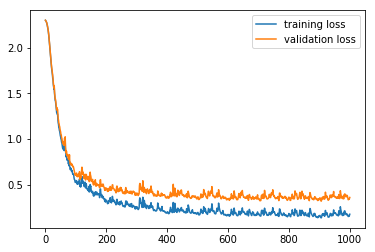

Accuracy: training 9.690e-01, validation 8.930e-01, testing 8.933e-01
Gradient test passed
After 0 iterations, ||theta|| 8.148e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.782e+01, training loss is 3.90e-01, and validation loss is 4.59e-01

After 200 iterations, ||theta|| 2.043e+01, training loss is 2.06e-01, and validation loss is 3.32e-01

After 300 iterations, ||theta|| 2.146e+01, training loss is 1.57e-01, and validation loss is 3.17e-01

After 400 iterations, ||theta|| 2.186e+01, training loss is 1.18e-01, and validation loss is 2.96e-01

After 500 iterations, ||theta|| 2.190e+01, training loss is 9.96e-02, and validation loss is 2.83e-01

After 600 iterations, ||theta|| 2.173e+01, training loss is 8.67e-02, and validation loss is 2.73e-01

After 700 iterations, ||theta|| 2.157e+01, training loss is 8.39e-02, and validation loss is 2.71e-01

After 800 iterations, ||theta|| 2.147e+01, training loss is 8.23e-02, and validation lo

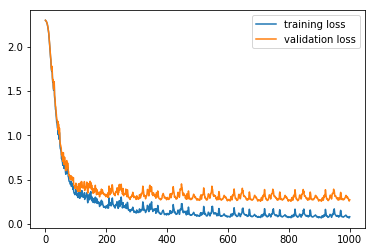

Accuracy: training 9.890e-01, validation 9.110e-01, testing 9.150e-01
Gradient test passed
After 0 iterations, ||theta|| 1.153e+01, training loss is 2.29e+00, and validation loss is 2.29e+00

After 100 iterations, ||theta|| 1.953e+01, training loss is 3.52e-01, and validation loss is 4.28e-01

After 200 iterations, ||theta|| 2.172e+01, training loss is 2.28e-01, and validation loss is 3.70e-01

After 300 iterations, ||theta|| 2.243e+01, training loss is 1.70e-01, and validation loss is 3.35e-01

After 400 iterations, ||theta|| 2.270e+01, training loss is 1.13e-01, and validation loss is 2.92e-01

After 500 iterations, ||theta|| 2.271e+01, training loss is 1.06e-01, and validation loss is 3.10e-01

After 600 iterations, ||theta|| 2.244e+01, training loss is 8.64e-02, and validation loss is 2.84e-01

After 700 iterations, ||theta|| 2.210e+01, training loss is 8.37e-02, and validation loss is 2.84e-01

After 800 iterations, ||theta|| 2.192e+01, training loss is 8.62e-02, and validation lo

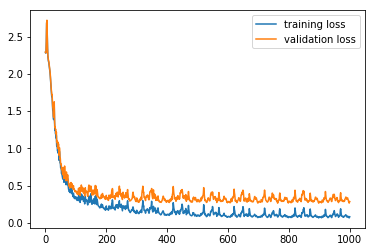

Accuracy: training 9.840e-01, validation 9.110e-01, testing 9.096e-01
Gradient test passed
After 0 iterations, ||theta|| 1.630e+01, training loss is 2.27e+00, and validation loss is 2.27e+00

After 100 iterations, ||theta|| 2.207e+01, training loss is 4.12e-01, and validation loss is 4.98e-01

After 200 iterations, ||theta|| 2.360e+01, training loss is 2.68e-01, and validation loss is 3.98e-01

After 300 iterations, ||theta|| 2.409e+01, training loss is 1.90e-01, and validation loss is 3.50e-01

After 400 iterations, ||theta|| 2.415e+01, training loss is 1.50e-01, and validation loss is 3.50e-01

After 500 iterations, ||theta|| 2.395e+01, training loss is 1.18e-01, and validation loss is 3.24e-01

After 600 iterations, ||theta|| 2.367e+01, training loss is 1.07e-01, and validation loss is 3.25e-01

After 700 iterations, ||theta|| 2.330e+01, training loss is 9.78e-02, and validation loss is 3.12e-01

After 800 iterations, ||theta|| 2.324e+01, training loss is 1.03e-01, and validation lo

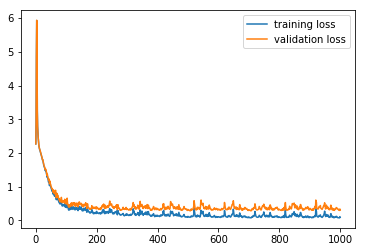

Accuracy: training 9.800e-01, validation 9.000e-01, testing 9.048e-01
Gradient test passed
After 0 iterations, ||theta|| 1.996e+01, training loss is 2.35e+00, and validation loss is 2.36e+00

After 100 iterations, ||theta|| 2.477e+01, training loss is 4.02e-01, and validation loss is 4.78e-01

After 200 iterations, ||theta|| 2.600e+01, training loss is 2.56e-01, and validation loss is 3.81e-01

After 300 iterations, ||theta|| 2.610e+01, training loss is 2.31e-01, and validation loss is 3.89e-01

After 400 iterations, ||theta|| 2.579e+01, training loss is 1.62e-01, and validation loss is 3.54e-01

After 500 iterations, ||theta|| 2.564e+01, training loss is 1.90e-01, and validation loss is 4.27e-01

After 600 iterations, ||theta|| 2.563e+01, training loss is 1.08e-01, and validation loss is 3.19e-01

After 700 iterations, ||theta|| 2.551e+01, training loss is 1.33e-01, and validation loss is 3.75e-01

After 800 iterations, ||theta|| 2.445e+01, training loss is 1.02e-01, and validation lo

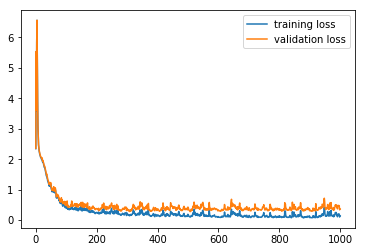

Accuracy: training 9.620e-01, validation 8.770e-01, testing 8.860e-01
Gradient test passed
After 0 iterations, ||theta|| 3.611e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.028e+01, training loss is 8.83e-01, and validation loss is 9.19e-01

After 200 iterations, ||theta|| 1.121e+01, training loss is 7.30e-01, and validation loss is 7.84e-01

After 300 iterations, ||theta|| 1.138e+01, training loss is 7.08e-01, and validation loss is 7.69e-01

After 400 iterations, ||theta|| 1.143e+01, training loss is 7.02e-01, and validation loss is 7.66e-01

After 500 iterations, ||theta|| 1.145e+01, training loss is 7.00e-01, and validation loss is 7.65e-01

After 600 iterations, ||theta|| 1.145e+01, training loss is 6.99e-01, and validation loss is 7.65e-01

After 700 iterations, ||theta|| 1.146e+01, training loss is 7.00e-01, and validation loss is 7.65e-01

After 800 iterations, ||theta|| 1.146e+01, training loss is 7.00e-01, and validation lo

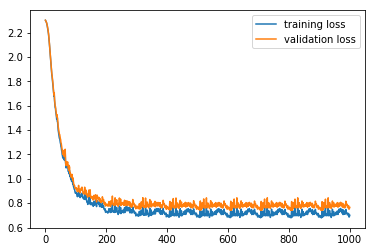

Accuracy: training 9.040e-01, validation 8.540e-01, testing 8.650e-01
Gradient test passed
After 0 iterations, ||theta|| 8.075e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.115e+01, training loss is 6.11e-01, and validation loss is 6.47e-01

After 200 iterations, ||theta|| 1.159e+01, training loss is 5.36e-01, and validation loss is 5.92e-01

After 300 iterations, ||theta|| 1.162e+01, training loss is 5.27e-01, and validation loss is 5.85e-01

After 400 iterations, ||theta|| 1.163e+01, training loss is 5.24e-01, and validation loss is 5.84e-01

After 500 iterations, ||theta|| 1.163e+01, training loss is 5.23e-01, and validation loss is 5.83e-01

After 600 iterations, ||theta|| 1.164e+01, training loss is 5.22e-01, and validation loss is 5.82e-01

After 700 iterations, ||theta|| 1.164e+01, training loss is 5.21e-01, and validation loss is 5.82e-01

After 800 iterations, ||theta|| 1.164e+01, training loss is 5.20e-01, and validation lo

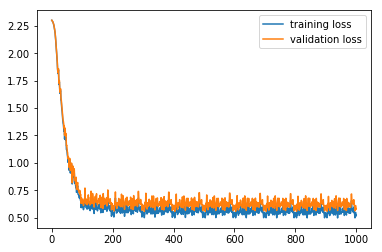

Accuracy: training 8.950e-01, validation 8.610e-01, testing 8.710e-01
Gradient test passed
After 0 iterations, ||theta|| 1.142e+01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.169e+01, training loss is 5.59e-01, and validation loss is 6.12e-01

After 200 iterations, ||theta|| 1.197e+01, training loss is 5.02e-01, and validation loss is 5.63e-01

After 300 iterations, ||theta|| 1.199e+01, training loss is 4.96e-01, and validation loss is 5.59e-01

After 400 iterations, ||theta|| 1.200e+01, training loss is 4.94e-01, and validation loss is 5.56e-01

After 500 iterations, ||theta|| 1.200e+01, training loss is 4.92e-01, and validation loss is 5.54e-01

After 600 iterations, ||theta|| 1.201e+01, training loss is 4.91e-01, and validation loss is 5.53e-01

After 700 iterations, ||theta|| 1.201e+01, training loss is 4.90e-01, and validation loss is 5.52e-01

After 800 iterations, ||theta|| 1.201e+01, training loss is 4.90e-01, and validation lo

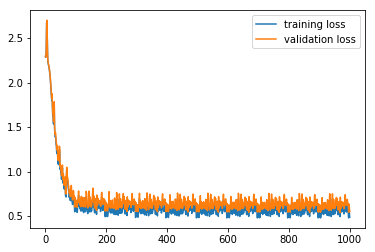

Accuracy: training 8.980e-01, validation 8.630e-01, testing 8.688e-01
Gradient test passed
After 0 iterations, ||theta|| 1.615e+01, training loss is 2.28e+00, and validation loss is 2.28e+00

After 100 iterations, ||theta|| 1.251e+01, training loss is 5.95e-01, and validation loss is 6.57e-01

After 200 iterations, ||theta|| 1.285e+01, training loss is 5.03e-01, and validation loss is 5.76e-01

After 300 iterations, ||theta|| 1.281e+01, training loss is 4.92e-01, and validation loss is 5.63e-01

After 400 iterations, ||theta|| 1.283e+01, training loss is 4.86e-01, and validation loss is 5.58e-01

After 500 iterations, ||theta|| 1.282e+01, training loss is 4.84e-01, and validation loss is 5.56e-01

After 600 iterations, ||theta|| 1.283e+01, training loss is 4.83e-01, and validation loss is 5.54e-01

After 700 iterations, ||theta|| 1.282e+01, training loss is 4.83e-01, and validation loss is 5.53e-01

After 800 iterations, ||theta|| 1.282e+01, training loss is 4.83e-01, and validation lo

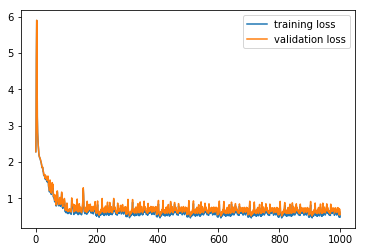

Accuracy: training 8.900e-01, validation 8.570e-01, testing 8.619e-01
Gradient test passed
After 0 iterations, ||theta|| 1.978e+01, training loss is 2.37e+00, and validation loss is 2.37e+00

After 100 iterations, ||theta|| 1.353e+01, training loss is 6.43e-01, and validation loss is 6.90e-01

After 200 iterations, ||theta|| 1.368e+01, training loss is 5.40e-01, and validation loss is 6.14e-01

After 300 iterations, ||theta|| 1.389e+01, training loss is 5.17e-01, and validation loss is 5.95e-01

After 400 iterations, ||theta|| 1.369e+01, training loss is 5.43e-01, and validation loss is 6.20e-01

After 500 iterations, ||theta|| 1.377e+01, training loss is 4.98e-01, and validation loss is 5.76e-01

After 600 iterations, ||theta|| 1.370e+01, training loss is 5.17e-01, and validation loss is 5.94e-01

After 700 iterations, ||theta|| 1.375e+01, training loss is 4.88e-01, and validation loss is 5.64e-01

After 800 iterations, ||theta|| 1.378e+01, training loss is 4.93e-01, and validation lo

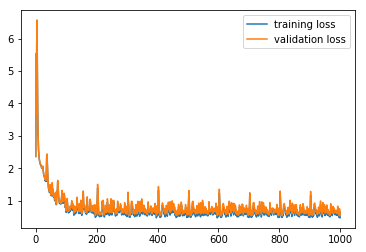

Accuracy: training 8.890e-01, validation 8.490e-01, testing 8.551e-01
Gradient test passed
After 0 iterations, ||theta|| 3.283e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 100 iterations, ||theta|| 1.161e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 200 iterations, ||theta|| 1.199e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 300 iterations, ||theta|| 1.201e+00, training loss is 2.23e+00, and validation loss is 2.23e+00

After 400 iterations, ||theta|| 1.208e+00, training loss is 2.22e+00, and validation loss is 2.23e+00

After 500 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 600 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 700 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation loss is 2.22e+00

After 800 iterations, ||theta|| 1.212e+00, training loss is 2.22e+00, and validation lo

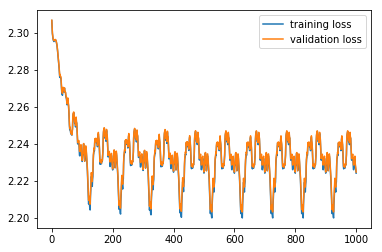

Accuracy: training 2.040e-01, validation 2.070e-01, testing 2.091e-01
Gradient test passed
After 0 iterations, ||theta|| 7.341e+00, training loss is 2.33e+00, and validation loss is 2.33e+00

After 100 iterations, ||theta|| 1.442e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 200 iterations, ||theta|| 1.468e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 300 iterations, ||theta|| 1.473e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 400 iterations, ||theta|| 1.476e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 500 iterations, ||theta|| 1.479e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 600 iterations, ||theta|| 1.480e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 700 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation loss is 2.19e+00

After 800 iterations, ||theta|| 1.482e+00, training loss is 2.19e+00, and validation lo

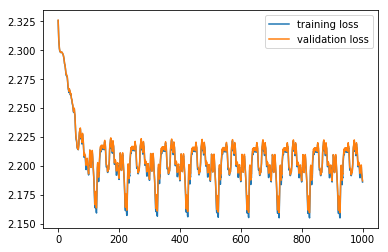

Accuracy: training 2.110e-01, validation 2.060e-01, testing 2.058e-01
Gradient test passed
After 0 iterations, ||theta|| 1.038e+01, training loss is 2.34e+00, and validation loss is 2.34e+00

After 100 iterations, ||theta|| 1.480e+00, training loss is 2.40e+00, and validation loss is 2.40e+00

After 200 iterations, ||theta|| 1.637e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 300 iterations, ||theta|| 1.667e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 400 iterations, ||theta|| 1.648e+00, training loss is 2.28e+00, and validation loss is 2.28e+00

After 500 iterations, ||theta|| 1.678e+00, training loss is 2.31e+00, and validation loss is 2.31e+00

After 600 iterations, ||theta|| 1.676e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.640e+00, training loss is 2.26e+00, and validation loss is 2.27e+00

After 800 iterations, ||theta|| 1.641e+00, training loss is 2.26e+00, and validation lo

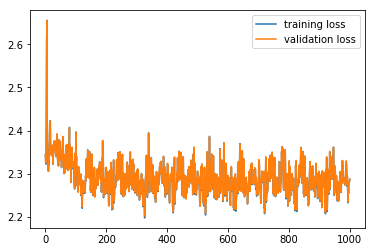

Accuracy: training 1.720e-01, validation 1.780e-01, testing 1.752e-01
Gradient test passed
After 0 iterations, ||theta|| 1.469e+01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 3.150e+00, training loss is 3.00e+00, and validation loss is 2.99e+00

After 200 iterations, ||theta|| 2.610e+00, training loss is 2.73e+00, and validation loss is 2.72e+00

After 300 iterations, ||theta|| 2.829e+00, training loss is 2.75e+00, and validation loss is 2.74e+00

After 400 iterations, ||theta|| 2.953e+00, training loss is 2.88e+00, and validation loss is 2.87e+00

After 500 iterations, ||theta|| 2.786e+00, training loss is 2.97e+00, and validation loss is 2.96e+00

After 600 iterations, ||theta|| 3.076e+00, training loss is 2.70e+00, and validation loss is 2.69e+00

After 700 iterations, ||theta|| 2.662e+00, training loss is 2.72e+00, and validation loss is 2.72e+00

After 800 iterations, ||theta|| 2.595e+00, training loss is 2.77e+00, and validation lo

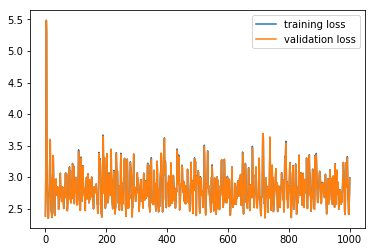

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.799e+01, training loss is 2.51e+00, and validation loss is 2.52e+00

After 100 iterations, ||theta|| 3.817e+00, training loss is 2.79e+00, and validation loss is 2.79e+00

After 200 iterations, ||theta|| 4.547e+00, training loss is 3.32e+00, and validation loss is 3.32e+00

After 300 iterations, ||theta|| 4.385e+00, training loss is 4.14e+00, and validation loss is 4.13e+00

After 400 iterations, ||theta|| 3.885e+00, training loss is 3.71e+00, and validation loss is 3.71e+00

After 500 iterations, ||theta|| 4.335e+00, training loss is 3.27e+00, and validation loss is 3.26e+00

After 600 iterations, ||theta|| 3.854e+00, training loss is 3.16e+00, and validation loss is 3.15e+00

After 700 iterations, ||theta|| 3.974e+00, training loss is 3.65e+00, and validation loss is 3.64e+00

After 800 iterations, ||theta|| 4.010e+00, training loss is 3.96e+00, and validation lo

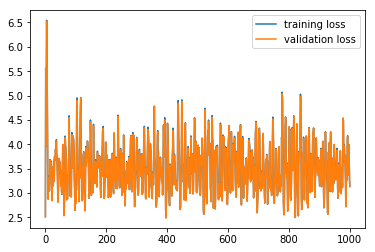

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.097e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 200 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 300 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 400 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 500 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 600 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 700 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation loss is 2.30e+00

After 800 iterations, ||theta|| 1.126e-16, training loss is 2.30e+00, and validation lo

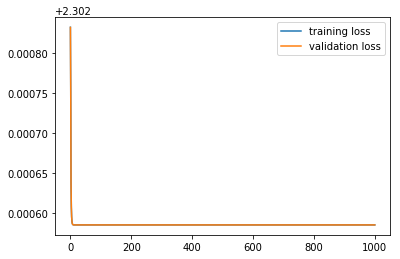

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 1.602e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 200 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 300 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 400 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 500 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 600 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 700 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation loss is 2.96e+00

After 800 iterations, ||theta|| 4.642e+00, training loss is 2.98e+00, and validation lo

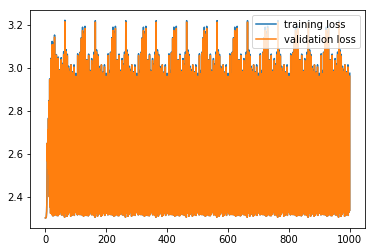

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 3.257e-01, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 200 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 300 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 400 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 500 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 600 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 700 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation loss is 3.73e+00

After 800 iterations, ||theta|| 6.569e+00, training loss is 3.75e+00, and validation lo

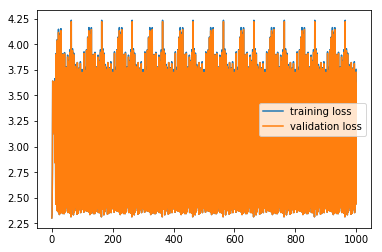

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 4.594e-01, training loss is 2.32e+00, and validation loss is 2.32e+00

After 100 iterations, ||theta|| 1.532e+00, training loss is 2.83e+00, and validation loss is 2.83e+00

After 200 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 300 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 400 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 500 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 600 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 700 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation loss is 2.84e+00

After 800 iterations, ||theta|| 1.536e+00, training loss is 2.84e+00, and validation lo

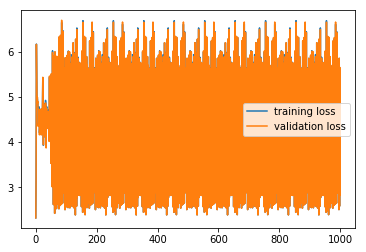

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01
Gradient test passed
After 0 iterations, ||theta|| 5.833e-01, training loss is 2.38e+00, and validation loss is 2.38e+00

After 100 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 200 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 300 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 400 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 500 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 600 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 700 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation loss is 6.08e+00

After 800 iterations, ||theta|| 1.109e+01, training loss is 6.17e+00, and validation lo

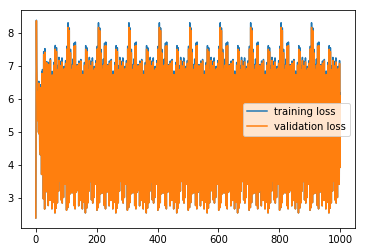

Accuracy: training 1.000e-01, validation 1.000e-01, testing 1.000e-01


In [556]:
n_hidden = [10,50,100,200,300]
n_iters = 1000
learning_rate=1.0
momentum_mul=0.5
weight_decay=[0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
earlystopping=[True,False]
df7 = pd.DataFrame(columns=["loss_train",'loss_valid','loss_test'])
for el in earlystopping:
    for wd in weight_decay:
        for nh in n_hidden:
            info=train(wd, nh, n_iters, learning_rate, momentum_mul, el, minibatch_size=10)
            loss_info=pd.DataFrame([[info['loss_train'],info['loss_valid'],info['loss_test']]],columns=["loss_train",'loss_valid','loss_test'])
            df7=df7.append(loss_info,ignore_index=True) 

In [557]:
mean_off=df7[(df7.index>=35)]['loss_valid'].mean()
mean_on=df7[(df7.index<35)]['loss_valid'].mean()
mean_on,mean_off

(0.8977337976779957, 1.1117546726556227)

In [558]:
print("Firstly, we should build our model with early stopping.")

Firstly, we should build our model with early stopping.


In [559]:
mean_nh1=df7[(df7.index<7)]['loss_valid'].mean()
mean_nh2=df7[(df7.index>=7)&(df7.index<14)]['loss_valid'].mean()
mean_nh3=df7[(df7.index>=14)&(df7.index<21)]['loss_valid'].mean()
mean_nh4=df7[(df7.index>=21)&(df7.index<28)]['loss_valid'].mean()
mean_nh5=df7[(df7.index>=28)&(df7.index<35)]['loss_valid'].mean()
mean_nh1,mean_nh2,mean_nh3,mean_nh4,mean_nh5

(0.28115128994052624,
 0.2782055465173921,
 0.34206429931788734,
 1.2392393558680044,
 2.3480084967461687)

In [560]:
print("Secondly, we should build our model with 50 hidden units")

Secondly, we should build our model with 50 hidden units


In [561]:
df7[(df7.index>=7)&(df7.index<14)]['loss_valid']

7     0.267524
8     0.289052
9     0.274477
10    0.320533
11    0.246884
12    0.263097
13    0.285872
Name: loss_valid, dtype: float64

In [562]:
print("Thirdly, we should build our model with weight decay le-1.")

Thirdly, we should build our model with weight decay le-1.


In [563]:
print('And Nesterov has an overall better performance than classical momentum.')

And Nesterov has an overall better performance than classical momentum.


Gradient test passed
After 0 iterations, ||theta|| 8.075e+00, training loss is 2.30e+00, and validation loss is 2.30e+00

After 100 iterations, ||theta|| 1.115e+01, training loss is 6.11e-01, and validation loss is 6.47e-01

After 200 iterations, ||theta|| 1.159e+01, training loss is 5.36e-01, and validation loss is 5.92e-01

After 300 iterations, ||theta|| 1.162e+01, training loss is 5.27e-01, and validation loss is 5.85e-01

After 400 iterations, ||theta|| 1.163e+01, training loss is 5.24e-01, and validation loss is 5.84e-01

After 500 iterations, ||theta|| 1.163e+01, training loss is 5.23e-01, and validation loss is 5.83e-01

After 600 iterations, ||theta|| 1.164e+01, training loss is 5.22e-01, and validation loss is 5.82e-01

After 700 iterations, ||theta|| 1.164e+01, training loss is 5.21e-01, and validation loss is 5.82e-01

After 800 iterations, ||theta|| 1.164e+01, training loss is 5.20e-01, and validation loss is 5.82e-01

After 900 iterations, ||theta|| 1.164e+01, training lo

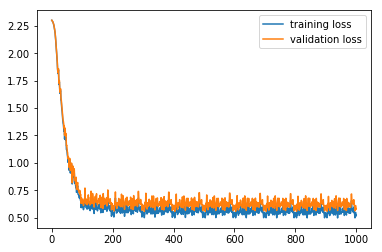

Early stopping: validation loss: 5.558e-01,  was lowest after 404 iterations
Accuracy: training 9.060e-01, validation 8.870e-01, testing 8.840e-01


{'loss_train': 0.490760787258209,
 'loss_valid': 0.5490871550592348,
 'loss_test': 0.5484979732461879}

In [565]:
train(1e-1, 50, 1000, 1.0, 0.5, True, minibatch_size=10)